In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
import numpy as np
from util import getHashId, pickleLoad

feature_selection = pickleLoad('data/feature_selection.pkl')
features_oc = np.load('data/preprocessed/features_vox.npy')
exc = 20
features = [f for f in features_oc if f not in feature_selection['excludeds'][exc][np.argmax(feature_selection['accuracies'][exc])]]

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : features,
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b50','k7_b50','k9_b50','k11_b50','k13_b50','k15_b50','k17_b50','k19_b50','k21_b50']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_firstorder_Range_firstorder_Skewness_firstorder_Variance_firstorder_Uniformity_glcm_JointAverage_glcm_ClusterProminence_glcm_ClusterShade_glcm_ClusterTendency_glcm_Contrast_glcm_Correlation_glcm_DifferenceAverage_glcm_DifferenceEntropy_glcm_DifferenceVariance_glcm_JointEnergy_glcm_JointEntropy_glcm_Imc2_glcm_Idm_glcm_MCC_glcm_Idmn_glcm_Id_glcm_Idn_glcm_InverseVariance_glcm_MaximumProbability_glcm_SumEntropy_glcm_SumSquares_glszm_SmallAreaEmphasis_glszm_LargeAreaEmphasis_glszm_GrayLevelNonUniformity_glszm_GrayLevelNonUniformityNormalized_glszm_SizeZoneNonUniformity_glszm_SizeZoneNonUniformityNormalized_glszm_ZonePercentage_glszm_GrayLevelVariance_glszm_ZoneEntropy_glszm_HighGrayLevelZoneEmphasis_glszm_LargeAreaLowGrayLevelEmphasis_glszm_LargeAreaHighGrayLevelEmphasis_glrlm_ShortRunEmphasis_glrlm_LongRunEmphasis_glrlm_GrayLevelNonUniformity_glrlm_GrayLevelNonUniformityNormalized_glrlm_RunLengthNonUniformity_glrlm_Run

In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 648)
(3944610, 8)
validation
(464344, 648)
(464344, 8)
test
(574820, 648)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 648)]             0         


 dense (Dense)               (None, 1024)              664576    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1354632 (5.17 MB)


Trainable params: 1354632 (5.17 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/395 [..............................] - ETA: 10:58 - loss: 2.2060 - STD: 0.0694 - MAE: 0.2188

  4/395 [..............................] - ETA: 7s - loss: 2.1065 - STD: 0.0561 - MAE: 0.2165   

  7/395 [..............................] - ETA: 7s - loss: 2.0955 - STD: 0.0513 - MAE: 0.2164

 10/395 [..............................] - ETA: 7s - loss: 2.0849 - STD: 0.0453 - MAE: 0.2166

 13/395 [..............................] - ETA: 7s - loss: 2.0776 - STD: 0.0427 - MAE: 0.2166

 16/395 [>.............................] - ETA: 7s - loss: 2.0729 - STD: 0.0419 - MAE: 0.2165

 19/395 [>.............................] - ETA: 7s - loss: 2.0687 - STD: 0.0413 - MAE: 0.2165

 22/395 [>.............................] - ETA: 7s - loss: 2.0643 - STD: 0.0404 - MAE: 0.2164

 25/395 [>.............................] - ETA: 7s - loss: 2.0597 - STD: 0.0392 - MAE: 0.2163

 28/395 [=>............................] - ETA: 7s - loss: 2.0544 - STD: 0.0385 - MAE: 0.2162

 31/395 [=>............................] - ETA: 7s - loss: 2.0476 - STD: 0.0387 - MAE: 0.2160

 34/395 [=>............................] - ETA: 7s - loss: 2.0402 - STD: 0.0397 - MAE: 0.2157

 37/395 [=>............................] - ETA: 7s - loss: 2.0327 - STD: 0.0411 - MAE: 0.2153

 40/395 [==>...........................] - ETA: 6s - loss: 2.0250 - STD: 0.0427 - MAE: 0.2149

 43/395 [==>...........................] - ETA: 6s - loss: 2.0173 - STD: 0.0443 - MAE: 0.2145

 46/395 [==>...........................] - ETA: 6s - loss: 2.0099 - STD: 0.0460 - MAE: 0.2141

 49/395 [==>...........................] - ETA: 6s - loss: 2.0021 - STD: 0.0475 - MAE: 0.2137

 52/395 [==>...........................] - ETA: 6s - loss: 1.9940 - STD: 0.0490 - MAE: 0.2132

 55/395 [===>..........................] - ETA: 6s - loss: 1.9858 - STD: 0.0505 - MAE: 0.2128

 58/395 [===>..........................] - ETA: 6s - loss: 1.9774 - STD: 0.0519 - MAE: 0.2124

 61/395 [===>..........................] - ETA: 6s - loss: 1.9689 - STD: 0.0533 - MAE: 0.2119

 64/395 [===>..........................] - ETA: 6s - loss: 1.9602 - STD: 0.0546 - MAE: 0.2115

 67/395 [====>.........................] - ETA: 6s - loss: 1.9509 - STD: 0.0560 - MAE: 0.2110

 70/395 [====>.........................] - ETA: 6s - loss: 1.9411 - STD: 0.0574 - MAE: 0.2105

 73/395 [====>.........................] - ETA: 6s - loss: 1.9307 - STD: 0.0588 - MAE: 0.2100

 76/395 [====>.........................] - ETA: 6s - loss: 1.9193 - STD: 0.0603 - MAE: 0.2094

 79/395 [=====>........................] - ETA: 6s - loss: 1.9077 - STD: 0.0620 - MAE: 0.2087

 82/395 [=====>........................] - ETA: 6s - loss: 1.8960 - STD: 0.0637 - MAE: 0.2081

 85/395 [=====>........................] - ETA: 6s - loss: 1.8839 - STD: 0.0655 - MAE: 0.2074

 88/395 [=====>........................] - ETA: 5s - loss: 1.8722 - STD: 0.0673 - MAE: 0.2066

 91/395 [=====>........................] - ETA: 5s - loss: 1.8603 - STD: 0.0691 - MAE: 0.2059

 94/395 [======>.......................] - ETA: 5s - loss: 1.8485 - STD: 0.0710 - MAE: 0.2052

 97/395 [======>.......................] - ETA: 5s - loss: 1.8370 - STD: 0.0728 - MAE: 0.2044

100/395 [======>.......................] - ETA: 5s - loss: 1.8256 - STD: 0.0745 - MAE: 0.2037

103/395 [======>.......................] - ETA: 5s - loss: 1.8144 - STD: 0.0763 - MAE: 0.2029

106/395 [=======>......................] - ETA: 5s - loss: 1.8036 - STD: 0.0780 - MAE: 0.2022

109/395 [=======>......................] - ETA: 5s - loss: 1.7931 - STD: 0.0797 - MAE: 0.2015

112/395 [=======>......................] - ETA: 5s - loss: 1.7830 - STD: 0.0814 - MAE: 0.2008

115/395 [=======>......................] - ETA: 5s - loss: 1.7734 - STD: 0.0831 - MAE: 0.2001

118/395 [=======>......................] - ETA: 5s - loss: 1.7642 - STD: 0.0847 - MAE: 0.1994

121/395 [========>.....................] - ETA: 5s - loss: 1.7554 - STD: 0.0862 - MAE: 0.1988

124/395 [========>.....................] - ETA: 5s - loss: 1.7468 - STD: 0.0877 - MAE: 0.1981

127/395 [========>.....................] - ETA: 5s - loss: 1.7386 - STD: 0.0891 - MAE: 0.1975

130/395 [========>.....................] - ETA: 5s - loss: 1.7306 - STD: 0.0905 - MAE: 0.1970

133/395 [=========>....................] - ETA: 5s - loss: 1.7229 - STD: 0.0918 - MAE: 0.1964

136/395 [=========>....................] - ETA: 5s - loss: 1.7155 - STD: 0.0931 - MAE: 0.1958

139/395 [=========>....................] - ETA: 4s - loss: 1.7082 - STD: 0.0944 - MAE: 0.1953

142/395 [=========>....................] - ETA: 4s - loss: 1.7011 - STD: 0.0956 - MAE: 0.1948

143/395 [=========>....................] - ETA: 6s - loss: 1.7001 - STD: 0.0960 - MAE: 0.1946

146/395 [==========>...................] - ETA: 6s - loss: 1.6933 - STD: 0.0972 - MAE: 0.1941

149/395 [==========>...................] - ETA: 6s - loss: 1.6867 - STD: 0.0983 - MAE: 0.1936

152/395 [==========>...................] - ETA: 6s - loss: 1.6802 - STD: 0.0994 - MAE: 0.1931

155/395 [==========>...................] - ETA: 6s - loss: 1.6739 - STD: 0.1005 - MAE: 0.1927

158/395 [===========>..................] - ETA: 5s - loss: 1.6677 - STD: 0.1015 - MAE: 0.1922

161/395 [===========>..................] - ETA: 5s - loss: 1.6618 - STD: 0.1025 - MAE: 0.1918

164/395 [===========>..................] - ETA: 5s - loss: 1.6561 - STD: 0.1034 - MAE: 0.1913

167/395 [===========>..................] - ETA: 5s - loss: 1.6502 - STD: 0.1044 - MAE: 0.1909

170/395 [===========>..................] - ETA: 5s - loss: 1.6448 - STD: 0.1053 - MAE: 0.1905

173/395 [============>.................] - ETA: 5s - loss: 1.6394 - STD: 0.1063 - MAE: 0.1901

176/395 [============>.................] - ETA: 5s - loss: 1.6341 - STD: 0.1072 - MAE: 0.1897

179/395 [============>.................] - ETA: 5s - loss: 1.6290 - STD: 0.1080 - MAE: 0.1893

182/395 [============>.................] - ETA: 5s - loss: 1.6240 - STD: 0.1089 - MAE: 0.1889

185/395 [=============>................] - ETA: 5s - loss: 1.6192 - STD: 0.1097 - MAE: 0.1885

188/395 [=============>................] - ETA: 5s - loss: 1.6143 - STD: 0.1105 - MAE: 0.1882

191/395 [=============>................] - ETA: 4s - loss: 1.6097 - STD: 0.1113 - MAE: 0.1878

194/395 [=============>................] - ETA: 4s - loss: 1.6051 - STD: 0.1121 - MAE: 0.1874

197/395 [=============>................] - ETA: 4s - loss: 1.6007 - STD: 0.1128 - MAE: 0.1871

200/395 [==============>...............] - ETA: 4s - loss: 1.5963 - STD: 0.1135 - MAE: 0.1868

203/395 [==============>...............] - ETA: 4s - loss: 1.5921 - STD: 0.1143 - MAE: 0.1864

206/395 [==============>...............] - ETA: 4s - loss: 1.5878 - STD: 0.1150 - MAE: 0.1861

209/395 [==============>...............] - ETA: 4s - loss: 1.5836 - STD: 0.1157 - MAE: 0.1858

212/395 [===============>..............] - ETA: 4s - loss: 1.5796 - STD: 0.1164 - MAE: 0.1855

215/395 [===============>..............] - ETA: 4s - loss: 1.5756 - STD: 0.1170 - MAE: 0.1851

218/395 [===============>..............] - ETA: 4s - loss: 1.5718 - STD: 0.1177 - MAE: 0.1848

221/395 [===============>..............] - ETA: 4s - loss: 1.5681 - STD: 0.1183 - MAE: 0.1846

224/395 [================>.............] - ETA: 4s - loss: 1.5644 - STD: 0.1189 - MAE: 0.1843

227/395 [================>.............] - ETA: 3s - loss: 1.5609 - STD: 0.1195 - MAE: 0.1840

230/395 [================>.............] - ETA: 3s - loss: 1.5573 - STD: 0.1201 - MAE: 0.1837

233/395 [================>.............] - ETA: 3s - loss: 1.5538 - STD: 0.1207 - MAE: 0.1834

236/395 [================>.............] - ETA: 3s - loss: 1.5504 - STD: 0.1213 - MAE: 0.1831

239/395 [=================>............] - ETA: 3s - loss: 1.5469 - STD: 0.1219 - MAE: 0.1829

242/395 [=================>............] - ETA: 3s - loss: 1.5434 - STD: 0.1224 - MAE: 0.1826

245/395 [=================>............] - ETA: 3s - loss: 1.5402 - STD: 0.1230 - MAE: 0.1823

248/395 [=================>............] - ETA: 3s - loss: 1.5370 - STD: 0.1235 - MAE: 0.1821

251/395 [==================>...........] - ETA: 3s - loss: 1.5338 - STD: 0.1240 - MAE: 0.1818

254/395 [==================>...........] - ETA: 3s - loss: 1.5307 - STD: 0.1246 - MAE: 0.1816

257/395 [==================>...........] - ETA: 3s - loss: 1.5276 - STD: 0.1251 - MAE: 0.1813

260/395 [==================>...........] - ETA: 3s - loss: 1.5246 - STD: 0.1256 - MAE: 0.1811

263/395 [==================>...........] - ETA: 3s - loss: 1.5217 - STD: 0.1261 - MAE: 0.1809

266/395 [===================>..........] - ETA: 2s - loss: 1.5187 - STD: 0.1266 - MAE: 0.1806

269/395 [===================>..........] - ETA: 2s - loss: 1.5159 - STD: 0.1271 - MAE: 0.1804

272/395 [===================>..........] - ETA: 2s - loss: 1.5131 - STD: 0.1275 - MAE: 0.1802

275/395 [===================>..........] - ETA: 2s - loss: 1.5103 - STD: 0.1280 - MAE: 0.1799

278/395 [====================>.........] - ETA: 2s - loss: 1.5077 - STD: 0.1284 - MAE: 0.1797

281/395 [====================>.........] - ETA: 2s - loss: 1.5052 - STD: 0.1289 - MAE: 0.1795

284/395 [====================>.........] - ETA: 2s - loss: 1.5025 - STD: 0.1293 - MAE: 0.1793

287/395 [====================>.........] - ETA: 2s - loss: 1.4998 - STD: 0.1298 - MAE: 0.1791

290/395 [=====================>........] - ETA: 2s - loss: 1.4972 - STD: 0.1302 - MAE: 0.1789

293/395 [=====================>........] - ETA: 2s - loss: 1.4947 - STD: 0.1306 - MAE: 0.1787

296/395 [=====================>........] - ETA: 2s - loss: 1.4921 - STD: 0.1310 - MAE: 0.1785

299/395 [=====================>........] - ETA: 2s - loss: 1.4896 - STD: 0.1314 - MAE: 0.1783

302/395 [=====================>........] - ETA: 2s - loss: 1.4872 - STD: 0.1318 - MAE: 0.1781

305/395 [======================>.......] - ETA: 2s - loss: 1.4848 - STD: 0.1322 - MAE: 0.1779

308/395 [======================>.......] - ETA: 1s - loss: 1.4823 - STD: 0.1326 - MAE: 0.1777

311/395 [======================>.......] - ETA: 1s - loss: 1.4798 - STD: 0.1330 - MAE: 0.1775

314/395 [======================>.......] - ETA: 1s - loss: 1.4776 - STD: 0.1334 - MAE: 0.1773

317/395 [=======================>......] - ETA: 1s - loss: 1.4752 - STD: 0.1338 - MAE: 0.1771

320/395 [=======================>......] - ETA: 1s - loss: 1.4730 - STD: 0.1341 - MAE: 0.1769

323/395 [=======================>......] - ETA: 1s - loss: 1.4707 - STD: 0.1345 - MAE: 0.1767

326/395 [=======================>......] - ETA: 1s - loss: 1.4685 - STD: 0.1349 - MAE: 0.1765

329/395 [=======================>......] - ETA: 1s - loss: 1.4662 - STD: 0.1353 - MAE: 0.1763

332/395 [========================>.....] - ETA: 1s - loss: 1.4640 - STD: 0.1356 - MAE: 0.1761

335/395 [========================>.....] - ETA: 1s - loss: 1.4618 - STD: 0.1360 - MAE: 0.1760

338/395 [========================>.....] - ETA: 1s - loss: 1.4596 - STD: 0.1363 - MAE: 0.1758

341/395 [========================>.....] - ETA: 1s - loss: 1.4573 - STD: 0.1367 - MAE: 0.1756

344/395 [=========================>....] - ETA: 1s - loss: 1.4551 - STD: 0.1370 - MAE: 0.1754

347/395 [=========================>....] - ETA: 1s - loss: 1.4530 - STD: 0.1374 - MAE: 0.1752

350/395 [=========================>....] - ETA: 0s - loss: 1.4508 - STD: 0.1377 - MAE: 0.1751

353/395 [=========================>....] - ETA: 0s - loss: 1.4489 - STD: 0.1380 - MAE: 0.1749

356/395 [==========================>...] - ETA: 0s - loss: 1.4472 - STD: 0.1384 - MAE: 0.1747

359/395 [==========================>...] - ETA: 0s - loss: 1.4452 - STD: 0.1387 - MAE: 0.1746

362/395 [==========================>...] - ETA: 0s - loss: 1.4432 - STD: 0.1390 - MAE: 0.1744

365/395 [==========================>...] - ETA: 0s - loss: 1.4412 - STD: 0.1393 - MAE: 0.1742

368/395 [==========================>...] - ETA: 0s - loss: 1.4392 - STD: 0.1396 - MAE: 0.1741

371/395 [===========================>..] - ETA: 0s - loss: 1.4373 - STD: 0.1399 - MAE: 0.1739

374/395 [===========================>..] - ETA: 0s - loss: 1.4353 - STD: 0.1403 - MAE: 0.1737

377/395 [===========================>..] - ETA: 0s - loss: 1.4334 - STD: 0.1406 - MAE: 0.1736

380/395 [===========================>..] - ETA: 0s - loss: 1.4314 - STD: 0.1408 - MAE: 0.1734

383/395 [============================>.] - ETA: 0s - loss: 1.4296 - STD: 0.1411 - MAE: 0.1733

386/395 [============================>.] - ETA: 0s - loss: 1.4277 - STD: 0.1414 - MAE: 0.1731

389/395 [============================>.] - ETA: 0s - loss: 1.4258 - STD: 0.1417 - MAE: 0.1729

392/395 [============================>.] - ETA: 0s - loss: 1.4240 - STD: 0.1420 - MAE: 0.1728

395/395 [==============================] - ETA: 0s - loss: 1.4221 - STD: 0.1423 - MAE: 0.1726

395/395 [==============================] - 12s 25ms/step - loss: 1.4221 - STD: 0.1423 - MAE: 0.1726 - val_loss: 1.2710 - val_STD: 0.1837 - val_MAE: 0.1528


Epoch 2/10000


  1/395 [..............................] - ETA: 17s - loss: 1.1778 - STD: 0.1813 - MAE: 0.1514

  4/395 [..............................] - ETA: 7s - loss: 1.1823 - STD: 0.1808 - MAE: 0.1518 

  7/395 [..............................] - ETA: 7s - loss: 1.1823 - STD: 0.1806 - MAE: 0.1519

 10/395 [..............................] - ETA: 7s - loss: 1.1790 - STD: 0.1808 - MAE: 0.1517

 13/395 [..............................] - ETA: 7s - loss: 1.1815 - STD: 0.1809 - MAE: 0.1517

 16/395 [>.............................] - ETA: 7s - loss: 1.1822 - STD: 0.1810 - MAE: 0.1517

 19/395 [>.............................] - ETA: 7s - loss: 1.1837 - STD: 0.1811 - MAE: 0.1518

 22/395 [>.............................] - ETA: 7s - loss: 1.1833 - STD: 0.1813 - MAE: 0.1517

 25/395 [>.............................] - ETA: 7s - loss: 1.1835 - STD: 0.1813 - MAE: 0.1517

 28/395 [=>............................] - ETA: 7s - loss: 1.1820 - STD: 0.1814 - MAE: 0.1516

 31/395 [=>............................] - ETA: 7s - loss: 1.1816 - STD: 0.1815 - MAE: 0.1515

 34/395 [=>............................] - ETA: 7s - loss: 1.1811 - STD: 0.1814 - MAE: 0.1515

 37/395 [=>............................] - ETA: 6s - loss: 1.1809 - STD: 0.1814 - MAE: 0.1515

 40/395 [==>...........................] - ETA: 6s - loss: 1.1803 - STD: 0.1815 - MAE: 0.1515

 43/395 [==>...........................] - ETA: 6s - loss: 1.1794 - STD: 0.1815 - MAE: 0.1514

 46/395 [==>...........................] - ETA: 6s - loss: 1.1782 - STD: 0.1815 - MAE: 0.1514

 49/395 [==>...........................] - ETA: 6s - loss: 1.1767 - STD: 0.1817 - MAE: 0.1512

 52/395 [==>...........................] - ETA: 6s - loss: 1.1763 - STD: 0.1819 - MAE: 0.1511

 55/395 [===>..........................] - ETA: 6s - loss: 1.1750 - STD: 0.1820 - MAE: 0.1510

 58/395 [===>..........................] - ETA: 6s - loss: 1.1738 - STD: 0.1820 - MAE: 0.1510

 61/395 [===>..........................] - ETA: 6s - loss: 1.1745 - STD: 0.1822 - MAE: 0.1509

 64/395 [===>..........................] - ETA: 6s - loss: 1.1743 - STD: 0.1823 - MAE: 0.1509

 67/395 [====>.........................] - ETA: 6s - loss: 1.1734 - STD: 0.1823 - MAE: 0.1508

 70/395 [====>.........................] - ETA: 6s - loss: 1.1728 - STD: 0.1824 - MAE: 0.1508

 73/395 [====>.........................] - ETA: 6s - loss: 1.1722 - STD: 0.1825 - MAE: 0.1507

 76/395 [====>.........................] - ETA: 6s - loss: 1.1719 - STD: 0.1825 - MAE: 0.1507

 79/395 [=====>........................] - ETA: 6s - loss: 1.1711 - STD: 0.1826 - MAE: 0.1506

 82/395 [=====>........................] - ETA: 6s - loss: 1.1706 - STD: 0.1826 - MAE: 0.1506

 85/395 [=====>........................] - ETA: 6s - loss: 1.1706 - STD: 0.1827 - MAE: 0.1505

 88/395 [=====>........................] - ETA: 6s - loss: 1.1699 - STD: 0.1828 - MAE: 0.1505

 91/395 [=====>........................] - ETA: 5s - loss: 1.1693 - STD: 0.1829 - MAE: 0.1504

 94/395 [======>.......................] - ETA: 5s - loss: 1.1687 - STD: 0.1831 - MAE: 0.1503

 97/395 [======>.......................] - ETA: 5s - loss: 1.1681 - STD: 0.1831 - MAE: 0.1503

100/395 [======>.......................] - ETA: 5s - loss: 1.1677 - STD: 0.1831 - MAE: 0.1502

103/395 [======>.......................] - ETA: 5s - loss: 1.1672 - STD: 0.1832 - MAE: 0.1502

106/395 [=======>......................] - ETA: 5s - loss: 1.1665 - STD: 0.1832 - MAE: 0.1501

109/395 [=======>......................] - ETA: 5s - loss: 1.1658 - STD: 0.1833 - MAE: 0.1501

112/395 [=======>......................] - ETA: 5s - loss: 1.1650 - STD: 0.1834 - MAE: 0.1500

115/395 [=======>......................] - ETA: 5s - loss: 1.1647 - STD: 0.1835 - MAE: 0.1500

118/395 [=======>......................] - ETA: 5s - loss: 1.1638 - STD: 0.1835 - MAE: 0.1499

121/395 [========>.....................] - ETA: 5s - loss: 1.1632 - STD: 0.1836 - MAE: 0.1498

124/395 [========>.....................] - ETA: 5s - loss: 1.1625 - STD: 0.1837 - MAE: 0.1498

127/395 [========>.....................] - ETA: 5s - loss: 1.1621 - STD: 0.1838 - MAE: 0.1497

130/395 [========>.....................] - ETA: 5s - loss: 1.1616 - STD: 0.1839 - MAE: 0.1497

133/395 [=========>....................] - ETA: 5s - loss: 1.1608 - STD: 0.1839 - MAE: 0.1496

136/395 [=========>....................] - ETA: 5s - loss: 1.1600 - STD: 0.1840 - MAE: 0.1495

139/395 [=========>....................] - ETA: 5s - loss: 1.1592 - STD: 0.1841 - MAE: 0.1495

142/395 [=========>....................] - ETA: 4s - loss: 1.1584 - STD: 0.1842 - MAE: 0.1494

146/395 [==========>...................] - ETA: 4s - loss: 1.1575 - STD: 0.1843 - MAE: 0.1493

149/395 [==========>...................] - ETA: 4s - loss: 1.1571 - STD: 0.1844 - MAE: 0.1492

152/395 [==========>...................] - ETA: 4s - loss: 1.1577 - STD: 0.1845 - MAE: 0.1492

155/395 [==========>...................] - ETA: 4s - loss: 1.1579 - STD: 0.1846 - MAE: 0.1492

158/395 [===========>..................] - ETA: 4s - loss: 1.1578 - STD: 0.1846 - MAE: 0.1492

161/395 [===========>..................] - ETA: 4s - loss: 1.1576 - STD: 0.1847 - MAE: 0.1491

164/395 [===========>..................] - ETA: 4s - loss: 1.1571 - STD: 0.1848 - MAE: 0.1491

167/395 [===========>..................] - ETA: 4s - loss: 1.1565 - STD: 0.1848 - MAE: 0.1491

170/395 [===========>..................] - ETA: 4s - loss: 1.1559 - STD: 0.1849 - MAE: 0.1490

173/395 [============>.................] - ETA: 4s - loss: 1.1554 - STD: 0.1849 - MAE: 0.1490

176/395 [============>.................] - ETA: 4s - loss: 1.1547 - STD: 0.1850 - MAE: 0.1489

179/395 [============>.................] - ETA: 4s - loss: 1.1542 - STD: 0.1850 - MAE: 0.1489

182/395 [============>.................] - ETA: 4s - loss: 1.1537 - STD: 0.1851 - MAE: 0.1488

185/395 [=============>................] - ETA: 4s - loss: 1.1535 - STD: 0.1851 - MAE: 0.1488

188/395 [=============>................] - ETA: 4s - loss: 1.1530 - STD: 0.1852 - MAE: 0.1487

191/395 [=============>................] - ETA: 4s - loss: 1.1529 - STD: 0.1852 - MAE: 0.1487

194/395 [=============>................] - ETA: 3s - loss: 1.1525 - STD: 0.1853 - MAE: 0.1487

197/395 [=============>................] - ETA: 3s - loss: 1.1519 - STD: 0.1854 - MAE: 0.1486

200/395 [==============>...............] - ETA: 3s - loss: 1.1514 - STD: 0.1854 - MAE: 0.1486

203/395 [==============>...............] - ETA: 3s - loss: 1.1509 - STD: 0.1855 - MAE: 0.1485

206/395 [==============>...............] - ETA: 3s - loss: 1.1504 - STD: 0.1856 - MAE: 0.1485

209/395 [==============>...............] - ETA: 3s - loss: 1.1498 - STD: 0.1856 - MAE: 0.1484

212/395 [===============>..............] - ETA: 3s - loss: 1.1493 - STD: 0.1857 - MAE: 0.1484

215/395 [===============>..............] - ETA: 3s - loss: 1.1489 - STD: 0.1858 - MAE: 0.1483

218/395 [===============>..............] - ETA: 3s - loss: 1.1484 - STD: 0.1858 - MAE: 0.1483

221/395 [===============>..............] - ETA: 3s - loss: 1.1478 - STD: 0.1859 - MAE: 0.1482

224/395 [================>.............] - ETA: 3s - loss: 1.1472 - STD: 0.1859 - MAE: 0.1482

227/395 [================>.............] - ETA: 3s - loss: 1.1468 - STD: 0.1860 - MAE: 0.1481

230/395 [================>.............] - ETA: 3s - loss: 1.1464 - STD: 0.1861 - MAE: 0.1481

233/395 [================>.............] - ETA: 3s - loss: 1.1460 - STD: 0.1861 - MAE: 0.1480

236/395 [================>.............] - ETA: 3s - loss: 1.1454 - STD: 0.1862 - MAE: 0.1480

239/395 [=================>............] - ETA: 3s - loss: 1.1447 - STD: 0.1862 - MAE: 0.1479

242/395 [=================>............] - ETA: 3s - loss: 1.1443 - STD: 0.1863 - MAE: 0.1479

245/395 [=================>............] - ETA: 2s - loss: 1.1439 - STD: 0.1864 - MAE: 0.1478

248/395 [=================>............] - ETA: 2s - loss: 1.1436 - STD: 0.1864 - MAE: 0.1478

251/395 [==================>...........] - ETA: 2s - loss: 1.1431 - STD: 0.1865 - MAE: 0.1477

254/395 [==================>...........] - ETA: 2s - loss: 1.1428 - STD: 0.1866 - MAE: 0.1477

257/395 [==================>...........] - ETA: 2s - loss: 1.1422 - STD: 0.1866 - MAE: 0.1476

260/395 [==================>...........] - ETA: 2s - loss: 1.1417 - STD: 0.1867 - MAE: 0.1476

263/395 [==================>...........] - ETA: 2s - loss: 1.1413 - STD: 0.1867 - MAE: 0.1475

266/395 [===================>..........] - ETA: 2s - loss: 1.1407 - STD: 0.1868 - MAE: 0.1475

269/395 [===================>..........] - ETA: 2s - loss: 1.1403 - STD: 0.1869 - MAE: 0.1474

272/395 [===================>..........] - ETA: 2s - loss: 1.1401 - STD: 0.1869 - MAE: 0.1474

275/395 [===================>..........] - ETA: 2s - loss: 1.1398 - STD: 0.1870 - MAE: 0.1474

278/395 [====================>.........] - ETA: 2s - loss: 1.1396 - STD: 0.1870 - MAE: 0.1473

281/395 [====================>.........] - ETA: 2s - loss: 1.1392 - STD: 0.1871 - MAE: 0.1473

284/395 [====================>.........] - ETA: 2s - loss: 1.1388 - STD: 0.1871 - MAE: 0.1473

287/395 [====================>.........] - ETA: 2s - loss: 1.1384 - STD: 0.1872 - MAE: 0.1472

290/395 [=====================>........] - ETA: 2s - loss: 1.1381 - STD: 0.1872 - MAE: 0.1472

293/395 [=====================>........] - ETA: 2s - loss: 1.1378 - STD: 0.1873 - MAE: 0.1472

296/395 [=====================>........] - ETA: 1s - loss: 1.1374 - STD: 0.1873 - MAE: 0.1471

299/395 [=====================>........] - ETA: 1s - loss: 1.1371 - STD: 0.1874 - MAE: 0.1471

302/395 [=====================>........] - ETA: 1s - loss: 1.1366 - STD: 0.1874 - MAE: 0.1470

305/395 [======================>.......] - ETA: 1s - loss: 1.1362 - STD: 0.1875 - MAE: 0.1470

308/395 [======================>.......] - ETA: 1s - loss: 1.1358 - STD: 0.1876 - MAE: 0.1469

311/395 [======================>.......] - ETA: 1s - loss: 1.1354 - STD: 0.1876 - MAE: 0.1469

314/395 [======================>.......] - ETA: 1s - loss: 1.1350 - STD: 0.1876 - MAE: 0.1469

317/395 [=======================>......] - ETA: 1s - loss: 1.1346 - STD: 0.1877 - MAE: 0.1468

320/395 [=======================>......] - ETA: 1s - loss: 1.1343 - STD: 0.1877 - MAE: 0.1468

323/395 [=======================>......] - ETA: 1s - loss: 1.1338 - STD: 0.1878 - MAE: 0.1467

326/395 [=======================>......] - ETA: 1s - loss: 1.1333 - STD: 0.1879 - MAE: 0.1467

329/395 [=======================>......] - ETA: 1s - loss: 1.1328 - STD: 0.1879 - MAE: 0.1467

332/395 [========================>.....] - ETA: 1s - loss: 1.1324 - STD: 0.1880 - MAE: 0.1466

335/395 [========================>.....] - ETA: 1s - loss: 1.1320 - STD: 0.1880 - MAE: 0.1466

338/395 [========================>.....] - ETA: 1s - loss: 1.1317 - STD: 0.1881 - MAE: 0.1465

341/395 [========================>.....] - ETA: 1s - loss: 1.1313 - STD: 0.1881 - MAE: 0.1465

344/395 [=========================>....] - ETA: 1s - loss: 1.1310 - STD: 0.1882 - MAE: 0.1465

347/395 [=========================>....] - ETA: 0s - loss: 1.1308 - STD: 0.1882 - MAE: 0.1464

350/395 [=========================>....] - ETA: 0s - loss: 1.1305 - STD: 0.1883 - MAE: 0.1464

353/395 [=========================>....] - ETA: 0s - loss: 1.1301 - STD: 0.1883 - MAE: 0.1464

356/395 [==========================>...] - ETA: 0s - loss: 1.1298 - STD: 0.1884 - MAE: 0.1463

359/395 [==========================>...] - ETA: 0s - loss: 1.1296 - STD: 0.1884 - MAE: 0.1463

362/395 [==========================>...] - ETA: 0s - loss: 1.1292 - STD: 0.1885 - MAE: 0.1462

365/395 [==========================>...] - ETA: 0s - loss: 1.1287 - STD: 0.1885 - MAE: 0.1462

368/395 [==========================>...] - ETA: 0s - loss: 1.1282 - STD: 0.1886 - MAE: 0.1462

371/395 [===========================>..] - ETA: 0s - loss: 1.1278 - STD: 0.1886 - MAE: 0.1461

374/395 [===========================>..] - ETA: 0s - loss: 1.1274 - STD: 0.1887 - MAE: 0.1461

377/395 [===========================>..] - ETA: 0s - loss: 1.1270 - STD: 0.1887 - MAE: 0.1460

380/395 [===========================>..] - ETA: 0s - loss: 1.1265 - STD: 0.1888 - MAE: 0.1460

383/395 [============================>.] - ETA: 0s - loss: 1.1261 - STD: 0.1888 - MAE: 0.1459

386/395 [============================>.] - ETA: 0s - loss: 1.1258 - STD: 0.1889 - MAE: 0.1459

389/395 [============================>.] - ETA: 0s - loss: 1.1253 - STD: 0.1889 - MAE: 0.1459

392/395 [============================>.] - ETA: 0s - loss: 1.1251 - STD: 0.1890 - MAE: 0.1458

395/395 [==============================] - ETA: 0s - loss: 1.1247 - STD: 0.1890 - MAE: 0.1458

395/395 [==============================] - 9s 21ms/step - loss: 1.1247 - STD: 0.1890 - MAE: 0.1458 - val_loss: 1.1533 - val_STD: 0.1952 - val_MAE: 0.1439


Epoch 3/10000


  1/395 [..............................] - ETA: 18s - loss: 1.1000 - STD: 0.1963 - MAE: 0.1416

  4/395 [..............................] - ETA: 7s - loss: 1.0870 - STD: 0.1960 - MAE: 0.1410 

  7/395 [..............................] - ETA: 7s - loss: 1.0865 - STD: 0.1957 - MAE: 0.1411

 10/395 [..............................] - ETA: 7s - loss: 1.0858 - STD: 0.1959 - MAE: 0.1410

 13/395 [..............................] - ETA: 7s - loss: 1.0869 - STD: 0.1959 - MAE: 0.1410

 16/395 [>.............................] - ETA: 7s - loss: 1.0874 - STD: 0.1959 - MAE: 0.1411

 19/395 [>.............................] - ETA: 7s - loss: 1.0848 - STD: 0.1959 - MAE: 0.1410

 22/395 [>.............................] - ETA: 7s - loss: 1.0834 - STD: 0.1958 - MAE: 0.1409

 25/395 [>.............................] - ETA: 7s - loss: 1.0825 - STD: 0.1958 - MAE: 0.1409

 28/395 [=>............................] - ETA: 7s - loss: 1.0812 - STD: 0.1958 - MAE: 0.1408

 31/395 [=>............................] - ETA: 7s - loss: 1.0799 - STD: 0.1958 - MAE: 0.1407

 34/395 [=>............................] - ETA: 7s - loss: 1.0784 - STD: 0.1959 - MAE: 0.1406

 37/395 [=>............................] - ETA: 7s - loss: 1.0777 - STD: 0.1959 - MAE: 0.1406

 40/395 [==>...........................] - ETA: 7s - loss: 1.0767 - STD: 0.1960 - MAE: 0.1405

 43/395 [==>...........................] - ETA: 7s - loss: 1.0755 - STD: 0.1961 - MAE: 0.1404

 46/395 [==>...........................] - ETA: 6s - loss: 1.0749 - STD: 0.1961 - MAE: 0.1404

 49/395 [==>...........................] - ETA: 6s - loss: 1.0741 - STD: 0.1961 - MAE: 0.1403

 52/395 [==>...........................] - ETA: 6s - loss: 1.0728 - STD: 0.1962 - MAE: 0.1402

 55/395 [===>..........................] - ETA: 6s - loss: 1.0715 - STD: 0.1963 - MAE: 0.1401

 58/395 [===>..........................] - ETA: 6s - loss: 1.0701 - STD: 0.1964 - MAE: 0.1400

 61/395 [===>..........................] - ETA: 6s - loss: 1.0696 - STD: 0.1965 - MAE: 0.1399

 64/395 [===>..........................] - ETA: 6s - loss: 1.0688 - STD: 0.1966 - MAE: 0.1398

 67/395 [====>.........................] - ETA: 6s - loss: 1.0680 - STD: 0.1967 - MAE: 0.1398

 70/395 [====>.........................] - ETA: 6s - loss: 1.0673 - STD: 0.1967 - MAE: 0.1397

 73/395 [====>.........................] - ETA: 6s - loss: 1.0670 - STD: 0.1968 - MAE: 0.1396

 76/395 [====>.........................] - ETA: 6s - loss: 1.0665 - STD: 0.1969 - MAE: 0.1396

 79/395 [=====>........................] - ETA: 6s - loss: 1.0657 - STD: 0.1969 - MAE: 0.1395

 82/395 [=====>........................] - ETA: 6s - loss: 1.0656 - STD: 0.1970 - MAE: 0.1395

 85/395 [=====>........................] - ETA: 6s - loss: 1.0648 - STD: 0.1971 - MAE: 0.1394

 88/395 [=====>........................] - ETA: 6s - loss: 1.0653 - STD: 0.1971 - MAE: 0.1394

 91/395 [=====>........................] - ETA: 6s - loss: 1.0652 - STD: 0.1971 - MAE: 0.1394

 94/395 [======>.......................] - ETA: 5s - loss: 1.0657 - STD: 0.1972 - MAE: 0.1394

 97/395 [======>.......................] - ETA: 5s - loss: 1.0654 - STD: 0.1972 - MAE: 0.1394

100/395 [======>.......................] - ETA: 5s - loss: 1.0653 - STD: 0.1973 - MAE: 0.1394

103/395 [======>.......................] - ETA: 5s - loss: 1.0651 - STD: 0.1973 - MAE: 0.1393

106/395 [=======>......................] - ETA: 5s - loss: 1.0646 - STD: 0.1973 - MAE: 0.1393

109/395 [=======>......................] - ETA: 5s - loss: 1.0645 - STD: 0.1974 - MAE: 0.1393

112/395 [=======>......................] - ETA: 5s - loss: 1.0639 - STD: 0.1974 - MAE: 0.1392

115/395 [=======>......................] - ETA: 5s - loss: 1.0632 - STD: 0.1974 - MAE: 0.1392

118/395 [=======>......................] - ETA: 5s - loss: 1.0628 - STD: 0.1975 - MAE: 0.1391

121/395 [========>.....................] - ETA: 5s - loss: 1.0627 - STD: 0.1975 - MAE: 0.1391

124/395 [========>.....................] - ETA: 5s - loss: 1.0624 - STD: 0.1976 - MAE: 0.1391

127/395 [========>.....................] - ETA: 5s - loss: 1.0623 - STD: 0.1976 - MAE: 0.1390

130/395 [========>.....................] - ETA: 5s - loss: 1.0618 - STD: 0.1977 - MAE: 0.1390

133/395 [=========>....................] - ETA: 5s - loss: 1.0615 - STD: 0.1977 - MAE: 0.1390

136/395 [=========>....................] - ETA: 5s - loss: 1.0613 - STD: 0.1978 - MAE: 0.1389

139/395 [=========>....................] - ETA: 5s - loss: 1.0616 - STD: 0.1979 - MAE: 0.1389

142/395 [=========>....................] - ETA: 5s - loss: 1.0614 - STD: 0.1979 - MAE: 0.1389

145/395 [==========>...................] - ETA: 4s - loss: 1.0610 - STD: 0.1979 - MAE: 0.1389

148/395 [==========>...................] - ETA: 4s - loss: 1.0606 - STD: 0.1979 - MAE: 0.1388

151/395 [==========>...................] - ETA: 4s - loss: 1.0603 - STD: 0.1980 - MAE: 0.1388

154/395 [==========>...................] - ETA: 4s - loss: 1.0599 - STD: 0.1980 - MAE: 0.1388

157/395 [==========>...................] - ETA: 4s - loss: 1.0597 - STD: 0.1980 - MAE: 0.1388

160/395 [===========>..................] - ETA: 4s - loss: 1.0594 - STD: 0.1981 - MAE: 0.1387

163/395 [===========>..................] - ETA: 4s - loss: 1.0590 - STD: 0.1981 - MAE: 0.1387

166/395 [===========>..................] - ETA: 4s - loss: 1.0588 - STD: 0.1982 - MAE: 0.1387

169/395 [===========>..................] - ETA: 4s - loss: 1.0586 - STD: 0.1982 - MAE: 0.1386

172/395 [============>.................] - ETA: 4s - loss: 1.0585 - STD: 0.1983 - MAE: 0.1386

175/395 [============>.................] - ETA: 4s - loss: 1.0584 - STD: 0.1983 - MAE: 0.1386

178/395 [============>.................] - ETA: 4s - loss: 1.0584 - STD: 0.1984 - MAE: 0.1386

181/395 [============>.................] - ETA: 4s - loss: 1.0586 - STD: 0.1984 - MAE: 0.1386

184/395 [============>.................] - ETA: 4s - loss: 1.0588 - STD: 0.1985 - MAE: 0.1386

187/395 [=============>................] - ETA: 4s - loss: 1.0587 - STD: 0.1985 - MAE: 0.1385

190/395 [=============>................] - ETA: 4s - loss: 1.0588 - STD: 0.1985 - MAE: 0.1385

193/395 [=============>................] - ETA: 4s - loss: 1.0588 - STD: 0.1985 - MAE: 0.1385

196/395 [=============>................] - ETA: 3s - loss: 1.0584 - STD: 0.1986 - MAE: 0.1385

199/395 [==============>...............] - ETA: 3s - loss: 1.0581 - STD: 0.1986 - MAE: 0.1385

202/395 [==============>...............] - ETA: 3s - loss: 1.0578 - STD: 0.1986 - MAE: 0.1384

205/395 [==============>...............] - ETA: 3s - loss: 1.0576 - STD: 0.1987 - MAE: 0.1384

208/395 [==============>...............] - ETA: 3s - loss: 1.0575 - STD: 0.1987 - MAE: 0.1384

211/395 [===============>..............] - ETA: 3s - loss: 1.0572 - STD: 0.1987 - MAE: 0.1384

214/395 [===============>..............] - ETA: 3s - loss: 1.0568 - STD: 0.1988 - MAE: 0.1383

217/395 [===============>..............] - ETA: 3s - loss: 1.0565 - STD: 0.1988 - MAE: 0.1383

220/395 [===============>..............] - ETA: 3s - loss: 1.0563 - STD: 0.1988 - MAE: 0.1383

223/395 [===============>..............] - ETA: 3s - loss: 1.0559 - STD: 0.1989 - MAE: 0.1382

226/395 [================>.............] - ETA: 3s - loss: 1.0556 - STD: 0.1989 - MAE: 0.1382

229/395 [================>.............] - ETA: 3s - loss: 1.0552 - STD: 0.1989 - MAE: 0.1382

232/395 [================>.............] - ETA: 3s - loss: 1.0547 - STD: 0.1990 - MAE: 0.1381

235/395 [================>.............] - ETA: 3s - loss: 1.0544 - STD: 0.1990 - MAE: 0.1381

238/395 [=================>............] - ETA: 3s - loss: 1.0541 - STD: 0.1990 - MAE: 0.1381

241/395 [=================>............] - ETA: 3s - loss: 1.0538 - STD: 0.1991 - MAE: 0.1380

244/395 [=================>............] - ETA: 2s - loss: 1.0535 - STD: 0.1991 - MAE: 0.1380

247/395 [=================>............] - ETA: 2s - loss: 1.0532 - STD: 0.1992 - MAE: 0.1380

250/395 [=================>............] - ETA: 2s - loss: 1.0529 - STD: 0.1992 - MAE: 0.1379

253/395 [==================>...........] - ETA: 2s - loss: 1.0525 - STD: 0.1993 - MAE: 0.1379

256/395 [==================>...........] - ETA: 2s - loss: 1.0521 - STD: 0.1993 - MAE: 0.1378

259/395 [==================>...........] - ETA: 2s - loss: 1.0518 - STD: 0.1993 - MAE: 0.1378

262/395 [==================>...........] - ETA: 2s - loss: 1.0515 - STD: 0.1994 - MAE: 0.1378

265/395 [===================>..........] - ETA: 2s - loss: 1.0511 - STD: 0.1994 - MAE: 0.1377

268/395 [===================>..........] - ETA: 2s - loss: 1.0508 - STD: 0.1995 - MAE: 0.1377

271/395 [===================>..........] - ETA: 2s - loss: 1.0504 - STD: 0.1995 - MAE: 0.1377

274/395 [===================>..........] - ETA: 2s - loss: 1.0501 - STD: 0.1996 - MAE: 0.1376

277/395 [====================>.........] - ETA: 2s - loss: 1.0497 - STD: 0.1996 - MAE: 0.1376

280/395 [====================>.........] - ETA: 2s - loss: 1.0494 - STD: 0.1997 - MAE: 0.1375

283/395 [====================>.........] - ETA: 2s - loss: 1.0490 - STD: 0.1997 - MAE: 0.1375

286/395 [====================>.........] - ETA: 2s - loss: 1.0488 - STD: 0.1998 - MAE: 0.1375

289/395 [====================>.........] - ETA: 2s - loss: 1.0485 - STD: 0.1998 - MAE: 0.1374

292/395 [=====================>........] - ETA: 2s - loss: 1.0484 - STD: 0.1999 - MAE: 0.1374

295/395 [=====================>........] - ETA: 1s - loss: 1.0481 - STD: 0.1999 - MAE: 0.1374

298/395 [=====================>........] - ETA: 1s - loss: 1.0478 - STD: 0.2000 - MAE: 0.1373

301/395 [=====================>........] - ETA: 1s - loss: 1.0475 - STD: 0.2000 - MAE: 0.1373

304/395 [======================>.......] - ETA: 1s - loss: 1.0472 - STD: 0.2000 - MAE: 0.1373

307/395 [======================>.......] - ETA: 1s - loss: 1.0470 - STD: 0.2001 - MAE: 0.1372

310/395 [======================>.......] - ETA: 1s - loss: 1.0468 - STD: 0.2001 - MAE: 0.1372

313/395 [======================>.......] - ETA: 1s - loss: 1.0465 - STD: 0.2002 - MAE: 0.1372

316/395 [=======================>......] - ETA: 1s - loss: 1.0462 - STD: 0.2002 - MAE: 0.1371

319/395 [=======================>......] - ETA: 1s - loss: 1.0460 - STD: 0.2002 - MAE: 0.1371

322/395 [=======================>......] - ETA: 1s - loss: 1.0457 - STD: 0.2003 - MAE: 0.1371

325/395 [=======================>......] - ETA: 1s - loss: 1.0455 - STD: 0.2003 - MAE: 0.1371

328/395 [=======================>......] - ETA: 1s - loss: 1.0452 - STD: 0.2003 - MAE: 0.1370

331/395 [========================>.....] - ETA: 1s - loss: 1.0450 - STD: 0.2004 - MAE: 0.1370

334/395 [========================>.....] - ETA: 1s - loss: 1.0448 - STD: 0.2004 - MAE: 0.1370

337/395 [========================>.....] - ETA: 1s - loss: 1.0444 - STD: 0.2005 - MAE: 0.1369

340/395 [========================>.....] - ETA: 1s - loss: 1.0441 - STD: 0.2005 - MAE: 0.1369

343/395 [=========================>....] - ETA: 1s - loss: 1.0438 - STD: 0.2005 - MAE: 0.1369

346/395 [=========================>....] - ETA: 0s - loss: 1.0436 - STD: 0.2006 - MAE: 0.1368

349/395 [=========================>....] - ETA: 0s - loss: 1.0433 - STD: 0.2006 - MAE: 0.1368

352/395 [=========================>....] - ETA: 0s - loss: 1.0431 - STD: 0.2007 - MAE: 0.1368

355/395 [=========================>....] - ETA: 0s - loss: 1.0431 - STD: 0.2007 - MAE: 0.1368

358/395 [==========================>...] - ETA: 0s - loss: 1.0429 - STD: 0.2007 - MAE: 0.1367

361/395 [==========================>...] - ETA: 0s - loss: 1.0428 - STD: 0.2008 - MAE: 0.1367

364/395 [==========================>...] - ETA: 0s - loss: 1.0425 - STD: 0.2008 - MAE: 0.1367

367/395 [==========================>...] - ETA: 0s - loss: 1.0424 - STD: 0.2008 - MAE: 0.1367

370/395 [===========================>..] - ETA: 0s - loss: 1.0422 - STD: 0.2009 - MAE: 0.1366

373/395 [===========================>..] - ETA: 0s - loss: 1.0418 - STD: 0.2009 - MAE: 0.1366

376/395 [===========================>..] - ETA: 0s - loss: 1.0416 - STD: 0.2010 - MAE: 0.1366

379/395 [===========================>..] - ETA: 0s - loss: 1.0413 - STD: 0.2010 - MAE: 0.1366

382/395 [============================>.] - ETA: 0s - loss: 1.0410 - STD: 0.2010 - MAE: 0.1365

385/395 [============================>.] - ETA: 0s - loss: 1.0407 - STD: 0.2011 - MAE: 0.1365

388/395 [============================>.] - ETA: 0s - loss: 1.0405 - STD: 0.2011 - MAE: 0.1365

391/395 [============================>.] - ETA: 0s - loss: 1.0402 - STD: 0.2012 - MAE: 0.1364

394/395 [============================>.] - ETA: 0s - loss: 1.0400 - STD: 0.2012 - MAE: 0.1364

395/395 [==============================] - 8s 21ms/step - loss: 1.0399 - STD: 0.2012 - MAE: 0.1364 - val_loss: 1.1725 - val_STD: 0.2072 - val_MAE: 0.1386


Epoch 4/10000


  1/395 [..............................] - ETA: 14s - loss: 1.0224 - STD: 0.2083 - MAE: 0.1324

  4/395 [..............................] - ETA: 7s - loss: 1.0197 - STD: 0.2073 - MAE: 0.1329 

  7/395 [..............................] - ETA: 7s - loss: 1.0171 - STD: 0.2071 - MAE: 0.1328

 10/395 [..............................] - ETA: 7s - loss: 1.0150 - STD: 0.2066 - MAE: 0.1329

 13/395 [..............................] - ETA: 7s - loss: 1.0138 - STD: 0.2060 - MAE: 0.1330

 16/395 [>.............................] - ETA: 7s - loss: 1.0137 - STD: 0.2061 - MAE: 0.1329

 19/395 [>.............................] - ETA: 7s - loss: 1.0129 - STD: 0.2062 - MAE: 0.1328

 22/395 [>.............................] - ETA: 7s - loss: 1.0131 - STD: 0.2063 - MAE: 0.1328

 25/395 [>.............................] - ETA: 7s - loss: 1.0107 - STD: 0.2063 - MAE: 0.1327

 28/395 [=>............................] - ETA: 7s - loss: 1.0112 - STD: 0.2063 - MAE: 0.1327

 31/395 [=>............................] - ETA: 7s - loss: 1.0116 - STD: 0.2064 - MAE: 0.1327

 34/395 [=>............................] - ETA: 7s - loss: 1.0123 - STD: 0.2064 - MAE: 0.1327

 37/395 [=>............................] - ETA: 7s - loss: 1.0125 - STD: 0.2064 - MAE: 0.1327

 40/395 [==>...........................] - ETA: 7s - loss: 1.0122 - STD: 0.2063 - MAE: 0.1327

 43/395 [==>...........................] - ETA: 7s - loss: 1.0117 - STD: 0.2063 - MAE: 0.1327

 46/395 [==>...........................] - ETA: 6s - loss: 1.0107 - STD: 0.2063 - MAE: 0.1327

 49/395 [==>...........................] - ETA: 6s - loss: 1.0102 - STD: 0.2063 - MAE: 0.1326

 52/395 [==>...........................] - ETA: 6s - loss: 1.0090 - STD: 0.2063 - MAE: 0.1326

 55/395 [===>..........................] - ETA: 6s - loss: 1.0081 - STD: 0.2063 - MAE: 0.1325

 58/395 [===>..........................] - ETA: 6s - loss: 1.0070 - STD: 0.2063 - MAE: 0.1324

 61/395 [===>..........................] - ETA: 6s - loss: 1.0063 - STD: 0.2064 - MAE: 0.1324

 64/395 [===>..........................] - ETA: 6s - loss: 1.0064 - STD: 0.2065 - MAE: 0.1323

 67/395 [====>.........................] - ETA: 6s - loss: 1.0059 - STD: 0.2066 - MAE: 0.1323

 70/395 [====>.........................] - ETA: 6s - loss: 1.0072 - STD: 0.2066 - MAE: 0.1323

 73/395 [====>.........................] - ETA: 6s - loss: 1.0070 - STD: 0.2067 - MAE: 0.1323

 76/395 [====>.........................] - ETA: 6s - loss: 1.0063 - STD: 0.2067 - MAE: 0.1322

 79/395 [=====>........................] - ETA: 6s - loss: 1.0057 - STD: 0.2068 - MAE: 0.1322

 82/395 [=====>........................] - ETA: 6s - loss: 1.0061 - STD: 0.2068 - MAE: 0.1322

 85/395 [=====>........................] - ETA: 6s - loss: 1.0060 - STD: 0.2067 - MAE: 0.1322

 88/395 [=====>........................] - ETA: 6s - loss: 1.0058 - STD: 0.2067 - MAE: 0.1322

 91/395 [=====>........................] - ETA: 6s - loss: 1.0054 - STD: 0.2068 - MAE: 0.1322

 94/395 [======>.......................] - ETA: 5s - loss: 1.0052 - STD: 0.2068 - MAE: 0.1321

 97/395 [======>.......................] - ETA: 5s - loss: 1.0049 - STD: 0.2069 - MAE: 0.1321

100/395 [======>.......................] - ETA: 5s - loss: 1.0042 - STD: 0.2069 - MAE: 0.1320

103/395 [======>.......................] - ETA: 5s - loss: 1.0039 - STD: 0.2070 - MAE: 0.1320

106/395 [=======>......................] - ETA: 5s - loss: 1.0042 - STD: 0.2070 - MAE: 0.1320

109/395 [=======>......................] - ETA: 5s - loss: 1.0046 - STD: 0.2070 - MAE: 0.1320

112/395 [=======>......................] - ETA: 5s - loss: 1.0046 - STD: 0.2071 - MAE: 0.1320

115/395 [=======>......................] - ETA: 5s - loss: 1.0045 - STD: 0.2071 - MAE: 0.1320

118/395 [=======>......................] - ETA: 5s - loss: 1.0040 - STD: 0.2071 - MAE: 0.1320

121/395 [========>.....................] - ETA: 5s - loss: 1.0037 - STD: 0.2071 - MAE: 0.1319

124/395 [========>.....................] - ETA: 5s - loss: 1.0035 - STD: 0.2072 - MAE: 0.1319

127/395 [========>.....................] - ETA: 5s - loss: 1.0029 - STD: 0.2072 - MAE: 0.1319

130/395 [========>.....................] - ETA: 5s - loss: 1.0028 - STD: 0.2073 - MAE: 0.1318

133/395 [=========>....................] - ETA: 5s - loss: 1.0027 - STD: 0.2072 - MAE: 0.1318

136/395 [=========>....................] - ETA: 5s - loss: 1.0023 - STD: 0.2073 - MAE: 0.1318

139/395 [=========>....................] - ETA: 5s - loss: 1.0019 - STD: 0.2073 - MAE: 0.1318

142/395 [=========>....................] - ETA: 5s - loss: 1.0014 - STD: 0.2073 - MAE: 0.1317

145/395 [==========>...................] - ETA: 4s - loss: 1.0011 - STD: 0.2074 - MAE: 0.1317

148/395 [==========>...................] - ETA: 4s - loss: 1.0013 - STD: 0.2074 - MAE: 0.1317

151/395 [==========>...................] - ETA: 4s - loss: 1.0011 - STD: 0.2074 - MAE: 0.1317

154/395 [==========>...................] - ETA: 4s - loss: 1.0010 - STD: 0.2074 - MAE: 0.1317

157/395 [==========>...................] - ETA: 4s - loss: 1.0009 - STD: 0.2074 - MAE: 0.1316

160/395 [===========>..................] - ETA: 4s - loss: 1.0008 - STD: 0.2075 - MAE: 0.1316

163/395 [===========>..................] - ETA: 4s - loss: 1.0009 - STD: 0.2075 - MAE: 0.1316

166/395 [===========>..................] - ETA: 4s - loss: 1.0006 - STD: 0.2075 - MAE: 0.1316

169/395 [===========>..................] - ETA: 4s - loss: 1.0005 - STD: 0.2075 - MAE: 0.1316

172/395 [============>.................] - ETA: 4s - loss: 1.0006 - STD: 0.2076 - MAE: 0.1316

175/395 [============>.................] - ETA: 4s - loss: 1.0004 - STD: 0.2076 - MAE: 0.1316

178/395 [============>.................] - ETA: 4s - loss: 1.0003 - STD: 0.2076 - MAE: 0.1315

181/395 [============>.................] - ETA: 4s - loss: 1.0001 - STD: 0.2076 - MAE: 0.1315

184/395 [============>.................] - ETA: 4s - loss: 0.9999 - STD: 0.2076 - MAE: 0.1315

187/395 [=============>................] - ETA: 4s - loss: 0.9997 - STD: 0.2077 - MAE: 0.1315

190/395 [=============>................] - ETA: 4s - loss: 0.9992 - STD: 0.2077 - MAE: 0.1314

193/395 [=============>................] - ETA: 3s - loss: 0.9989 - STD: 0.2077 - MAE: 0.1314

196/395 [=============>................] - ETA: 3s - loss: 0.9988 - STD: 0.2077 - MAE: 0.1314

199/395 [==============>...............] - ETA: 3s - loss: 0.9985 - STD: 0.2078 - MAE: 0.1314

202/395 [==============>...............] - ETA: 3s - loss: 0.9982 - STD: 0.2078 - MAE: 0.1313

205/395 [==============>...............] - ETA: 3s - loss: 0.9980 - STD: 0.2078 - MAE: 0.1313

208/395 [==============>...............] - ETA: 3s - loss: 0.9979 - STD: 0.2078 - MAE: 0.1313

211/395 [===============>..............] - ETA: 3s - loss: 0.9977 - STD: 0.2078 - MAE: 0.1313

214/395 [===============>..............] - ETA: 3s - loss: 0.9979 - STD: 0.2079 - MAE: 0.1313

217/395 [===============>..............] - ETA: 3s - loss: 0.9977 - STD: 0.2079 - MAE: 0.1313

220/395 [===============>..............] - ETA: 3s - loss: 0.9975 - STD: 0.2080 - MAE: 0.1312

223/395 [===============>..............] - ETA: 3s - loss: 0.9975 - STD: 0.2080 - MAE: 0.1312

226/395 [================>.............] - ETA: 3s - loss: 0.9972 - STD: 0.2080 - MAE: 0.1312

229/395 [================>.............] - ETA: 3s - loss: 0.9969 - STD: 0.2080 - MAE: 0.1312

232/395 [================>.............] - ETA: 3s - loss: 0.9967 - STD: 0.2081 - MAE: 0.1311

235/395 [================>.............] - ETA: 3s - loss: 0.9965 - STD: 0.2081 - MAE: 0.1311

238/395 [=================>............] - ETA: 3s - loss: 0.9963 - STD: 0.2081 - MAE: 0.1311

241/395 [=================>............] - ETA: 3s - loss: 0.9961 - STD: 0.2081 - MAE: 0.1311

244/395 [=================>............] - ETA: 2s - loss: 0.9958 - STD: 0.2082 - MAE: 0.1310

247/395 [=================>............] - ETA: 2s - loss: 0.9957 - STD: 0.2082 - MAE: 0.1310

250/395 [=================>............] - ETA: 2s - loss: 0.9957 - STD: 0.2082 - MAE: 0.1310

253/395 [==================>...........] - ETA: 2s - loss: 0.9955 - STD: 0.2083 - MAE: 0.1310

256/395 [==================>...........] - ETA: 2s - loss: 0.9953 - STD: 0.2083 - MAE: 0.1310

259/395 [==================>...........] - ETA: 2s - loss: 0.9950 - STD: 0.2083 - MAE: 0.1309

262/395 [==================>...........] - ETA: 2s - loss: 0.9949 - STD: 0.2083 - MAE: 0.1309

265/395 [===================>..........] - ETA: 2s - loss: 0.9947 - STD: 0.2083 - MAE: 0.1309

268/395 [===================>..........] - ETA: 2s - loss: 0.9945 - STD: 0.2084 - MAE: 0.1309

271/395 [===================>..........] - ETA: 2s - loss: 0.9944 - STD: 0.2084 - MAE: 0.1309

274/395 [===================>..........] - ETA: 2s - loss: 0.9941 - STD: 0.2084 - MAE: 0.1308

277/395 [====================>.........] - ETA: 2s - loss: 0.9940 - STD: 0.2084 - MAE: 0.1308

280/395 [====================>.........] - ETA: 2s - loss: 0.9937 - STD: 0.2085 - MAE: 0.1308

283/395 [====================>.........] - ETA: 2s - loss: 0.9934 - STD: 0.2085 - MAE: 0.1308

286/395 [====================>.........] - ETA: 2s - loss: 0.9932 - STD: 0.2085 - MAE: 0.1307

289/395 [====================>.........] - ETA: 2s - loss: 0.9930 - STD: 0.2085 - MAE: 0.1307

292/395 [=====================>........] - ETA: 2s - loss: 0.9928 - STD: 0.2086 - MAE: 0.1307

295/395 [=====================>........] - ETA: 1s - loss: 0.9926 - STD: 0.2086 - MAE: 0.1307

298/395 [=====================>........] - ETA: 1s - loss: 0.9923 - STD: 0.2086 - MAE: 0.1306

301/395 [=====================>........] - ETA: 1s - loss: 0.9921 - STD: 0.2087 - MAE: 0.1306

304/395 [======================>.......] - ETA: 1s - loss: 0.9918 - STD: 0.2087 - MAE: 0.1306

307/395 [======================>.......] - ETA: 1s - loss: 0.9916 - STD: 0.2087 - MAE: 0.1306

310/395 [======================>.......] - ETA: 1s - loss: 0.9913 - STD: 0.2087 - MAE: 0.1305

313/395 [======================>.......] - ETA: 1s - loss: 0.9911 - STD: 0.2088 - MAE: 0.1305

316/395 [=======================>......] - ETA: 1s - loss: 0.9908 - STD: 0.2088 - MAE: 0.1305

319/395 [=======================>......] - ETA: 1s - loss: 0.9906 - STD: 0.2088 - MAE: 0.1305

322/395 [=======================>......] - ETA: 1s - loss: 0.9905 - STD: 0.2088 - MAE: 0.1304

325/395 [=======================>......] - ETA: 1s - loss: 0.9903 - STD: 0.2089 - MAE: 0.1304

328/395 [=======================>......] - ETA: 1s - loss: 0.9902 - STD: 0.2089 - MAE: 0.1304

331/395 [========================>.....] - ETA: 1s - loss: 0.9902 - STD: 0.2089 - MAE: 0.1304

334/395 [========================>.....] - ETA: 1s - loss: 0.9901 - STD: 0.2090 - MAE: 0.1304

337/395 [========================>.....] - ETA: 1s - loss: 0.9901 - STD: 0.2090 - MAE: 0.1304

340/395 [========================>.....] - ETA: 1s - loss: 0.9902 - STD: 0.2090 - MAE: 0.1304

343/395 [=========================>....] - ETA: 1s - loss: 0.9902 - STD: 0.2090 - MAE: 0.1304

346/395 [=========================>....] - ETA: 0s - loss: 0.9901 - STD: 0.2090 - MAE: 0.1303

349/395 [=========================>....] - ETA: 0s - loss: 0.9900 - STD: 0.2090 - MAE: 0.1303

352/395 [=========================>....] - ETA: 0s - loss: 0.9900 - STD: 0.2091 - MAE: 0.1303

355/395 [=========================>....] - ETA: 0s - loss: 0.9900 - STD: 0.2091 - MAE: 0.1303

358/395 [==========================>...] - ETA: 0s - loss: 0.9898 - STD: 0.2091 - MAE: 0.1303

361/395 [==========================>...] - ETA: 0s - loss: 0.9898 - STD: 0.2091 - MAE: 0.1303

364/395 [==========================>...] - ETA: 0s - loss: 0.9896 - STD: 0.2091 - MAE: 0.1303

367/395 [==========================>...] - ETA: 0s - loss: 0.9894 - STD: 0.2092 - MAE: 0.1303

370/395 [===========================>..] - ETA: 0s - loss: 0.9891 - STD: 0.2092 - MAE: 0.1302

373/395 [===========================>..] - ETA: 0s - loss: 0.9890 - STD: 0.2092 - MAE: 0.1302

376/395 [===========================>..] - ETA: 0s - loss: 0.9889 - STD: 0.2092 - MAE: 0.1302

379/395 [===========================>..] - ETA: 0s - loss: 0.9888 - STD: 0.2092 - MAE: 0.1302

382/395 [============================>.] - ETA: 0s - loss: 0.9887 - STD: 0.2092 - MAE: 0.1302

385/395 [============================>.] - ETA: 0s - loss: 0.9884 - STD: 0.2093 - MAE: 0.1302

388/395 [============================>.] - ETA: 0s - loss: 0.9882 - STD: 0.2093 - MAE: 0.1301

391/395 [============================>.] - ETA: 0s - loss: 0.9879 - STD: 0.2093 - MAE: 0.1301

394/395 [============================>.] - ETA: 0s - loss: 0.9877 - STD: 0.2093 - MAE: 0.1301

395/395 [==============================] - 9s 21ms/step - loss: 0.9877 - STD: 0.2093 - MAE: 0.1301 - val_loss: 1.0808 - val_STD: 0.2108 - val_MAE: 0.1328


Epoch 5/10000


  1/395 [..............................] - ETA: 10s - loss: 0.9569 - STD: 0.2128 - MAE: 0.1269

  4/395 [..............................] - ETA: 8s - loss: 0.9648 - STD: 0.2121 - MAE: 0.1276 

  7/395 [..............................] - ETA: 7s - loss: 0.9616 - STD: 0.2123 - MAE: 0.1274

 10/395 [..............................] - ETA: 7s - loss: 0.9624 - STD: 0.2125 - MAE: 0.1273

 13/395 [..............................] - ETA: 7s - loss: 0.9623 - STD: 0.2125 - MAE: 0.1273

 16/395 [>.............................] - ETA: 7s - loss: 0.9625 - STD: 0.2126 - MAE: 0.1273

 19/395 [>.............................] - ETA: 7s - loss: 0.9609 - STD: 0.2128 - MAE: 0.1271

 22/395 [>.............................] - ETA: 7s - loss: 0.9597 - STD: 0.2129 - MAE: 0.1270

 25/395 [>.............................] - ETA: 7s - loss: 0.9590 - STD: 0.2130 - MAE: 0.1269

 28/395 [=>............................] - ETA: 7s - loss: 0.9583 - STD: 0.2129 - MAE: 0.1269

 31/395 [=>............................] - ETA: 7s - loss: 0.9586 - STD: 0.2130 - MAE: 0.1269

 34/395 [=>............................] - ETA: 7s - loss: 0.9579 - STD: 0.2129 - MAE: 0.1268

 37/395 [=>............................] - ETA: 7s - loss: 0.9584 - STD: 0.2129 - MAE: 0.1269

 40/395 [==>...........................] - ETA: 7s - loss: 0.9589 - STD: 0.2129 - MAE: 0.1269

 43/395 [==>...........................] - ETA: 7s - loss: 0.9598 - STD: 0.2129 - MAE: 0.1270

 46/395 [==>...........................] - ETA: 6s - loss: 0.9607 - STD: 0.2129 - MAE: 0.1270

 49/395 [==>...........................] - ETA: 6s - loss: 0.9614 - STD: 0.2129 - MAE: 0.1271

 52/395 [==>...........................] - ETA: 6s - loss: 0.9612 - STD: 0.2129 - MAE: 0.1271

 55/395 [===>..........................] - ETA: 6s - loss: 0.9607 - STD: 0.2129 - MAE: 0.1270

 58/395 [===>..........................] - ETA: 6s - loss: 0.9601 - STD: 0.2129 - MAE: 0.1270

 61/395 [===>..........................] - ETA: 6s - loss: 0.9610 - STD: 0.2128 - MAE: 0.1270

 64/395 [===>..........................] - ETA: 6s - loss: 0.9620 - STD: 0.2128 - MAE: 0.1271

 67/395 [====>.........................] - ETA: 6s - loss: 0.9623 - STD: 0.2128 - MAE: 0.1271

 70/395 [====>.........................] - ETA: 6s - loss: 0.9621 - STD: 0.2129 - MAE: 0.1271

 73/395 [====>.........................] - ETA: 6s - loss: 0.9619 - STD: 0.2129 - MAE: 0.1271

 76/395 [====>.........................] - ETA: 6s - loss: 0.9620 - STD: 0.2129 - MAE: 0.1271

 79/395 [=====>........................] - ETA: 6s - loss: 0.9612 - STD: 0.2129 - MAE: 0.1270

 82/395 [=====>........................] - ETA: 6s - loss: 0.9612 - STD: 0.2129 - MAE: 0.1270

 85/395 [=====>........................] - ETA: 6s - loss: 0.9610 - STD: 0.2129 - MAE: 0.1270

 88/395 [=====>........................] - ETA: 6s - loss: 0.9612 - STD: 0.2129 - MAE: 0.1270

 91/395 [=====>........................] - ETA: 6s - loss: 0.9607 - STD: 0.2129 - MAE: 0.1270

 94/395 [======>.......................] - ETA: 6s - loss: 0.9608 - STD: 0.2129 - MAE: 0.1270

 97/395 [======>.......................] - ETA: 5s - loss: 0.9612 - STD: 0.2129 - MAE: 0.1270

100/395 [======>.......................] - ETA: 5s - loss: 0.9615 - STD: 0.2129 - MAE: 0.1270

103/395 [======>.......................] - ETA: 5s - loss: 0.9617 - STD: 0.2129 - MAE: 0.1270

106/395 [=======>......................] - ETA: 5s - loss: 0.9623 - STD: 0.2129 - MAE: 0.1271

109/395 [=======>......................] - ETA: 5s - loss: 0.9631 - STD: 0.2130 - MAE: 0.1271

112/395 [=======>......................] - ETA: 5s - loss: 0.9632 - STD: 0.2129 - MAE: 0.1271

115/395 [=======>......................] - ETA: 5s - loss: 0.9636 - STD: 0.2129 - MAE: 0.1271

118/395 [=======>......................] - ETA: 5s - loss: 0.9639 - STD: 0.2129 - MAE: 0.1272

121/395 [========>.....................] - ETA: 5s - loss: 0.9643 - STD: 0.2129 - MAE: 0.1272

124/395 [========>.....................] - ETA: 5s - loss: 0.9645 - STD: 0.2129 - MAE: 0.1272

127/395 [========>.....................] - ETA: 5s - loss: 0.9643 - STD: 0.2129 - MAE: 0.1272

130/395 [========>.....................] - ETA: 5s - loss: 0.9642 - STD: 0.2129 - MAE: 0.1272

133/395 [=========>....................] - ETA: 5s - loss: 0.9641 - STD: 0.2129 - MAE: 0.1272

136/395 [=========>....................] - ETA: 5s - loss: 0.9641 - STD: 0.2130 - MAE: 0.1272

139/395 [=========>....................] - ETA: 5s - loss: 0.9641 - STD: 0.2130 - MAE: 0.1271

142/395 [=========>....................] - ETA: 5s - loss: 0.9647 - STD: 0.2130 - MAE: 0.1272

145/395 [==========>...................] - ETA: 4s - loss: 0.9648 - STD: 0.2130 - MAE: 0.1272

148/395 [==========>...................] - ETA: 4s - loss: 0.9650 - STD: 0.2130 - MAE: 0.1272

151/395 [==========>...................] - ETA: 4s - loss: 0.9653 - STD: 0.2130 - MAE: 0.1272

154/395 [==========>...................] - ETA: 4s - loss: 0.9655 - STD: 0.2130 - MAE: 0.1272

157/395 [==========>...................] - ETA: 4s - loss: 0.9656 - STD: 0.2130 - MAE: 0.1272

160/395 [===========>..................] - ETA: 4s - loss: 0.9657 - STD: 0.2130 - MAE: 0.1272

163/395 [===========>..................] - ETA: 4s - loss: 0.9657 - STD: 0.2130 - MAE: 0.1273

166/395 [===========>..................] - ETA: 4s - loss: 0.9658 - STD: 0.2130 - MAE: 0.1273

169/395 [===========>..................] - ETA: 4s - loss: 0.9657 - STD: 0.2130 - MAE: 0.1272

172/395 [============>.................] - ETA: 4s - loss: 0.9655 - STD: 0.2130 - MAE: 0.1272

175/395 [============>.................] - ETA: 4s - loss: 0.9653 - STD: 0.2130 - MAE: 0.1272

178/395 [============>.................] - ETA: 4s - loss: 0.9650 - STD: 0.2130 - MAE: 0.1272

181/395 [============>.................] - ETA: 4s - loss: 0.9648 - STD: 0.2130 - MAE: 0.1272

184/395 [============>.................] - ETA: 4s - loss: 0.9645 - STD: 0.2130 - MAE: 0.1272

187/395 [=============>................] - ETA: 4s - loss: 0.9641 - STD: 0.2130 - MAE: 0.1271

190/395 [=============>................] - ETA: 4s - loss: 0.9638 - STD: 0.2130 - MAE: 0.1271

193/395 [=============>................] - ETA: 4s - loss: 0.9635 - STD: 0.2130 - MAE: 0.1271

196/395 [=============>................] - ETA: 3s - loss: 0.9633 - STD: 0.2131 - MAE: 0.1271

199/395 [==============>...............] - ETA: 3s - loss: 0.9631 - STD: 0.2131 - MAE: 0.1270

202/395 [==============>...............] - ETA: 3s - loss: 0.9629 - STD: 0.2131 - MAE: 0.1270

205/395 [==============>...............] - ETA: 3s - loss: 0.9627 - STD: 0.2131 - MAE: 0.1270

208/395 [==============>...............] - ETA: 3s - loss: 0.9627 - STD: 0.2131 - MAE: 0.1270

211/395 [===============>..............] - ETA: 3s - loss: 0.9629 - STD: 0.2132 - MAE: 0.1270

214/395 [===============>..............] - ETA: 3s - loss: 0.9627 - STD: 0.2132 - MAE: 0.1270

217/395 [===============>..............] - ETA: 3s - loss: 0.9625 - STD: 0.2132 - MAE: 0.1270

220/395 [===============>..............] - ETA: 3s - loss: 0.9622 - STD: 0.2132 - MAE: 0.1270

223/395 [===============>..............] - ETA: 3s - loss: 0.9618 - STD: 0.2132 - MAE: 0.1269

226/395 [================>.............] - ETA: 3s - loss: 0.9615 - STD: 0.2132 - MAE: 0.1269

229/395 [================>.............] - ETA: 3s - loss: 0.9612 - STD: 0.2132 - MAE: 0.1269

232/395 [================>.............] - ETA: 3s - loss: 0.9609 - STD: 0.2133 - MAE: 0.1268

235/395 [================>.............] - ETA: 3s - loss: 0.9608 - STD: 0.2133 - MAE: 0.1268

238/395 [=================>............] - ETA: 3s - loss: 0.9605 - STD: 0.2133 - MAE: 0.1268

241/395 [=================>............] - ETA: 3s - loss: 0.9603 - STD: 0.2133 - MAE: 0.1268

244/395 [=================>............] - ETA: 3s - loss: 0.9602 - STD: 0.2134 - MAE: 0.1268

247/395 [=================>............] - ETA: 2s - loss: 0.9599 - STD: 0.2134 - MAE: 0.1267

250/395 [=================>............] - ETA: 2s - loss: 0.9597 - STD: 0.2134 - MAE: 0.1267

253/395 [==================>...........] - ETA: 2s - loss: 0.9596 - STD: 0.2134 - MAE: 0.1267

256/395 [==================>...........] - ETA: 2s - loss: 0.9594 - STD: 0.2134 - MAE: 0.1267

259/395 [==================>...........] - ETA: 2s - loss: 0.9592 - STD: 0.2134 - MAE: 0.1267

262/395 [==================>...........] - ETA: 2s - loss: 0.9591 - STD: 0.2135 - MAE: 0.1267

265/395 [===================>..........] - ETA: 2s - loss: 0.9590 - STD: 0.2135 - MAE: 0.1266

268/395 [===================>..........] - ETA: 2s - loss: 0.9587 - STD: 0.2135 - MAE: 0.1266

271/395 [===================>..........] - ETA: 2s - loss: 0.9585 - STD: 0.2135 - MAE: 0.1266

274/395 [===================>..........] - ETA: 2s - loss: 0.9584 - STD: 0.2135 - MAE: 0.1266

277/395 [====================>.........] - ETA: 2s - loss: 0.9583 - STD: 0.2135 - MAE: 0.1266

280/395 [====================>.........] - ETA: 2s - loss: 0.9583 - STD: 0.2136 - MAE: 0.1266

283/395 [====================>.........] - ETA: 2s - loss: 0.9582 - STD: 0.2136 - MAE: 0.1266

286/395 [====================>.........] - ETA: 2s - loss: 0.9581 - STD: 0.2136 - MAE: 0.1265

289/395 [====================>.........] - ETA: 2s - loss: 0.9580 - STD: 0.2136 - MAE: 0.1265

292/395 [=====================>........] - ETA: 2s - loss: 0.9579 - STD: 0.2137 - MAE: 0.1265

295/395 [=====================>........] - ETA: 1s - loss: 0.9577 - STD: 0.2137 - MAE: 0.1265

298/395 [=====================>........] - ETA: 1s - loss: 0.9575 - STD: 0.2137 - MAE: 0.1265

301/395 [=====================>........] - ETA: 1s - loss: 0.9574 - STD: 0.2137 - MAE: 0.1264

304/395 [======================>.......] - ETA: 1s - loss: 0.9573 - STD: 0.2137 - MAE: 0.1264

307/395 [======================>.......] - ETA: 1s - loss: 0.9570 - STD: 0.2138 - MAE: 0.1264

310/395 [======================>.......] - ETA: 1s - loss: 0.9568 - STD: 0.2138 - MAE: 0.1264

313/395 [======================>.......] - ETA: 1s - loss: 0.9566 - STD: 0.2138 - MAE: 0.1264

316/395 [=======================>......] - ETA: 1s - loss: 0.9564 - STD: 0.2138 - MAE: 0.1263

319/395 [=======================>......] - ETA: 1s - loss: 0.9561 - STD: 0.2138 - MAE: 0.1263

322/395 [=======================>......] - ETA: 1s - loss: 0.9560 - STD: 0.2139 - MAE: 0.1263

325/395 [=======================>......] - ETA: 1s - loss: 0.9557 - STD: 0.2139 - MAE: 0.1263

328/395 [=======================>......] - ETA: 1s - loss: 0.9556 - STD: 0.2139 - MAE: 0.1263

331/395 [========================>.....] - ETA: 1s - loss: 0.9556 - STD: 0.2139 - MAE: 0.1263

334/395 [========================>.....] - ETA: 1s - loss: 0.9555 - STD: 0.2139 - MAE: 0.1262

337/395 [========================>.....] - ETA: 1s - loss: 0.9555 - STD: 0.2139 - MAE: 0.1262

340/395 [========================>.....] - ETA: 1s - loss: 0.9553 - STD: 0.2139 - MAE: 0.1262

343/395 [=========================>....] - ETA: 1s - loss: 0.9552 - STD: 0.2140 - MAE: 0.1262

346/395 [=========================>....] - ETA: 0s - loss: 0.9550 - STD: 0.2140 - MAE: 0.1262

349/395 [=========================>....] - ETA: 0s - loss: 0.9548 - STD: 0.2140 - MAE: 0.1262

352/395 [=========================>....] - ETA: 0s - loss: 0.9546 - STD: 0.2140 - MAE: 0.1261

355/395 [=========================>....] - ETA: 0s - loss: 0.9543 - STD: 0.2140 - MAE: 0.1261

358/395 [==========================>...] - ETA: 0s - loss: 0.9541 - STD: 0.2141 - MAE: 0.1261

361/395 [==========================>...] - ETA: 0s - loss: 0.9539 - STD: 0.2141 - MAE: 0.1261

364/395 [==========================>...] - ETA: 0s - loss: 0.9537 - STD: 0.2141 - MAE: 0.1261

367/395 [==========================>...] - ETA: 0s - loss: 0.9535 - STD: 0.2141 - MAE: 0.1260

370/395 [===========================>..] - ETA: 0s - loss: 0.9534 - STD: 0.2142 - MAE: 0.1260

373/395 [===========================>..] - ETA: 0s - loss: 0.9531 - STD: 0.2142 - MAE: 0.1260

376/395 [===========================>..] - ETA: 0s - loss: 0.9529 - STD: 0.2142 - MAE: 0.1260

379/395 [===========================>..] - ETA: 0s - loss: 0.9528 - STD: 0.2142 - MAE: 0.1259

382/395 [============================>.] - ETA: 0s - loss: 0.9527 - STD: 0.2142 - MAE: 0.1259

385/395 [============================>.] - ETA: 0s - loss: 0.9526 - STD: 0.2143 - MAE: 0.1259

388/395 [============================>.] - ETA: 0s - loss: 0.9526 - STD: 0.2143 - MAE: 0.1259

391/395 [============================>.] - ETA: 0s - loss: 0.9526 - STD: 0.2143 - MAE: 0.1259

394/395 [============================>.] - ETA: 0s - loss: 0.9526 - STD: 0.2143 - MAE: 0.1259

395/395 [==============================] - 8s 21ms/step - loss: 0.9526 - STD: 0.2143 - MAE: 0.1259 - val_loss: 1.0901 - val_STD: 0.2142 - val_MAE: 0.1317


Epoch 6/10000


  1/395 [..............................] - ETA: 17s - loss: 0.9235 - STD: 0.2157 - MAE: 0.1236

  4/395 [..............................] - ETA: 7s - loss: 0.9405 - STD: 0.2156 - MAE: 0.1248 

  7/395 [..............................] - ETA: 7s - loss: 0.9406 - STD: 0.2161 - MAE: 0.1246

 10/395 [..............................] - ETA: 7s - loss: 0.9484 - STD: 0.2162 - MAE: 0.1249

 13/395 [..............................] - ETA: 7s - loss: 0.9471 - STD: 0.2161 - MAE: 0.1249

 16/395 [>.............................] - ETA: 7s - loss: 0.9526 - STD: 0.2163 - MAE: 0.1251

 19/395 [>.............................] - ETA: 7s - loss: 0.9555 - STD: 0.2164 - MAE: 0.1253

 22/395 [>.............................] - ETA: 7s - loss: 0.9574 - STD: 0.2164 - MAE: 0.1253

 25/395 [>.............................] - ETA: 7s - loss: 0.9576 - STD: 0.2162 - MAE: 0.1254

 28/395 [=>............................] - ETA: 7s - loss: 0.9579 - STD: 0.2160 - MAE: 0.1255

 31/395 [=>............................] - ETA: 7s - loss: 0.9568 - STD: 0.2159 - MAE: 0.1255

 34/395 [=>............................] - ETA: 7s - loss: 0.9550 - STD: 0.2159 - MAE: 0.1254

 37/395 [=>............................] - ETA: 7s - loss: 0.9546 - STD: 0.2158 - MAE: 0.1253

 40/395 [==>...........................] - ETA: 7s - loss: 0.9541 - STD: 0.2158 - MAE: 0.1253

 43/395 [==>...........................] - ETA: 6s - loss: 0.9547 - STD: 0.2158 - MAE: 0.1254

 46/395 [==>...........................] - ETA: 6s - loss: 0.9544 - STD: 0.2157 - MAE: 0.1254

 49/395 [==>...........................] - ETA: 6s - loss: 0.9538 - STD: 0.2157 - MAE: 0.1254

 52/395 [==>...........................] - ETA: 6s - loss: 0.9531 - STD: 0.2156 - MAE: 0.1254

 55/395 [===>..........................] - ETA: 6s - loss: 0.9523 - STD: 0.2156 - MAE: 0.1253

 58/395 [===>..........................] - ETA: 6s - loss: 0.9508 - STD: 0.2156 - MAE: 0.1252

 61/395 [===>..........................] - ETA: 6s - loss: 0.9492 - STD: 0.2156 - MAE: 0.1251

 64/395 [===>..........................] - ETA: 6s - loss: 0.9482 - STD: 0.2157 - MAE: 0.1250

 67/395 [====>.........................] - ETA: 6s - loss: 0.9472 - STD: 0.2158 - MAE: 0.1249

 70/395 [====>.........................] - ETA: 6s - loss: 0.9465 - STD: 0.2158 - MAE: 0.1249

 73/395 [====>.........................] - ETA: 6s - loss: 0.9453 - STD: 0.2158 - MAE: 0.1248

 76/395 [====>.........................] - ETA: 6s - loss: 0.9448 - STD: 0.2159 - MAE: 0.1247

 79/395 [=====>........................] - ETA: 6s - loss: 0.9444 - STD: 0.2159 - MAE: 0.1247

 82/395 [=====>........................] - ETA: 6s - loss: 0.9437 - STD: 0.2159 - MAE: 0.1247

 85/395 [=====>........................] - ETA: 6s - loss: 0.9437 - STD: 0.2160 - MAE: 0.1246

 88/395 [=====>........................] - ETA: 6s - loss: 0.9427 - STD: 0.2160 - MAE: 0.1246

 91/395 [=====>........................] - ETA: 5s - loss: 0.9423 - STD: 0.2161 - MAE: 0.1245

 94/395 [======>.......................] - ETA: 5s - loss: 0.9414 - STD: 0.2161 - MAE: 0.1244

 97/395 [======>.......................] - ETA: 5s - loss: 0.9410 - STD: 0.2162 - MAE: 0.1244

100/395 [======>.......................] - ETA: 5s - loss: 0.9404 - STD: 0.2162 - MAE: 0.1243

103/395 [======>.......................] - ETA: 5s - loss: 0.9398 - STD: 0.2162 - MAE: 0.1243

106/395 [=======>......................] - ETA: 5s - loss: 0.9393 - STD: 0.2163 - MAE: 0.1242

109/395 [=======>......................] - ETA: 5s - loss: 0.9389 - STD: 0.2163 - MAE: 0.1242

112/395 [=======>......................] - ETA: 5s - loss: 0.9389 - STD: 0.2164 - MAE: 0.1242

115/395 [=======>......................] - ETA: 5s - loss: 0.9387 - STD: 0.2164 - MAE: 0.1242

118/395 [=======>......................] - ETA: 5s - loss: 0.9387 - STD: 0.2164 - MAE: 0.1241

121/395 [========>.....................] - ETA: 5s - loss: 0.9381 - STD: 0.2165 - MAE: 0.1241

124/395 [========>.....................] - ETA: 5s - loss: 0.9374 - STD: 0.2165 - MAE: 0.1240

127/395 [========>.....................] - ETA: 5s - loss: 0.9370 - STD: 0.2165 - MAE: 0.1240

130/395 [========>.....................] - ETA: 5s - loss: 0.9369 - STD: 0.2165 - MAE: 0.1240

133/395 [=========>....................] - ETA: 5s - loss: 0.9364 - STD: 0.2166 - MAE: 0.1239

136/395 [=========>....................] - ETA: 5s - loss: 0.9361 - STD: 0.2166 - MAE: 0.1239

139/395 [=========>....................] - ETA: 5s - loss: 0.9363 - STD: 0.2166 - MAE: 0.1239

142/395 [=========>....................] - ETA: 5s - loss: 0.9360 - STD: 0.2166 - MAE: 0.1239

145/395 [==========>...................] - ETA: 4s - loss: 0.9357 - STD: 0.2167 - MAE: 0.1238

148/395 [==========>...................] - ETA: 4s - loss: 0.9354 - STD: 0.2167 - MAE: 0.1238

151/395 [==========>...................] - ETA: 4s - loss: 0.9350 - STD: 0.2167 - MAE: 0.1238

154/395 [==========>...................] - ETA: 4s - loss: 0.9348 - STD: 0.2167 - MAE: 0.1238

157/395 [==========>...................] - ETA: 4s - loss: 0.9344 - STD: 0.2168 - MAE: 0.1237

160/395 [===========>..................] - ETA: 4s - loss: 0.9341 - STD: 0.2168 - MAE: 0.1237

163/395 [===========>..................] - ETA: 4s - loss: 0.9338 - STD: 0.2168 - MAE: 0.1237

166/395 [===========>..................] - ETA: 4s - loss: 0.9336 - STD: 0.2169 - MAE: 0.1236

169/395 [===========>..................] - ETA: 4s - loss: 0.9334 - STD: 0.2169 - MAE: 0.1236

172/395 [============>.................] - ETA: 4s - loss: 0.9333 - STD: 0.2169 - MAE: 0.1236

175/395 [============>.................] - ETA: 4s - loss: 0.9332 - STD: 0.2170 - MAE: 0.1236

178/395 [============>.................] - ETA: 4s - loss: 0.9334 - STD: 0.2170 - MAE: 0.1236

181/395 [============>.................] - ETA: 4s - loss: 0.9337 - STD: 0.2170 - MAE: 0.1236

184/395 [============>.................] - ETA: 4s - loss: 0.9338 - STD: 0.2170 - MAE: 0.1236

187/395 [=============>................] - ETA: 4s - loss: 0.9336 - STD: 0.2170 - MAE: 0.1236

190/395 [=============>................] - ETA: 4s - loss: 0.9334 - STD: 0.2170 - MAE: 0.1236

193/395 [=============>................] - ETA: 3s - loss: 0.9331 - STD: 0.2170 - MAE: 0.1235

196/395 [=============>................] - ETA: 3s - loss: 0.9328 - STD: 0.2170 - MAE: 0.1235

199/395 [==============>...............] - ETA: 3s - loss: 0.9328 - STD: 0.2171 - MAE: 0.1235

202/395 [==============>...............] - ETA: 3s - loss: 0.9328 - STD: 0.2171 - MAE: 0.1235

205/395 [==============>...............] - ETA: 3s - loss: 0.9327 - STD: 0.2171 - MAE: 0.1235

208/395 [==============>...............] - ETA: 3s - loss: 0.9326 - STD: 0.2171 - MAE: 0.1235

211/395 [===============>..............] - ETA: 3s - loss: 0.9324 - STD: 0.2171 - MAE: 0.1234

214/395 [===============>..............] - ETA: 3s - loss: 0.9319 - STD: 0.2171 - MAE: 0.1234

217/395 [===============>..............] - ETA: 3s - loss: 0.9317 - STD: 0.2172 - MAE: 0.1234

220/395 [===============>..............] - ETA: 3s - loss: 0.9315 - STD: 0.2172 - MAE: 0.1234

223/395 [===============>..............] - ETA: 3s - loss: 0.9314 - STD: 0.2172 - MAE: 0.1234

226/395 [================>.............] - ETA: 3s - loss: 0.9312 - STD: 0.2172 - MAE: 0.1234

229/395 [================>.............] - ETA: 3s - loss: 0.9309 - STD: 0.2172 - MAE: 0.1233

232/395 [================>.............] - ETA: 3s - loss: 0.9309 - STD: 0.2172 - MAE: 0.1233

235/395 [================>.............] - ETA: 3s - loss: 0.9308 - STD: 0.2173 - MAE: 0.1233

238/395 [=================>............] - ETA: 3s - loss: 0.9305 - STD: 0.2173 - MAE: 0.1233

241/395 [=================>............] - ETA: 3s - loss: 0.9304 - STD: 0.2173 - MAE: 0.1233

244/395 [=================>............] - ETA: 2s - loss: 0.9301 - STD: 0.2173 - MAE: 0.1232

247/395 [=================>............] - ETA: 2s - loss: 0.9299 - STD: 0.2174 - MAE: 0.1232

250/395 [=================>............] - ETA: 2s - loss: 0.9297 - STD: 0.2174 - MAE: 0.1232

253/395 [==================>...........] - ETA: 2s - loss: 0.9295 - STD: 0.2174 - MAE: 0.1232

256/395 [==================>...........] - ETA: 2s - loss: 0.9294 - STD: 0.2174 - MAE: 0.1231

259/395 [==================>...........] - ETA: 2s - loss: 0.9293 - STD: 0.2174 - MAE: 0.1231

262/395 [==================>...........] - ETA: 2s - loss: 0.9292 - STD: 0.2175 - MAE: 0.1231

265/395 [===================>..........] - ETA: 2s - loss: 0.9291 - STD: 0.2175 - MAE: 0.1231

268/395 [===================>..........] - ETA: 2s - loss: 0.9293 - STD: 0.2175 - MAE: 0.1231

271/395 [===================>..........] - ETA: 2s - loss: 0.9294 - STD: 0.2175 - MAE: 0.1231

274/395 [===================>..........] - ETA: 2s - loss: 0.9298 - STD: 0.2176 - MAE: 0.1231

277/395 [====================>.........] - ETA: 2s - loss: 0.9299 - STD: 0.2176 - MAE: 0.1231

280/395 [====================>.........] - ETA: 2s - loss: 0.9298 - STD: 0.2176 - MAE: 0.1231

283/395 [====================>.........] - ETA: 2s - loss: 0.9296 - STD: 0.2176 - MAE: 0.1231

286/395 [====================>.........] - ETA: 2s - loss: 0.9296 - STD: 0.2176 - MAE: 0.1231

289/395 [====================>.........] - ETA: 2s - loss: 0.9295 - STD: 0.2176 - MAE: 0.1231

292/395 [=====================>........] - ETA: 2s - loss: 0.9293 - STD: 0.2176 - MAE: 0.1231

295/395 [=====================>........] - ETA: 1s - loss: 0.9292 - STD: 0.2176 - MAE: 0.1231

298/395 [=====================>........] - ETA: 1s - loss: 0.9291 - STD: 0.2176 - MAE: 0.1230

301/395 [=====================>........] - ETA: 1s - loss: 0.9289 - STD: 0.2176 - MAE: 0.1230

304/395 [======================>.......] - ETA: 1s - loss: 0.9288 - STD: 0.2176 - MAE: 0.1230

307/395 [======================>.......] - ETA: 1s - loss: 0.9286 - STD: 0.2176 - MAE: 0.1230

310/395 [======================>.......] - ETA: 1s - loss: 0.9285 - STD: 0.2177 - MAE: 0.1230

313/395 [======================>.......] - ETA: 1s - loss: 0.9286 - STD: 0.2177 - MAE: 0.1230

316/395 [=======================>......] - ETA: 1s - loss: 0.9286 - STD: 0.2177 - MAE: 0.1230

319/395 [=======================>......] - ETA: 1s - loss: 0.9286 - STD: 0.2177 - MAE: 0.1230

322/395 [=======================>......] - ETA: 1s - loss: 0.9285 - STD: 0.2177 - MAE: 0.1230

325/395 [=======================>......] - ETA: 1s - loss: 0.9285 - STD: 0.2177 - MAE: 0.1230

328/395 [=======================>......] - ETA: 1s - loss: 0.9286 - STD: 0.2177 - MAE: 0.1230

331/395 [========================>.....] - ETA: 1s - loss: 0.9287 - STD: 0.2177 - MAE: 0.1230

334/395 [========================>.....] - ETA: 1s - loss: 0.9286 - STD: 0.2177 - MAE: 0.1230

337/395 [========================>.....] - ETA: 1s - loss: 0.9284 - STD: 0.2177 - MAE: 0.1229

340/395 [========================>.....] - ETA: 1s - loss: 0.9283 - STD: 0.2178 - MAE: 0.1229

343/395 [=========================>....] - ETA: 1s - loss: 0.9281 - STD: 0.2178 - MAE: 0.1229

346/395 [=========================>....] - ETA: 0s - loss: 0.9279 - STD: 0.2178 - MAE: 0.1229

349/395 [=========================>....] - ETA: 0s - loss: 0.9278 - STD: 0.2178 - MAE: 0.1229

352/395 [=========================>....] - ETA: 0s - loss: 0.9276 - STD: 0.2178 - MAE: 0.1229

355/395 [=========================>....] - ETA: 0s - loss: 0.9275 - STD: 0.2178 - MAE: 0.1229

358/395 [==========================>...] - ETA: 0s - loss: 0.9273 - STD: 0.2178 - MAE: 0.1228

361/395 [==========================>...] - ETA: 0s - loss: 0.9272 - STD: 0.2178 - MAE: 0.1228

364/395 [==========================>...] - ETA: 0s - loss: 0.9270 - STD: 0.2178 - MAE: 0.1228

367/395 [==========================>...] - ETA: 0s - loss: 0.9268 - STD: 0.2179 - MAE: 0.1228

370/395 [===========================>..] - ETA: 0s - loss: 0.9267 - STD: 0.2179 - MAE: 0.1228

373/395 [===========================>..] - ETA: 0s - loss: 0.9265 - STD: 0.2179 - MAE: 0.1228

376/395 [===========================>..] - ETA: 0s - loss: 0.9263 - STD: 0.2179 - MAE: 0.1227

379/395 [===========================>..] - ETA: 0s - loss: 0.9261 - STD: 0.2179 - MAE: 0.1227

382/395 [============================>.] - ETA: 0s - loss: 0.9260 - STD: 0.2179 - MAE: 0.1227

385/395 [============================>.] - ETA: 0s - loss: 0.9259 - STD: 0.2179 - MAE: 0.1227

388/395 [============================>.] - ETA: 0s - loss: 0.9257 - STD: 0.2180 - MAE: 0.1227

391/395 [============================>.] - ETA: 0s - loss: 0.9257 - STD: 0.2180 - MAE: 0.1227

394/395 [============================>.] - ETA: 0s - loss: 0.9255 - STD: 0.2180 - MAE: 0.1226

395/395 [==============================] - 8s 21ms/step - loss: 0.9254 - STD: 0.2180 - MAE: 0.1226 - val_loss: 1.0811 - val_STD: 0.2175 - val_MAE: 0.1300


Epoch 7/10000


  1/395 [..............................] - ETA: 18s - loss: 0.9081 - STD: 0.2190 - MAE: 0.1208

  4/395 [..............................] - ETA: 7s - loss: 0.9049 - STD: 0.2199 - MAE: 0.1206 

  7/395 [..............................] - ETA: 7s - loss: 0.9085 - STD: 0.2205 - MAE: 0.1205

 10/395 [..............................] - ETA: 7s - loss: 0.9099 - STD: 0.2200 - MAE: 0.1208

 13/395 [..............................] - ETA: 7s - loss: 0.9103 - STD: 0.2201 - MAE: 0.1208

 16/395 [>.............................] - ETA: 7s - loss: 0.9101 - STD: 0.2201 - MAE: 0.1208

 19/395 [>.............................] - ETA: 7s - loss: 0.9096 - STD: 0.2201 - MAE: 0.1207

 22/395 [>.............................] - ETA: 7s - loss: 0.9095 - STD: 0.2200 - MAE: 0.1208

 25/395 [>.............................] - ETA: 7s - loss: 0.9082 - STD: 0.2201 - MAE: 0.1207

 28/395 [=>............................] - ETA: 7s - loss: 0.9077 - STD: 0.2200 - MAE: 0.1207

 31/395 [=>............................] - ETA: 7s - loss: 0.9081 - STD: 0.2199 - MAE: 0.1207

 34/395 [=>............................] - ETA: 7s - loss: 0.9087 - STD: 0.2200 - MAE: 0.1207

 37/395 [=>............................] - ETA: 7s - loss: 0.9082 - STD: 0.2200 - MAE: 0.1207

 40/395 [==>...........................] - ETA: 7s - loss: 0.9075 - STD: 0.2200 - MAE: 0.1207

 43/395 [==>...........................] - ETA: 6s - loss: 0.9074 - STD: 0.2200 - MAE: 0.1206

 46/395 [==>...........................] - ETA: 6s - loss: 0.9078 - STD: 0.2200 - MAE: 0.1207

 49/395 [==>...........................] - ETA: 6s - loss: 0.9078 - STD: 0.2200 - MAE: 0.1207

 52/395 [==>...........................] - ETA: 6s - loss: 0.9084 - STD: 0.2201 - MAE: 0.1207

 55/395 [===>..........................] - ETA: 6s - loss: 0.9098 - STD: 0.2202 - MAE: 0.1207

 58/395 [===>..........................] - ETA: 6s - loss: 0.9102 - STD: 0.2202 - MAE: 0.1208

 61/395 [===>..........................] - ETA: 6s - loss: 0.9098 - STD: 0.2202 - MAE: 0.1207

 64/395 [===>..........................] - ETA: 6s - loss: 0.9093 - STD: 0.2202 - MAE: 0.1207

 67/395 [====>.........................] - ETA: 6s - loss: 0.9089 - STD: 0.2202 - MAE: 0.1207

 70/395 [====>.........................] - ETA: 6s - loss: 0.9091 - STD: 0.2202 - MAE: 0.1207

 73/395 [====>.........................] - ETA: 6s - loss: 0.9087 - STD: 0.2201 - MAE: 0.1207

 76/395 [====>.........................] - ETA: 6s - loss: 0.9088 - STD: 0.2201 - MAE: 0.1207

 79/395 [=====>........................] - ETA: 6s - loss: 0.9087 - STD: 0.2201 - MAE: 0.1207

 82/395 [=====>........................] - ETA: 6s - loss: 0.9092 - STD: 0.2201 - MAE: 0.1207

 85/395 [=====>........................] - ETA: 6s - loss: 0.9087 - STD: 0.2202 - MAE: 0.1207

 88/395 [=====>........................] - ETA: 6s - loss: 0.9087 - STD: 0.2202 - MAE: 0.1207

 91/395 [=====>........................] - ETA: 5s - loss: 0.9087 - STD: 0.2202 - MAE: 0.1207

 94/395 [======>.......................] - ETA: 5s - loss: 0.9085 - STD: 0.2202 - MAE: 0.1206

 97/395 [======>.......................] - ETA: 5s - loss: 0.9082 - STD: 0.2203 - MAE: 0.1206

100/395 [======>.......................] - ETA: 5s - loss: 0.9080 - STD: 0.2203 - MAE: 0.1206

103/395 [======>.......................] - ETA: 5s - loss: 0.9081 - STD: 0.2203 - MAE: 0.1206

106/395 [=======>......................] - ETA: 5s - loss: 0.9083 - STD: 0.2203 - MAE: 0.1206

109/395 [=======>......................] - ETA: 5s - loss: 0.9090 - STD: 0.2203 - MAE: 0.1207

112/395 [=======>......................] - ETA: 5s - loss: 0.9092 - STD: 0.2203 - MAE: 0.1206

115/395 [=======>......................] - ETA: 5s - loss: 0.9092 - STD: 0.2203 - MAE: 0.1207

118/395 [=======>......................] - ETA: 5s - loss: 0.9092 - STD: 0.2203 - MAE: 0.1207

121/395 [========>.....................] - ETA: 5s - loss: 0.9089 - STD: 0.2204 - MAE: 0.1206

124/395 [========>.....................] - ETA: 5s - loss: 0.9086 - STD: 0.2203 - MAE: 0.1206

127/395 [========>.....................] - ETA: 5s - loss: 0.9085 - STD: 0.2204 - MAE: 0.1206

130/395 [========>.....................] - ETA: 5s - loss: 0.9084 - STD: 0.2204 - MAE: 0.1206

133/395 [=========>....................] - ETA: 5s - loss: 0.9084 - STD: 0.2204 - MAE: 0.1206

136/395 [=========>....................] - ETA: 5s - loss: 0.9082 - STD: 0.2204 - MAE: 0.1206

139/395 [=========>....................] - ETA: 5s - loss: 0.9081 - STD: 0.2204 - MAE: 0.1205

142/395 [=========>....................] - ETA: 4s - loss: 0.9079 - STD: 0.2204 - MAE: 0.1205

145/395 [==========>...................] - ETA: 4s - loss: 0.9078 - STD: 0.2204 - MAE: 0.1205

148/395 [==========>...................] - ETA: 4s - loss: 0.9076 - STD: 0.2204 - MAE: 0.1205

151/395 [==========>...................] - ETA: 4s - loss: 0.9073 - STD: 0.2204 - MAE: 0.1205

154/395 [==========>...................] - ETA: 4s - loss: 0.9069 - STD: 0.2205 - MAE: 0.1204

157/395 [==========>...................] - ETA: 4s - loss: 0.9066 - STD: 0.2205 - MAE: 0.1204

160/395 [===========>..................] - ETA: 4s - loss: 0.9067 - STD: 0.2205 - MAE: 0.1204

163/395 [===========>..................] - ETA: 4s - loss: 0.9065 - STD: 0.2205 - MAE: 0.1204

166/395 [===========>..................] - ETA: 4s - loss: 0.9065 - STD: 0.2206 - MAE: 0.1204

169/395 [===========>..................] - ETA: 4s - loss: 0.9063 - STD: 0.2206 - MAE: 0.1203

172/395 [============>.................] - ETA: 4s - loss: 0.9061 - STD: 0.2206 - MAE: 0.1203

175/395 [============>.................] - ETA: 4s - loss: 0.9061 - STD: 0.2206 - MAE: 0.1203

178/395 [============>.................] - ETA: 4s - loss: 0.9057 - STD: 0.2206 - MAE: 0.1203

181/395 [============>.................] - ETA: 4s - loss: 0.9055 - STD: 0.2206 - MAE: 0.1203

184/395 [============>.................] - ETA: 4s - loss: 0.9055 - STD: 0.2206 - MAE: 0.1203

187/395 [=============>................] - ETA: 4s - loss: 0.9056 - STD: 0.2206 - MAE: 0.1203

190/395 [=============>................] - ETA: 4s - loss: 0.9058 - STD: 0.2206 - MAE: 0.1203

193/395 [=============>................] - ETA: 3s - loss: 0.9060 - STD: 0.2206 - MAE: 0.1203

196/395 [=============>................] - ETA: 3s - loss: 0.9061 - STD: 0.2206 - MAE: 0.1203

199/395 [==============>...............] - ETA: 3s - loss: 0.9062 - STD: 0.2207 - MAE: 0.1203

202/395 [==============>...............] - ETA: 3s - loss: 0.9064 - STD: 0.2207 - MAE: 0.1203

205/395 [==============>...............] - ETA: 3s - loss: 0.9064 - STD: 0.2207 - MAE: 0.1203

208/395 [==============>...............] - ETA: 3s - loss: 0.9063 - STD: 0.2207 - MAE: 0.1203

211/395 [===============>..............] - ETA: 3s - loss: 0.9060 - STD: 0.2207 - MAE: 0.1203

214/395 [===============>..............] - ETA: 3s - loss: 0.9057 - STD: 0.2207 - MAE: 0.1203

217/395 [===============>..............] - ETA: 3s - loss: 0.9053 - STD: 0.2207 - MAE: 0.1202

220/395 [===============>..............] - ETA: 3s - loss: 0.9052 - STD: 0.2207 - MAE: 0.1202

223/395 [===============>..............] - ETA: 3s - loss: 0.9051 - STD: 0.2207 - MAE: 0.1202

226/395 [================>.............] - ETA: 3s - loss: 0.9049 - STD: 0.2207 - MAE: 0.1202

229/395 [================>.............] - ETA: 3s - loss: 0.9048 - STD: 0.2207 - MAE: 0.1202

232/395 [================>.............] - ETA: 3s - loss: 0.9047 - STD: 0.2207 - MAE: 0.1202

235/395 [================>.............] - ETA: 3s - loss: 0.9046 - STD: 0.2208 - MAE: 0.1202

238/395 [=================>............] - ETA: 3s - loss: 0.9046 - STD: 0.2208 - MAE: 0.1202

241/395 [=================>............] - ETA: 3s - loss: 0.9045 - STD: 0.2208 - MAE: 0.1202

244/395 [=================>............] - ETA: 2s - loss: 0.9043 - STD: 0.2208 - MAE: 0.1201

247/395 [=================>............] - ETA: 2s - loss: 0.9041 - STD: 0.2208 - MAE: 0.1201

250/395 [=================>............] - ETA: 2s - loss: 0.9038 - STD: 0.2208 - MAE: 0.1201

253/395 [==================>...........] - ETA: 2s - loss: 0.9036 - STD: 0.2208 - MAE: 0.1201

256/395 [==================>...........] - ETA: 2s - loss: 0.9034 - STD: 0.2209 - MAE: 0.1200

259/395 [==================>...........] - ETA: 2s - loss: 0.9033 - STD: 0.2209 - MAE: 0.1200

262/395 [==================>...........] - ETA: 2s - loss: 0.9031 - STD: 0.2209 - MAE: 0.1200

265/395 [===================>..........] - ETA: 2s - loss: 0.9029 - STD: 0.2209 - MAE: 0.1200

268/395 [===================>..........] - ETA: 2s - loss: 0.9028 - STD: 0.2209 - MAE: 0.1200

271/395 [===================>..........] - ETA: 2s - loss: 0.9027 - STD: 0.2210 - MAE: 0.1200

274/395 [===================>..........] - ETA: 2s - loss: 0.9026 - STD: 0.2210 - MAE: 0.1199

277/395 [====================>.........] - ETA: 2s - loss: 0.9024 - STD: 0.2210 - MAE: 0.1199

280/395 [====================>.........] - ETA: 2s - loss: 0.9024 - STD: 0.2210 - MAE: 0.1199

283/395 [====================>.........] - ETA: 2s - loss: 0.9025 - STD: 0.2210 - MAE: 0.1199

286/395 [====================>.........] - ETA: 2s - loss: 0.9024 - STD: 0.2210 - MAE: 0.1199

289/395 [====================>.........] - ETA: 2s - loss: 0.9025 - STD: 0.2210 - MAE: 0.1199

292/395 [=====================>........] - ETA: 2s - loss: 0.9027 - STD: 0.2211 - MAE: 0.1199

295/395 [=====================>........] - ETA: 1s - loss: 0.9028 - STD: 0.2211 - MAE: 0.1199

298/395 [=====================>........] - ETA: 1s - loss: 0.9031 - STD: 0.2211 - MAE: 0.1199

301/395 [=====================>........] - ETA: 1s - loss: 0.9034 - STD: 0.2211 - MAE: 0.1199

304/395 [======================>.......] - ETA: 1s - loss: 0.9034 - STD: 0.2211 - MAE: 0.1199

307/395 [======================>.......] - ETA: 1s - loss: 0.9034 - STD: 0.2211 - MAE: 0.1199

310/395 [======================>.......] - ETA: 1s - loss: 0.9033 - STD: 0.2211 - MAE: 0.1199

313/395 [======================>.......] - ETA: 1s - loss: 0.9032 - STD: 0.2211 - MAE: 0.1199

316/395 [=======================>......] - ETA: 1s - loss: 0.9034 - STD: 0.2211 - MAE: 0.1199

319/395 [=======================>......] - ETA: 1s - loss: 0.9033 - STD: 0.2211 - MAE: 0.1199

322/395 [=======================>......] - ETA: 1s - loss: 0.9034 - STD: 0.2211 - MAE: 0.1199

325/395 [=======================>......] - ETA: 1s - loss: 0.9034 - STD: 0.2211 - MAE: 0.1199

328/395 [=======================>......] - ETA: 1s - loss: 0.9035 - STD: 0.2211 - MAE: 0.1199

331/395 [========================>.....] - ETA: 1s - loss: 0.9036 - STD: 0.2211 - MAE: 0.1199

334/395 [========================>.....] - ETA: 1s - loss: 0.9036 - STD: 0.2211 - MAE: 0.1199

337/395 [========================>.....] - ETA: 1s - loss: 0.9036 - STD: 0.2211 - MAE: 0.1199

340/395 [========================>.....] - ETA: 1s - loss: 0.9034 - STD: 0.2211 - MAE: 0.1199

343/395 [=========================>....] - ETA: 1s - loss: 0.9033 - STD: 0.2211 - MAE: 0.1199

346/395 [=========================>....] - ETA: 0s - loss: 0.9032 - STD: 0.2211 - MAE: 0.1199

349/395 [=========================>....] - ETA: 0s - loss: 0.9031 - STD: 0.2211 - MAE: 0.1199

352/395 [=========================>....] - ETA: 0s - loss: 0.9031 - STD: 0.2211 - MAE: 0.1199

355/395 [=========================>....] - ETA: 0s - loss: 0.9030 - STD: 0.2211 - MAE: 0.1199

358/395 [==========================>...] - ETA: 0s - loss: 0.9032 - STD: 0.2211 - MAE: 0.1199

361/395 [==========================>...] - ETA: 0s - loss: 0.9033 - STD: 0.2211 - MAE: 0.1199

364/395 [==========================>...] - ETA: 0s - loss: 0.9032 - STD: 0.2212 - MAE: 0.1199

367/395 [==========================>...] - ETA: 0s - loss: 0.9030 - STD: 0.2212 - MAE: 0.1199

370/395 [===========================>..] - ETA: 0s - loss: 0.9028 - STD: 0.2212 - MAE: 0.1199

373/395 [===========================>..] - ETA: 0s - loss: 0.9027 - STD: 0.2212 - MAE: 0.1198

376/395 [===========================>..] - ETA: 0s - loss: 0.9027 - STD: 0.2212 - MAE: 0.1198

379/395 [===========================>..] - ETA: 0s - loss: 0.9026 - STD: 0.2212 - MAE: 0.1198

382/395 [============================>.] - ETA: 0s - loss: 0.9025 - STD: 0.2212 - MAE: 0.1198

385/395 [============================>.] - ETA: 0s - loss: 0.9024 - STD: 0.2212 - MAE: 0.1198

388/395 [============================>.] - ETA: 0s - loss: 0.9023 - STD: 0.2212 - MAE: 0.1198

391/395 [============================>.] - ETA: 0s - loss: 0.9023 - STD: 0.2213 - MAE: 0.1198

394/395 [============================>.] - ETA: 0s - loss: 0.9022 - STD: 0.2213 - MAE: 0.1198

395/395 [==============================] - 8s 21ms/step - loss: 0.9021 - STD: 0.2213 - MAE: 0.1198 - val_loss: 1.0591 - val_STD: 0.2223 - val_MAE: 0.1280


Epoch 8/10000


  1/395 [..............................] - ETA: 17s - loss: 0.8823 - STD: 0.2250 - MAE: 0.1171

  4/395 [..............................] - ETA: 7s - loss: 0.8796 - STD: 0.2225 - MAE: 0.1179 

  7/395 [..............................] - ETA: 7s - loss: 0.8786 - STD: 0.2222 - MAE: 0.1179

 10/395 [..............................] - ETA: 7s - loss: 0.8789 - STD: 0.2223 - MAE: 0.1178

 13/395 [..............................] - ETA: 7s - loss: 0.8776 - STD: 0.2224 - MAE: 0.1177

 16/395 [>.............................] - ETA: 7s - loss: 0.8774 - STD: 0.2223 - MAE: 0.1177

 19/395 [>.............................] - ETA: 7s - loss: 0.8777 - STD: 0.2225 - MAE: 0.1177

 22/395 [>.............................] - ETA: 7s - loss: 0.8800 - STD: 0.2226 - MAE: 0.1178

 25/395 [>.............................] - ETA: 7s - loss: 0.8797 - STD: 0.2227 - MAE: 0.1177

 28/395 [=>............................] - ETA: 7s - loss: 0.8806 - STD: 0.2227 - MAE: 0.1178

 31/395 [=>............................] - ETA: 7s - loss: 0.8812 - STD: 0.2227 - MAE: 0.1178

 34/395 [=>............................] - ETA: 6s - loss: 0.8813 - STD: 0.2227 - MAE: 0.1178

 37/395 [=>............................] - ETA: 6s - loss: 0.8827 - STD: 0.2228 - MAE: 0.1179

 40/395 [==>...........................] - ETA: 6s - loss: 0.8834 - STD: 0.2228 - MAE: 0.1179

 43/395 [==>...........................] - ETA: 6s - loss: 0.8835 - STD: 0.2229 - MAE: 0.1179

 46/395 [==>...........................] - ETA: 6s - loss: 0.8834 - STD: 0.2229 - MAE: 0.1179

 49/395 [==>...........................] - ETA: 6s - loss: 0.8831 - STD: 0.2229 - MAE: 0.1179

 52/395 [==>...........................] - ETA: 6s - loss: 0.8830 - STD: 0.2229 - MAE: 0.1179

 55/395 [===>..........................] - ETA: 6s - loss: 0.8825 - STD: 0.2229 - MAE: 0.1178

 58/395 [===>..........................] - ETA: 6s - loss: 0.8823 - STD: 0.2229 - MAE: 0.1178

 61/395 [===>..........................] - ETA: 6s - loss: 0.8822 - STD: 0.2230 - MAE: 0.1178

 64/395 [===>..........................] - ETA: 6s - loss: 0.8824 - STD: 0.2230 - MAE: 0.1178

 67/395 [====>.........................] - ETA: 6s - loss: 0.8828 - STD: 0.2229 - MAE: 0.1179

 70/395 [====>.........................] - ETA: 6s - loss: 0.8831 - STD: 0.2230 - MAE: 0.1178

 73/395 [====>.........................] - ETA: 6s - loss: 0.8837 - STD: 0.2230 - MAE: 0.1179

 76/395 [====>.........................] - ETA: 6s - loss: 0.8838 - STD: 0.2230 - MAE: 0.1179

 79/395 [=====>........................] - ETA: 6s - loss: 0.8836 - STD: 0.2230 - MAE: 0.1179

 82/395 [=====>........................] - ETA: 6s - loss: 0.8834 - STD: 0.2230 - MAE: 0.1179

 85/395 [=====>........................] - ETA: 6s - loss: 0.8829 - STD: 0.2230 - MAE: 0.1178

 88/395 [=====>........................] - ETA: 6s - loss: 0.8824 - STD: 0.2230 - MAE: 0.1178

 91/395 [=====>........................] - ETA: 5s - loss: 0.8828 - STD: 0.2231 - MAE: 0.1178

 94/395 [======>.......................] - ETA: 5s - loss: 0.8836 - STD: 0.2231 - MAE: 0.1179

 97/395 [======>.......................] - ETA: 5s - loss: 0.8847 - STD: 0.2231 - MAE: 0.1179

100/395 [======>.......................] - ETA: 5s - loss: 0.8846 - STD: 0.2231 - MAE: 0.1179

103/395 [======>.......................] - ETA: 5s - loss: 0.8844 - STD: 0.2231 - MAE: 0.1179

106/395 [=======>......................] - ETA: 5s - loss: 0.8843 - STD: 0.2231 - MAE: 0.1179

109/395 [=======>......................] - ETA: 5s - loss: 0.8842 - STD: 0.2231 - MAE: 0.1179

112/395 [=======>......................] - ETA: 5s - loss: 0.8843 - STD: 0.2232 - MAE: 0.1179

115/395 [=======>......................] - ETA: 5s - loss: 0.8841 - STD: 0.2232 - MAE: 0.1178

118/395 [=======>......................] - ETA: 5s - loss: 0.8842 - STD: 0.2232 - MAE: 0.1178

121/395 [========>.....................] - ETA: 5s - loss: 0.8842 - STD: 0.2232 - MAE: 0.1178

124/395 [========>.....................] - ETA: 5s - loss: 0.8842 - STD: 0.2232 - MAE: 0.1178

127/395 [========>.....................] - ETA: 5s - loss: 0.8843 - STD: 0.2232 - MAE: 0.1178

130/395 [========>.....................] - ETA: 5s - loss: 0.8840 - STD: 0.2232 - MAE: 0.1178

133/395 [=========>....................] - ETA: 5s - loss: 0.8842 - STD: 0.2231 - MAE: 0.1178

136/395 [=========>....................] - ETA: 5s - loss: 0.8841 - STD: 0.2231 - MAE: 0.1178

139/395 [=========>....................] - ETA: 5s - loss: 0.8844 - STD: 0.2232 - MAE: 0.1179

142/395 [=========>....................] - ETA: 4s - loss: 0.8848 - STD: 0.2232 - MAE: 0.1179

145/395 [==========>...................] - ETA: 4s - loss: 0.8852 - STD: 0.2232 - MAE: 0.1179

148/395 [==========>...................] - ETA: 4s - loss: 0.8852 - STD: 0.2232 - MAE: 0.1179

151/395 [==========>...................] - ETA: 4s - loss: 0.8850 - STD: 0.2232 - MAE: 0.1179

154/395 [==========>...................] - ETA: 4s - loss: 0.8852 - STD: 0.2232 - MAE: 0.1179

157/395 [==========>...................] - ETA: 4s - loss: 0.8856 - STD: 0.2232 - MAE: 0.1179

160/395 [===========>..................] - ETA: 4s - loss: 0.8863 - STD: 0.2232 - MAE: 0.1180

163/395 [===========>..................] - ETA: 4s - loss: 0.8868 - STD: 0.2231 - MAE: 0.1180

166/395 [===========>..................] - ETA: 4s - loss: 0.8871 - STD: 0.2231 - MAE: 0.1180

169/395 [===========>..................] - ETA: 4s - loss: 0.8874 - STD: 0.2231 - MAE: 0.1181

172/395 [============>.................] - ETA: 4s - loss: 0.8877 - STD: 0.2231 - MAE: 0.1181

175/395 [============>.................] - ETA: 4s - loss: 0.8877 - STD: 0.2231 - MAE: 0.1181

178/395 [============>.................] - ETA: 4s - loss: 0.8880 - STD: 0.2231 - MAE: 0.1181

181/395 [============>.................] - ETA: 4s - loss: 0.8884 - STD: 0.2231 - MAE: 0.1181

184/395 [============>.................] - ETA: 4s - loss: 0.8885 - STD: 0.2231 - MAE: 0.1181

187/395 [=============>................] - ETA: 4s - loss: 0.8883 - STD: 0.2230 - MAE: 0.1181

190/395 [=============>................] - ETA: 4s - loss: 0.8881 - STD: 0.2230 - MAE: 0.1181

193/395 [=============>................] - ETA: 3s - loss: 0.8879 - STD: 0.2231 - MAE: 0.1181

196/395 [=============>................] - ETA: 3s - loss: 0.8877 - STD: 0.2231 - MAE: 0.1181

199/395 [==============>...............] - ETA: 3s - loss: 0.8874 - STD: 0.2231 - MAE: 0.1181

202/395 [==============>...............] - ETA: 3s - loss: 0.8873 - STD: 0.2231 - MAE: 0.1181

205/395 [==============>...............] - ETA: 3s - loss: 0.8870 - STD: 0.2231 - MAE: 0.1180

208/395 [==============>...............] - ETA: 3s - loss: 0.8868 - STD: 0.2231 - MAE: 0.1180

211/395 [===============>..............] - ETA: 3s - loss: 0.8865 - STD: 0.2231 - MAE: 0.1180

214/395 [===============>..............] - ETA: 3s - loss: 0.8863 - STD: 0.2231 - MAE: 0.1180

217/395 [===============>..............] - ETA: 3s - loss: 0.8861 - STD: 0.2231 - MAE: 0.1180

220/395 [===============>..............] - ETA: 3s - loss: 0.8861 - STD: 0.2231 - MAE: 0.1180

223/395 [===============>..............] - ETA: 3s - loss: 0.8859 - STD: 0.2231 - MAE: 0.1179

226/395 [================>.............] - ETA: 3s - loss: 0.8858 - STD: 0.2231 - MAE: 0.1179

229/395 [================>.............] - ETA: 3s - loss: 0.8857 - STD: 0.2232 - MAE: 0.1179

232/395 [================>.............] - ETA: 3s - loss: 0.8854 - STD: 0.2232 - MAE: 0.1179

235/395 [================>.............] - ETA: 3s - loss: 0.8851 - STD: 0.2232 - MAE: 0.1178

238/395 [=================>............] - ETA: 3s - loss: 0.8848 - STD: 0.2232 - MAE: 0.1178

241/395 [=================>............] - ETA: 3s - loss: 0.8846 - STD: 0.2232 - MAE: 0.1178

244/395 [=================>............] - ETA: 2s - loss: 0.8844 - STD: 0.2233 - MAE: 0.1178

247/395 [=================>............] - ETA: 2s - loss: 0.8843 - STD: 0.2233 - MAE: 0.1178

250/395 [=================>............] - ETA: 2s - loss: 0.8842 - STD: 0.2233 - MAE: 0.1177

253/395 [==================>...........] - ETA: 2s - loss: 0.8840 - STD: 0.2233 - MAE: 0.1177

256/395 [==================>...........] - ETA: 2s - loss: 0.8839 - STD: 0.2233 - MAE: 0.1177

259/395 [==================>...........] - ETA: 2s - loss: 0.8840 - STD: 0.2233 - MAE: 0.1177

262/395 [==================>...........] - ETA: 2s - loss: 0.8837 - STD: 0.2234 - MAE: 0.1177

265/395 [===================>..........] - ETA: 2s - loss: 0.8837 - STD: 0.2234 - MAE: 0.1177

268/395 [===================>..........] - ETA: 2s - loss: 0.8836 - STD: 0.2234 - MAE: 0.1177

271/395 [===================>..........] - ETA: 2s - loss: 0.8835 - STD: 0.2234 - MAE: 0.1177

274/395 [===================>..........] - ETA: 2s - loss: 0.8834 - STD: 0.2234 - MAE: 0.1176

277/395 [====================>.........] - ETA: 2s - loss: 0.8834 - STD: 0.2234 - MAE: 0.1176

280/395 [====================>.........] - ETA: 2s - loss: 0.8833 - STD: 0.2234 - MAE: 0.1176

283/395 [====================>.........] - ETA: 2s - loss: 0.8832 - STD: 0.2234 - MAE: 0.1176

286/395 [====================>.........] - ETA: 2s - loss: 0.8831 - STD: 0.2235 - MAE: 0.1176

289/395 [====================>.........] - ETA: 2s - loss: 0.8831 - STD: 0.2235 - MAE: 0.1176

292/395 [=====================>........] - ETA: 2s - loss: 0.8831 - STD: 0.2235 - MAE: 0.1176

295/395 [=====================>........] - ETA: 1s - loss: 0.8832 - STD: 0.2235 - MAE: 0.1176

298/395 [=====================>........] - ETA: 1s - loss: 0.8832 - STD: 0.2235 - MAE: 0.1176

301/395 [=====================>........] - ETA: 1s - loss: 0.8833 - STD: 0.2235 - MAE: 0.1176

304/395 [======================>.......] - ETA: 1s - loss: 0.8832 - STD: 0.2235 - MAE: 0.1176

307/395 [======================>.......] - ETA: 1s - loss: 0.8832 - STD: 0.2235 - MAE: 0.1176

310/395 [======================>.......] - ETA: 1s - loss: 0.8832 - STD: 0.2235 - MAE: 0.1176

313/395 [======================>.......] - ETA: 1s - loss: 0.8832 - STD: 0.2235 - MAE: 0.1176

316/395 [=======================>......] - ETA: 1s - loss: 0.8831 - STD: 0.2236 - MAE: 0.1176

319/395 [=======================>......] - ETA: 1s - loss: 0.8830 - STD: 0.2236 - MAE: 0.1175

322/395 [=======================>......] - ETA: 1s - loss: 0.8828 - STD: 0.2236 - MAE: 0.1175

325/395 [=======================>......] - ETA: 1s - loss: 0.8826 - STD: 0.2236 - MAE: 0.1175

328/395 [=======================>......] - ETA: 1s - loss: 0.8824 - STD: 0.2236 - MAE: 0.1175

331/395 [========================>.....] - ETA: 1s - loss: 0.8822 - STD: 0.2236 - MAE: 0.1175

334/395 [========================>.....] - ETA: 1s - loss: 0.8821 - STD: 0.2236 - MAE: 0.1175

337/395 [========================>.....] - ETA: 1s - loss: 0.8820 - STD: 0.2236 - MAE: 0.1175

340/395 [========================>.....] - ETA: 1s - loss: 0.8817 - STD: 0.2236 - MAE: 0.1174

343/395 [=========================>....] - ETA: 1s - loss: 0.8816 - STD: 0.2236 - MAE: 0.1174

346/395 [=========================>....] - ETA: 0s - loss: 0.8814 - STD: 0.2237 - MAE: 0.1174

349/395 [=========================>....] - ETA: 0s - loss: 0.8812 - STD: 0.2237 - MAE: 0.1174

352/395 [=========================>....] - ETA: 0s - loss: 0.8810 - STD: 0.2237 - MAE: 0.1174

355/395 [=========================>....] - ETA: 0s - loss: 0.8809 - STD: 0.2237 - MAE: 0.1174

358/395 [==========================>...] - ETA: 0s - loss: 0.8807 - STD: 0.2237 - MAE: 0.1173

361/395 [==========================>...] - ETA: 0s - loss: 0.8806 - STD: 0.2237 - MAE: 0.1173

364/395 [==========================>...] - ETA: 0s - loss: 0.8805 - STD: 0.2238 - MAE: 0.1173

367/395 [==========================>...] - ETA: 0s - loss: 0.8804 - STD: 0.2238 - MAE: 0.1173

370/395 [===========================>..] - ETA: 0s - loss: 0.8804 - STD: 0.2238 - MAE: 0.1173

373/395 [===========================>..] - ETA: 0s - loss: 0.8803 - STD: 0.2238 - MAE: 0.1173

376/395 [===========================>..] - ETA: 0s - loss: 0.8805 - STD: 0.2238 - MAE: 0.1173

379/395 [===========================>..] - ETA: 0s - loss: 0.8807 - STD: 0.2238 - MAE: 0.1173

382/395 [============================>.] - ETA: 0s - loss: 0.8808 - STD: 0.2239 - MAE: 0.1173

385/395 [============================>.] - ETA: 0s - loss: 0.8808 - STD: 0.2239 - MAE: 0.1173

388/395 [============================>.] - ETA: 0s - loss: 0.8807 - STD: 0.2239 - MAE: 0.1173

391/395 [============================>.] - ETA: 0s - loss: 0.8805 - STD: 0.2239 - MAE: 0.1173

394/395 [============================>.] - ETA: 0s - loss: 0.8804 - STD: 0.2239 - MAE: 0.1172

395/395 [==============================] - 8s 21ms/step - loss: 0.8804 - STD: 0.2239 - MAE: 0.1172 - val_loss: 1.0783 - val_STD: 0.2240 - val_MAE: 0.1270


Epoch 9/10000


  1/395 [..............................] - ETA: 19s - loss: 0.8677 - STD: 0.2261 - MAE: 0.1158

  4/395 [..............................] - ETA: 7s - loss: 0.8676 - STD: 0.2257 - MAE: 0.1156 

  7/395 [..............................] - ETA: 7s - loss: 0.8673 - STD: 0.2255 - MAE: 0.1156

 10/395 [..............................] - ETA: 7s - loss: 0.8657 - STD: 0.2253 - MAE: 0.1156

 13/395 [..............................] - ETA: 7s - loss: 0.8649 - STD: 0.2251 - MAE: 0.1156

 16/395 [>.............................] - ETA: 7s - loss: 0.8636 - STD: 0.2255 - MAE: 0.1154

 19/395 [>.............................] - ETA: 7s - loss: 0.8611 - STD: 0.2256 - MAE: 0.1151

 22/395 [>.............................] - ETA: 7s - loss: 0.8607 - STD: 0.2255 - MAE: 0.1152

 25/395 [>.............................] - ETA: 7s - loss: 0.8602 - STD: 0.2254 - MAE: 0.1152

 28/395 [=>............................] - ETA: 7s - loss: 0.8601 - STD: 0.2255 - MAE: 0.1152

 31/395 [=>............................] - ETA: 7s - loss: 0.8598 - STD: 0.2255 - MAE: 0.1151

 34/395 [=>............................] - ETA: 7s - loss: 0.8597 - STD: 0.2255 - MAE: 0.1152

 37/395 [=>............................] - ETA: 7s - loss: 0.8595 - STD: 0.2255 - MAE: 0.1152

 40/395 [==>...........................] - ETA: 7s - loss: 0.8592 - STD: 0.2255 - MAE: 0.1151

 43/395 [==>...........................] - ETA: 6s - loss: 0.8593 - STD: 0.2257 - MAE: 0.1151

 46/395 [==>...........................] - ETA: 6s - loss: 0.8602 - STD: 0.2257 - MAE: 0.1151

 49/395 [==>...........................] - ETA: 6s - loss: 0.8601 - STD: 0.2258 - MAE: 0.1150

 52/395 [==>...........................] - ETA: 6s - loss: 0.8605 - STD: 0.2258 - MAE: 0.1151

 55/395 [===>..........................] - ETA: 6s - loss: 0.8606 - STD: 0.2258 - MAE: 0.1151

 58/395 [===>..........................] - ETA: 6s - loss: 0.8605 - STD: 0.2258 - MAE: 0.1151

 61/395 [===>..........................] - ETA: 6s - loss: 0.8607 - STD: 0.2258 - MAE: 0.1151

 64/395 [===>..........................] - ETA: 6s - loss: 0.8605 - STD: 0.2258 - MAE: 0.1151

 67/395 [====>.........................] - ETA: 6s - loss: 0.8602 - STD: 0.2258 - MAE: 0.1151

 70/395 [====>.........................] - ETA: 6s - loss: 0.8605 - STD: 0.2258 - MAE: 0.1151

 73/395 [====>.........................] - ETA: 6s - loss: 0.8604 - STD: 0.2258 - MAE: 0.1151

 76/395 [====>.........................] - ETA: 6s - loss: 0.8604 - STD: 0.2259 - MAE: 0.1151

 79/395 [=====>........................] - ETA: 6s - loss: 0.8599 - STD: 0.2259 - MAE: 0.1150

 82/395 [=====>........................] - ETA: 6s - loss: 0.8595 - STD: 0.2259 - MAE: 0.1150

 85/395 [=====>........................] - ETA: 6s - loss: 0.8598 - STD: 0.2260 - MAE: 0.1150

 88/395 [=====>........................] - ETA: 6s - loss: 0.8596 - STD: 0.2260 - MAE: 0.1150

 91/395 [=====>........................] - ETA: 6s - loss: 0.8601 - STD: 0.2260 - MAE: 0.1150

 94/395 [======>.......................] - ETA: 5s - loss: 0.8599 - STD: 0.2260 - MAE: 0.1150

 97/395 [======>.......................] - ETA: 5s - loss: 0.8598 - STD: 0.2260 - MAE: 0.1150

100/395 [======>.......................] - ETA: 5s - loss: 0.8601 - STD: 0.2260 - MAE: 0.1150

103/395 [======>.......................] - ETA: 5s - loss: 0.8601 - STD: 0.2260 - MAE: 0.1150

106/395 [=======>......................] - ETA: 5s - loss: 0.8602 - STD: 0.2261 - MAE: 0.1150

109/395 [=======>......................] - ETA: 5s - loss: 0.8605 - STD: 0.2260 - MAE: 0.1150

112/395 [=======>......................] - ETA: 5s - loss: 0.8605 - STD: 0.2260 - MAE: 0.1150

115/395 [=======>......................] - ETA: 5s - loss: 0.8602 - STD: 0.2260 - MAE: 0.1150

118/395 [=======>......................] - ETA: 5s - loss: 0.8603 - STD: 0.2260 - MAE: 0.1150

121/395 [========>.....................] - ETA: 5s - loss: 0.8599 - STD: 0.2261 - MAE: 0.1150

124/395 [========>.....................] - ETA: 5s - loss: 0.8600 - STD: 0.2261 - MAE: 0.1150

127/395 [========>.....................] - ETA: 5s - loss: 0.8603 - STD: 0.2261 - MAE: 0.1150

130/395 [========>.....................] - ETA: 5s - loss: 0.8605 - STD: 0.2261 - MAE: 0.1150

133/395 [=========>....................] - ETA: 5s - loss: 0.8603 - STD: 0.2261 - MAE: 0.1150

136/395 [=========>....................] - ETA: 5s - loss: 0.8603 - STD: 0.2261 - MAE: 0.1150

139/395 [=========>....................] - ETA: 5s - loss: 0.8604 - STD: 0.2261 - MAE: 0.1150

142/395 [=========>....................] - ETA: 5s - loss: 0.8602 - STD: 0.2261 - MAE: 0.1150

145/395 [==========>...................] - ETA: 4s - loss: 0.8600 - STD: 0.2261 - MAE: 0.1149

148/395 [==========>...................] - ETA: 4s - loss: 0.8599 - STD: 0.2261 - MAE: 0.1149

151/395 [==========>...................] - ETA: 4s - loss: 0.8603 - STD: 0.2261 - MAE: 0.1150

154/395 [==========>...................] - ETA: 4s - loss: 0.8601 - STD: 0.2262 - MAE: 0.1149

157/395 [==========>...................] - ETA: 4s - loss: 0.8601 - STD: 0.2261 - MAE: 0.1150

160/395 [===========>..................] - ETA: 4s - loss: 0.8600 - STD: 0.2262 - MAE: 0.1149

163/395 [===========>..................] - ETA: 4s - loss: 0.8601 - STD: 0.2262 - MAE: 0.1149

166/395 [===========>..................] - ETA: 4s - loss: 0.8600 - STD: 0.2262 - MAE: 0.1149

169/395 [===========>..................] - ETA: 4s - loss: 0.8598 - STD: 0.2262 - MAE: 0.1149

172/395 [============>.................] - ETA: 4s - loss: 0.8598 - STD: 0.2262 - MAE: 0.1149

175/395 [============>.................] - ETA: 4s - loss: 0.8597 - STD: 0.2262 - MAE: 0.1149

178/395 [============>.................] - ETA: 4s - loss: 0.8597 - STD: 0.2262 - MAE: 0.1149

181/395 [============>.................] - ETA: 4s - loss: 0.8598 - STD: 0.2262 - MAE: 0.1149

184/395 [============>.................] - ETA: 4s - loss: 0.8601 - STD: 0.2262 - MAE: 0.1149

187/395 [=============>................] - ETA: 4s - loss: 0.8604 - STD: 0.2262 - MAE: 0.1150

190/395 [=============>................] - ETA: 4s - loss: 0.8608 - STD: 0.2262 - MAE: 0.1150

193/395 [=============>................] - ETA: 3s - loss: 0.8613 - STD: 0.2262 - MAE: 0.1150

196/395 [=============>................] - ETA: 3s - loss: 0.8612 - STD: 0.2262 - MAE: 0.1150

199/395 [==============>...............] - ETA: 3s - loss: 0.8615 - STD: 0.2262 - MAE: 0.1150

202/395 [==============>...............] - ETA: 3s - loss: 0.8615 - STD: 0.2262 - MAE: 0.1150

205/395 [==============>...............] - ETA: 3s - loss: 0.8617 - STD: 0.2262 - MAE: 0.1150

208/395 [==============>...............] - ETA: 3s - loss: 0.8617 - STD: 0.2262 - MAE: 0.1150

211/395 [===============>..............] - ETA: 3s - loss: 0.8616 - STD: 0.2262 - MAE: 0.1150

214/395 [===============>..............] - ETA: 3s - loss: 0.8616 - STD: 0.2262 - MAE: 0.1150

217/395 [===============>..............] - ETA: 3s - loss: 0.8615 - STD: 0.2262 - MAE: 0.1150

220/395 [===============>..............] - ETA: 3s - loss: 0.8614 - STD: 0.2262 - MAE: 0.1150

223/395 [===============>..............] - ETA: 3s - loss: 0.8611 - STD: 0.2262 - MAE: 0.1150

226/395 [================>.............] - ETA: 3s - loss: 0.8608 - STD: 0.2262 - MAE: 0.1150

229/395 [================>.............] - ETA: 3s - loss: 0.8607 - STD: 0.2262 - MAE: 0.1150

232/395 [================>.............] - ETA: 3s - loss: 0.8607 - STD: 0.2262 - MAE: 0.1150

235/395 [================>.............] - ETA: 3s - loss: 0.8606 - STD: 0.2262 - MAE: 0.1150

238/395 [=================>............] - ETA: 3s - loss: 0.8605 - STD: 0.2262 - MAE: 0.1150

241/395 [=================>............] - ETA: 3s - loss: 0.8604 - STD: 0.2262 - MAE: 0.1150

244/395 [=================>............] - ETA: 2s - loss: 0.8604 - STD: 0.2262 - MAE: 0.1149

247/395 [=================>............] - ETA: 2s - loss: 0.8605 - STD: 0.2262 - MAE: 0.1149

250/395 [=================>............] - ETA: 2s - loss: 0.8604 - STD: 0.2263 - MAE: 0.1149

253/395 [==================>...........] - ETA: 2s - loss: 0.8604 - STD: 0.2263 - MAE: 0.1149

256/395 [==================>...........] - ETA: 2s - loss: 0.8602 - STD: 0.2263 - MAE: 0.1149

259/395 [==================>...........] - ETA: 2s - loss: 0.8603 - STD: 0.2263 - MAE: 0.1149

262/395 [==================>...........] - ETA: 2s - loss: 0.8604 - STD: 0.2263 - MAE: 0.1149

265/395 [===================>..........] - ETA: 2s - loss: 0.8603 - STD: 0.2263 - MAE: 0.1149

268/395 [===================>..........] - ETA: 2s - loss: 0.8602 - STD: 0.2263 - MAE: 0.1149

271/395 [===================>..........] - ETA: 2s - loss: 0.8602 - STD: 0.2263 - MAE: 0.1149

274/395 [===================>..........] - ETA: 2s - loss: 0.8600 - STD: 0.2263 - MAE: 0.1149

277/395 [====================>.........] - ETA: 2s - loss: 0.8600 - STD: 0.2263 - MAE: 0.1149

280/395 [====================>.........] - ETA: 2s - loss: 0.8601 - STD: 0.2263 - MAE: 0.1149

283/395 [====================>.........] - ETA: 2s - loss: 0.8599 - STD: 0.2263 - MAE: 0.1149

286/395 [====================>.........] - ETA: 2s - loss: 0.8597 - STD: 0.2263 - MAE: 0.1149

289/395 [====================>.........] - ETA: 2s - loss: 0.8596 - STD: 0.2263 - MAE: 0.1148

292/395 [=====================>........] - ETA: 2s - loss: 0.8596 - STD: 0.2264 - MAE: 0.1148

295/395 [=====================>........] - ETA: 1s - loss: 0.8595 - STD: 0.2264 - MAE: 0.1148

298/395 [=====================>........] - ETA: 1s - loss: 0.8594 - STD: 0.2264 - MAE: 0.1148

301/395 [=====================>........] - ETA: 1s - loss: 0.8593 - STD: 0.2264 - MAE: 0.1148

304/395 [======================>.......] - ETA: 1s - loss: 0.8592 - STD: 0.2264 - MAE: 0.1148

307/395 [======================>.......] - ETA: 1s - loss: 0.8590 - STD: 0.2264 - MAE: 0.1148

310/395 [======================>.......] - ETA: 1s - loss: 0.8588 - STD: 0.2264 - MAE: 0.1148

313/395 [======================>.......] - ETA: 1s - loss: 0.8588 - STD: 0.2264 - MAE: 0.1147

316/395 [=======================>......] - ETA: 1s - loss: 0.8587 - STD: 0.2264 - MAE: 0.1147

319/395 [=======================>......] - ETA: 1s - loss: 0.8587 - STD: 0.2264 - MAE: 0.1147

322/395 [=======================>......] - ETA: 1s - loss: 0.8588 - STD: 0.2264 - MAE: 0.1147

325/395 [=======================>......] - ETA: 1s - loss: 0.8589 - STD: 0.2264 - MAE: 0.1147

328/395 [=======================>......] - ETA: 1s - loss: 0.8589 - STD: 0.2264 - MAE: 0.1147

331/395 [========================>.....] - ETA: 1s - loss: 0.8588 - STD: 0.2265 - MAE: 0.1147

334/395 [========================>.....] - ETA: 1s - loss: 0.8590 - STD: 0.2265 - MAE: 0.1147

337/395 [========================>.....] - ETA: 1s - loss: 0.8589 - STD: 0.2265 - MAE: 0.1147

340/395 [========================>.....] - ETA: 1s - loss: 0.8588 - STD: 0.2265 - MAE: 0.1147

343/395 [=========================>....] - ETA: 1s - loss: 0.8588 - STD: 0.2265 - MAE: 0.1147

346/395 [=========================>....] - ETA: 0s - loss: 0.8587 - STD: 0.2265 - MAE: 0.1147

349/395 [=========================>....] - ETA: 0s - loss: 0.8588 - STD: 0.2265 - MAE: 0.1147

352/395 [=========================>....] - ETA: 0s - loss: 0.8587 - STD: 0.2265 - MAE: 0.1147

355/395 [=========================>....] - ETA: 0s - loss: 0.8588 - STD: 0.2265 - MAE: 0.1147

358/395 [==========================>...] - ETA: 0s - loss: 0.8588 - STD: 0.2265 - MAE: 0.1147

361/395 [==========================>...] - ETA: 0s - loss: 0.8586 - STD: 0.2266 - MAE: 0.1147

364/395 [==========================>...] - ETA: 0s - loss: 0.8585 - STD: 0.2266 - MAE: 0.1147

367/395 [==========================>...] - ETA: 0s - loss: 0.8585 - STD: 0.2266 - MAE: 0.1147

370/395 [===========================>..] - ETA: 0s - loss: 0.8584 - STD: 0.2266 - MAE: 0.1146

373/395 [===========================>..] - ETA: 0s - loss: 0.8583 - STD: 0.2266 - MAE: 0.1146

376/395 [===========================>..] - ETA: 0s - loss: 0.8582 - STD: 0.2266 - MAE: 0.1146

379/395 [===========================>..] - ETA: 0s - loss: 0.8582 - STD: 0.2266 - MAE: 0.1146

382/395 [============================>.] - ETA: 0s - loss: 0.8582 - STD: 0.2266 - MAE: 0.1146

385/395 [============================>.] - ETA: 0s - loss: 0.8580 - STD: 0.2266 - MAE: 0.1146

388/395 [============================>.] - ETA: 0s - loss: 0.8580 - STD: 0.2266 - MAE: 0.1146

391/395 [============================>.] - ETA: 0s - loss: 0.8581 - STD: 0.2266 - MAE: 0.1146

394/395 [============================>.] - ETA: 0s - loss: 0.8580 - STD: 0.2266 - MAE: 0.1146

395/395 [==============================] - 8s 21ms/step - loss: 0.8581 - STD: 0.2266 - MAE: 0.1146 - val_loss: 1.0767 - val_STD: 0.2256 - val_MAE: 0.1263


Epoch 10/10000


  1/395 [..............................] - ETA: 16s - loss: 0.8288 - STD: 0.2274 - MAE: 0.1126

  4/395 [..............................] - ETA: 7s - loss: 0.8632 - STD: 0.2276 - MAE: 0.1144 

  7/395 [..............................] - ETA: 7s - loss: 0.8653 - STD: 0.2276 - MAE: 0.1146

 10/395 [..............................] - ETA: 7s - loss: 0.8650 - STD: 0.2276 - MAE: 0.1146

 13/395 [..............................] - ETA: 7s - loss: 0.8635 - STD: 0.2275 - MAE: 0.1145

 16/395 [>.............................] - ETA: 7s - loss: 0.8598 - STD: 0.2273 - MAE: 0.1144

 19/395 [>.............................] - ETA: 7s - loss: 0.8577 - STD: 0.2273 - MAE: 0.1143

 22/395 [>.............................] - ETA: 7s - loss: 0.8552 - STD: 0.2273 - MAE: 0.1141

 25/395 [>.............................] - ETA: 7s - loss: 0.8538 - STD: 0.2272 - MAE: 0.1140

 28/395 [=>............................] - ETA: 7s - loss: 0.8521 - STD: 0.2272 - MAE: 0.1139

 31/395 [=>............................] - ETA: 7s - loss: 0.8504 - STD: 0.2272 - MAE: 0.1138

 34/395 [=>............................] - ETA: 7s - loss: 0.8508 - STD: 0.2273 - MAE: 0.1138

 37/395 [=>............................] - ETA: 7s - loss: 0.8507 - STD: 0.2273 - MAE: 0.1138

 40/395 [==>...........................] - ETA: 6s - loss: 0.8511 - STD: 0.2273 - MAE: 0.1138

 43/395 [==>...........................] - ETA: 6s - loss: 0.8516 - STD: 0.2273 - MAE: 0.1139

 46/395 [==>...........................] - ETA: 6s - loss: 0.8512 - STD: 0.2274 - MAE: 0.1138

 49/395 [==>...........................] - ETA: 6s - loss: 0.8513 - STD: 0.2273 - MAE: 0.1138

 52/395 [==>...........................] - ETA: 6s - loss: 0.8513 - STD: 0.2274 - MAE: 0.1138

 55/395 [===>..........................] - ETA: 6s - loss: 0.8519 - STD: 0.2274 - MAE: 0.1138

 58/395 [===>..........................] - ETA: 6s - loss: 0.8518 - STD: 0.2274 - MAE: 0.1138

 61/395 [===>..........................] - ETA: 6s - loss: 0.8515 - STD: 0.2274 - MAE: 0.1138

 64/395 [===>..........................] - ETA: 6s - loss: 0.8511 - STD: 0.2274 - MAE: 0.1138

 67/395 [====>.........................] - ETA: 6s - loss: 0.8503 - STD: 0.2274 - MAE: 0.1137

 70/395 [====>.........................] - ETA: 6s - loss: 0.8506 - STD: 0.2274 - MAE: 0.1138

 73/395 [====>.........................] - ETA: 6s - loss: 0.8501 - STD: 0.2274 - MAE: 0.1137

 76/395 [====>.........................] - ETA: 6s - loss: 0.8496 - STD: 0.2274 - MAE: 0.1137

 79/395 [=====>........................] - ETA: 6s - loss: 0.8493 - STD: 0.2274 - MAE: 0.1137

 82/395 [=====>........................] - ETA: 6s - loss: 0.8487 - STD: 0.2275 - MAE: 0.1136

 85/395 [=====>........................] - ETA: 6s - loss: 0.8484 - STD: 0.2275 - MAE: 0.1136

 88/395 [=====>........................] - ETA: 6s - loss: 0.8485 - STD: 0.2275 - MAE: 0.1136

 91/395 [=====>........................] - ETA: 5s - loss: 0.8483 - STD: 0.2276 - MAE: 0.1135

 94/395 [======>.......................] - ETA: 5s - loss: 0.8484 - STD: 0.2276 - MAE: 0.1135

 97/395 [======>.......................] - ETA: 5s - loss: 0.8487 - STD: 0.2276 - MAE: 0.1135

100/395 [======>.......................] - ETA: 5s - loss: 0.8494 - STD: 0.2276 - MAE: 0.1136

103/395 [======>.......................] - ETA: 5s - loss: 0.8501 - STD: 0.2276 - MAE: 0.1136

106/395 [=======>......................] - ETA: 5s - loss: 0.8500 - STD: 0.2276 - MAE: 0.1136

109/395 [=======>......................] - ETA: 5s - loss: 0.8504 - STD: 0.2276 - MAE: 0.1136

112/395 [=======>......................] - ETA: 5s - loss: 0.8502 - STD: 0.2276 - MAE: 0.1136

115/395 [=======>......................] - ETA: 5s - loss: 0.8504 - STD: 0.2276 - MAE: 0.1137

118/395 [=======>......................] - ETA: 5s - loss: 0.8499 - STD: 0.2276 - MAE: 0.1136

121/395 [========>.....................] - ETA: 5s - loss: 0.8497 - STD: 0.2276 - MAE: 0.1136

124/395 [========>.....................] - ETA: 5s - loss: 0.8494 - STD: 0.2276 - MAE: 0.1136

127/395 [========>.....................] - ETA: 5s - loss: 0.8493 - STD: 0.2277 - MAE: 0.1136

130/395 [========>.....................] - ETA: 5s - loss: 0.8493 - STD: 0.2277 - MAE: 0.1136

133/395 [=========>....................] - ETA: 5s - loss: 0.8489 - STD: 0.2277 - MAE: 0.1135

136/395 [=========>....................] - ETA: 5s - loss: 0.8484 - STD: 0.2277 - MAE: 0.1135

139/395 [=========>....................] - ETA: 5s - loss: 0.8483 - STD: 0.2277 - MAE: 0.1135

142/395 [=========>....................] - ETA: 4s - loss: 0.8481 - STD: 0.2278 - MAE: 0.1134

145/395 [==========>...................] - ETA: 4s - loss: 0.8478 - STD: 0.2278 - MAE: 0.1134

148/395 [==========>...................] - ETA: 4s - loss: 0.8477 - STD: 0.2278 - MAE: 0.1134

151/395 [==========>...................] - ETA: 4s - loss: 0.8477 - STD: 0.2278 - MAE: 0.1134

154/395 [==========>...................] - ETA: 4s - loss: 0.8475 - STD: 0.2278 - MAE: 0.1134

157/395 [==========>...................] - ETA: 4s - loss: 0.8485 - STD: 0.2279 - MAE: 0.1134

160/395 [===========>..................] - ETA: 4s - loss: 0.8491 - STD: 0.2279 - MAE: 0.1134

163/395 [===========>..................] - ETA: 4s - loss: 0.8490 - STD: 0.2279 - MAE: 0.1134

166/395 [===========>..................] - ETA: 4s - loss: 0.8488 - STD: 0.2279 - MAE: 0.1134

169/395 [===========>..................] - ETA: 4s - loss: 0.8488 - STD: 0.2279 - MAE: 0.1134

172/395 [============>.................] - ETA: 4s - loss: 0.8486 - STD: 0.2279 - MAE: 0.1134

175/395 [============>.................] - ETA: 4s - loss: 0.8484 - STD: 0.2279 - MAE: 0.1134

178/395 [============>.................] - ETA: 4s - loss: 0.8481 - STD: 0.2279 - MAE: 0.1134

181/395 [============>.................] - ETA: 4s - loss: 0.8478 - STD: 0.2279 - MAE: 0.1134

184/395 [============>.................] - ETA: 4s - loss: 0.8476 - STD: 0.2279 - MAE: 0.1133

187/395 [=============>................] - ETA: 4s - loss: 0.8475 - STD: 0.2279 - MAE: 0.1133

190/395 [=============>................] - ETA: 4s - loss: 0.8474 - STD: 0.2280 - MAE: 0.1133

193/395 [=============>................] - ETA: 3s - loss: 0.8474 - STD: 0.2280 - MAE: 0.1133

196/395 [=============>................] - ETA: 3s - loss: 0.8473 - STD: 0.2280 - MAE: 0.1133

199/395 [==============>...............] - ETA: 3s - loss: 0.8472 - STD: 0.2280 - MAE: 0.1133

202/395 [==============>...............] - ETA: 3s - loss: 0.8471 - STD: 0.2280 - MAE: 0.1133

205/395 [==============>...............] - ETA: 3s - loss: 0.8470 - STD: 0.2280 - MAE: 0.1132

208/395 [==============>...............] - ETA: 3s - loss: 0.8468 - STD: 0.2280 - MAE: 0.1132

211/395 [===============>..............] - ETA: 3s - loss: 0.8465 - STD: 0.2280 - MAE: 0.1132

214/395 [===============>..............] - ETA: 3s - loss: 0.8464 - STD: 0.2281 - MAE: 0.1132

217/395 [===============>..............] - ETA: 3s - loss: 0.8463 - STD: 0.2281 - MAE: 0.1132

220/395 [===============>..............] - ETA: 3s - loss: 0.8463 - STD: 0.2281 - MAE: 0.1132

223/395 [===============>..............] - ETA: 3s - loss: 0.8462 - STD: 0.2281 - MAE: 0.1132

226/395 [================>.............] - ETA: 3s - loss: 0.8461 - STD: 0.2281 - MAE: 0.1131

229/395 [================>.............] - ETA: 3s - loss: 0.8459 - STD: 0.2281 - MAE: 0.1131

232/395 [================>.............] - ETA: 3s - loss: 0.8458 - STD: 0.2282 - MAE: 0.1131

235/395 [================>.............] - ETA: 3s - loss: 0.8458 - STD: 0.2282 - MAE: 0.1131

238/395 [=================>............] - ETA: 3s - loss: 0.8457 - STD: 0.2282 - MAE: 0.1131

241/395 [=================>............] - ETA: 3s - loss: 0.8457 - STD: 0.2282 - MAE: 0.1131

244/395 [=================>............] - ETA: 2s - loss: 0.8456 - STD: 0.2282 - MAE: 0.1131

247/395 [=================>............] - ETA: 2s - loss: 0.8455 - STD: 0.2282 - MAE: 0.1131

250/395 [=================>............] - ETA: 2s - loss: 0.8454 - STD: 0.2282 - MAE: 0.1130

253/395 [==================>...........] - ETA: 2s - loss: 0.8453 - STD: 0.2282 - MAE: 0.1130

256/395 [==================>...........] - ETA: 2s - loss: 0.8451 - STD: 0.2283 - MAE: 0.1130

259/395 [==================>...........] - ETA: 2s - loss: 0.8448 - STD: 0.2283 - MAE: 0.1130

262/395 [==================>...........] - ETA: 2s - loss: 0.8446 - STD: 0.2283 - MAE: 0.1130

265/395 [===================>..........] - ETA: 2s - loss: 0.8443 - STD: 0.2283 - MAE: 0.1129

268/395 [===================>..........] - ETA: 2s - loss: 0.8441 - STD: 0.2283 - MAE: 0.1129

271/395 [===================>..........] - ETA: 2s - loss: 0.8439 - STD: 0.2284 - MAE: 0.1129

274/395 [===================>..........] - ETA: 2s - loss: 0.8438 - STD: 0.2284 - MAE: 0.1129

277/395 [====================>.........] - ETA: 2s - loss: 0.8437 - STD: 0.2284 - MAE: 0.1129

280/395 [====================>.........] - ETA: 2s - loss: 0.8437 - STD: 0.2284 - MAE: 0.1129

283/395 [====================>.........] - ETA: 2s - loss: 0.8439 - STD: 0.2284 - MAE: 0.1129

286/395 [====================>.........] - ETA: 2s - loss: 0.8438 - STD: 0.2284 - MAE: 0.1129

289/395 [====================>.........] - ETA: 2s - loss: 0.8437 - STD: 0.2284 - MAE: 0.1129

292/395 [=====================>........] - ETA: 2s - loss: 0.8437 - STD: 0.2285 - MAE: 0.1129

295/395 [=====================>........] - ETA: 1s - loss: 0.8438 - STD: 0.2285 - MAE: 0.1129

298/395 [=====================>........] - ETA: 1s - loss: 0.8438 - STD: 0.2285 - MAE: 0.1128

301/395 [=====================>........] - ETA: 1s - loss: 0.8438 - STD: 0.2285 - MAE: 0.1128

304/395 [======================>.......] - ETA: 1s - loss: 0.8438 - STD: 0.2285 - MAE: 0.1128

307/395 [======================>.......] - ETA: 1s - loss: 0.8438 - STD: 0.2285 - MAE: 0.1128

310/395 [======================>.......] - ETA: 1s - loss: 0.8438 - STD: 0.2285 - MAE: 0.1128

313/395 [======================>.......] - ETA: 1s - loss: 0.8436 - STD: 0.2285 - MAE: 0.1128

316/395 [=======================>......] - ETA: 1s - loss: 0.8435 - STD: 0.2285 - MAE: 0.1128

319/395 [=======================>......] - ETA: 1s - loss: 0.8433 - STD: 0.2285 - MAE: 0.1128

322/395 [=======================>......] - ETA: 1s - loss: 0.8433 - STD: 0.2285 - MAE: 0.1128

325/395 [=======================>......] - ETA: 1s - loss: 0.8430 - STD: 0.2285 - MAE: 0.1128

328/395 [=======================>......] - ETA: 1s - loss: 0.8428 - STD: 0.2285 - MAE: 0.1128

331/395 [========================>.....] - ETA: 1s - loss: 0.8426 - STD: 0.2286 - MAE: 0.1127

334/395 [========================>.....] - ETA: 1s - loss: 0.8425 - STD: 0.2286 - MAE: 0.1127

337/395 [========================>.....] - ETA: 1s - loss: 0.8423 - STD: 0.2286 - MAE: 0.1127

340/395 [========================>.....] - ETA: 1s - loss: 0.8421 - STD: 0.2286 - MAE: 0.1127

343/395 [=========================>....] - ETA: 1s - loss: 0.8419 - STD: 0.2286 - MAE: 0.1127

346/395 [=========================>....] - ETA: 0s - loss: 0.8418 - STD: 0.2286 - MAE: 0.1127

349/395 [=========================>....] - ETA: 0s - loss: 0.8416 - STD: 0.2286 - MAE: 0.1126

352/395 [=========================>....] - ETA: 0s - loss: 0.8415 - STD: 0.2286 - MAE: 0.1126

355/395 [=========================>....] - ETA: 0s - loss: 0.8415 - STD: 0.2287 - MAE: 0.1126

358/395 [==========================>...] - ETA: 0s - loss: 0.8412 - STD: 0.2287 - MAE: 0.1126

361/395 [==========================>...] - ETA: 0s - loss: 0.8411 - STD: 0.2287 - MAE: 0.1126

364/395 [==========================>...] - ETA: 0s - loss: 0.8409 - STD: 0.2287 - MAE: 0.1125

367/395 [==========================>...] - ETA: 0s - loss: 0.8408 - STD: 0.2287 - MAE: 0.1125

370/395 [===========================>..] - ETA: 0s - loss: 0.8407 - STD: 0.2287 - MAE: 0.1125

373/395 [===========================>..] - ETA: 0s - loss: 0.8404 - STD: 0.2288 - MAE: 0.1125

376/395 [===========================>..] - ETA: 0s - loss: 0.8402 - STD: 0.2288 - MAE: 0.1125

379/395 [===========================>..] - ETA: 0s - loss: 0.8401 - STD: 0.2288 - MAE: 0.1125

382/395 [============================>.] - ETA: 0s - loss: 0.8399 - STD: 0.2288 - MAE: 0.1124

385/395 [============================>.] - ETA: 0s - loss: 0.8397 - STD: 0.2288 - MAE: 0.1124

388/395 [============================>.] - ETA: 0s - loss: 0.8395 - STD: 0.2288 - MAE: 0.1124

391/395 [============================>.] - ETA: 0s - loss: 0.8394 - STD: 0.2288 - MAE: 0.1124

394/395 [============================>.] - ETA: 0s - loss: 0.8393 - STD: 0.2289 - MAE: 0.1124

395/395 [==============================] - 8s 21ms/step - loss: 0.8393 - STD: 0.2289 - MAE: 0.1124 - val_loss: 1.1273 - val_STD: 0.2282 - val_MAE: 0.1270


Epoch 11/10000


  1/395 [..............................] - ETA: 17s - loss: 0.8258 - STD: 0.2299 - MAE: 0.1110

  4/395 [..............................] - ETA: 7s - loss: 0.8289 - STD: 0.2310 - MAE: 0.1107 

  7/395 [..............................] - ETA: 7s - loss: 0.8301 - STD: 0.2307 - MAE: 0.1110

 10/395 [..............................] - ETA: 7s - loss: 0.8285 - STD: 0.2308 - MAE: 0.1109

 13/395 [..............................] - ETA: 7s - loss: 0.8263 - STD: 0.2306 - MAE: 0.1108

 16/395 [>.............................] - ETA: 7s - loss: 0.8248 - STD: 0.2308 - MAE: 0.1106

 19/395 [>.............................] - ETA: 7s - loss: 0.8227 - STD: 0.2309 - MAE: 0.1105

 22/395 [>.............................] - ETA: 7s - loss: 0.8236 - STD: 0.2306 - MAE: 0.1107

 25/395 [>.............................] - ETA: 7s - loss: 0.8243 - STD: 0.2307 - MAE: 0.1107

 28/395 [=>............................] - ETA: 7s - loss: 0.8251 - STD: 0.2307 - MAE: 0.1107

 31/395 [=>............................] - ETA: 7s - loss: 0.8251 - STD: 0.2307 - MAE: 0.1107

 34/395 [=>............................] - ETA: 7s - loss: 0.8250 - STD: 0.2308 - MAE: 0.1107

 37/395 [=>............................] - ETA: 6s - loss: 0.8248 - STD: 0.2308 - MAE: 0.1106

 40/395 [==>...........................] - ETA: 6s - loss: 0.8252 - STD: 0.2308 - MAE: 0.1106

 43/395 [==>...........................] - ETA: 6s - loss: 0.8246 - STD: 0.2308 - MAE: 0.1106

 46/395 [==>...........................] - ETA: 6s - loss: 0.8240 - STD: 0.2308 - MAE: 0.1105

 49/395 [==>...........................] - ETA: 6s - loss: 0.8239 - STD: 0.2308 - MAE: 0.1105

 52/395 [==>...........................] - ETA: 6s - loss: 0.8239 - STD: 0.2308 - MAE: 0.1105

 55/395 [===>..........................] - ETA: 6s - loss: 0.8237 - STD: 0.2308 - MAE: 0.1105

 58/395 [===>..........................] - ETA: 6s - loss: 0.8234 - STD: 0.2308 - MAE: 0.1105

 61/395 [===>..........................] - ETA: 6s - loss: 0.8235 - STD: 0.2308 - MAE: 0.1105

 64/395 [===>..........................] - ETA: 6s - loss: 0.8234 - STD: 0.2307 - MAE: 0.1105

 67/395 [====>.........................] - ETA: 6s - loss: 0.8234 - STD: 0.2308 - MAE: 0.1105

 70/395 [====>.........................] - ETA: 6s - loss: 0.8240 - STD: 0.2308 - MAE: 0.1105

 73/395 [====>.........................] - ETA: 6s - loss: 0.8243 - STD: 0.2308 - MAE: 0.1105

 76/395 [====>.........................] - ETA: 6s - loss: 0.8251 - STD: 0.2308 - MAE: 0.1106

 79/395 [=====>........................] - ETA: 6s - loss: 0.8251 - STD: 0.2308 - MAE: 0.1106

 82/395 [=====>........................] - ETA: 6s - loss: 0.8251 - STD: 0.2308 - MAE: 0.1106

 85/395 [=====>........................] - ETA: 6s - loss: 0.8247 - STD: 0.2308 - MAE: 0.1106

 88/395 [=====>........................] - ETA: 6s - loss: 0.8246 - STD: 0.2307 - MAE: 0.1106

 91/395 [=====>........................] - ETA: 5s - loss: 0.8243 - STD: 0.2307 - MAE: 0.1106

 94/395 [======>.......................] - ETA: 5s - loss: 0.8240 - STD: 0.2307 - MAE: 0.1106

 97/395 [======>.......................] - ETA: 5s - loss: 0.8237 - STD: 0.2307 - MAE: 0.1105

100/395 [======>.......................] - ETA: 5s - loss: 0.8232 - STD: 0.2307 - MAE: 0.1105

103/395 [======>.......................] - ETA: 5s - loss: 0.8229 - STD: 0.2308 - MAE: 0.1105

106/395 [=======>......................] - ETA: 5s - loss: 0.8225 - STD: 0.2308 - MAE: 0.1105

109/395 [=======>......................] - ETA: 5s - loss: 0.8225 - STD: 0.2308 - MAE: 0.1104

112/395 [=======>......................] - ETA: 5s - loss: 0.8222 - STD: 0.2308 - MAE: 0.1104

115/395 [=======>......................] - ETA: 5s - loss: 0.8222 - STD: 0.2308 - MAE: 0.1104

118/395 [=======>......................] - ETA: 5s - loss: 0.8221 - STD: 0.2309 - MAE: 0.1104

121/395 [========>.....................] - ETA: 5s - loss: 0.8219 - STD: 0.2309 - MAE: 0.1104

124/395 [========>.....................] - ETA: 5s - loss: 0.8218 - STD: 0.2309 - MAE: 0.1104

127/395 [========>.....................] - ETA: 5s - loss: 0.8217 - STD: 0.2309 - MAE: 0.1104

130/395 [========>.....................] - ETA: 5s - loss: 0.8217 - STD: 0.2309 - MAE: 0.1103

133/395 [=========>....................] - ETA: 5s - loss: 0.8214 - STD: 0.2309 - MAE: 0.1103

136/395 [=========>....................] - ETA: 5s - loss: 0.8212 - STD: 0.2309 - MAE: 0.1103

139/395 [=========>....................] - ETA: 5s - loss: 0.8217 - STD: 0.2310 - MAE: 0.1103

142/395 [=========>....................] - ETA: 5s - loss: 0.8216 - STD: 0.2310 - MAE: 0.1103

145/395 [==========>...................] - ETA: 4s - loss: 0.8213 - STD: 0.2310 - MAE: 0.1103

148/395 [==========>...................] - ETA: 4s - loss: 0.8211 - STD: 0.2310 - MAE: 0.1102

151/395 [==========>...................] - ETA: 4s - loss: 0.8212 - STD: 0.2310 - MAE: 0.1102

154/395 [==========>...................] - ETA: 4s - loss: 0.8209 - STD: 0.2310 - MAE: 0.1102

157/395 [==========>...................] - ETA: 4s - loss: 0.8212 - STD: 0.2310 - MAE: 0.1102

160/395 [===========>..................] - ETA: 4s - loss: 0.8212 - STD: 0.2311 - MAE: 0.1102

163/395 [===========>..................] - ETA: 4s - loss: 0.8216 - STD: 0.2311 - MAE: 0.1102

166/395 [===========>..................] - ETA: 4s - loss: 0.8217 - STD: 0.2311 - MAE: 0.1103

169/395 [===========>..................] - ETA: 4s - loss: 0.8217 - STD: 0.2311 - MAE: 0.1102

172/395 [============>.................] - ETA: 4s - loss: 0.8215 - STD: 0.2311 - MAE: 0.1102

175/395 [============>.................] - ETA: 4s - loss: 0.8214 - STD: 0.2311 - MAE: 0.1102

178/395 [============>.................] - ETA: 4s - loss: 0.8212 - STD: 0.2311 - MAE: 0.1102

181/395 [============>.................] - ETA: 4s - loss: 0.8213 - STD: 0.2311 - MAE: 0.1102

184/395 [============>.................] - ETA: 4s - loss: 0.8212 - STD: 0.2311 - MAE: 0.1102

187/395 [=============>................] - ETA: 4s - loss: 0.8214 - STD: 0.2311 - MAE: 0.1102

190/395 [=============>................] - ETA: 4s - loss: 0.8213 - STD: 0.2311 - MAE: 0.1102

193/395 [=============>................] - ETA: 3s - loss: 0.8212 - STD: 0.2311 - MAE: 0.1102

196/395 [=============>................] - ETA: 3s - loss: 0.8216 - STD: 0.2311 - MAE: 0.1102

199/395 [==============>...............] - ETA: 3s - loss: 0.8216 - STD: 0.2311 - MAE: 0.1102

202/395 [==============>...............] - ETA: 3s - loss: 0.8222 - STD: 0.2311 - MAE: 0.1103

205/395 [==============>...............] - ETA: 3s - loss: 0.8222 - STD: 0.2311 - MAE: 0.1103

208/395 [==============>...............] - ETA: 3s - loss: 0.8222 - STD: 0.2311 - MAE: 0.1103

211/395 [===============>..............] - ETA: 3s - loss: 0.8222 - STD: 0.2311 - MAE: 0.1103

214/395 [===============>..............] - ETA: 3s - loss: 0.8220 - STD: 0.2311 - MAE: 0.1103

217/395 [===============>..............] - ETA: 3s - loss: 0.8217 - STD: 0.2311 - MAE: 0.1103

220/395 [===============>..............] - ETA: 3s - loss: 0.8215 - STD: 0.2311 - MAE: 0.1102

223/395 [===============>..............] - ETA: 3s - loss: 0.8212 - STD: 0.2311 - MAE: 0.1102

226/395 [================>.............] - ETA: 3s - loss: 0.8211 - STD: 0.2311 - MAE: 0.1102

229/395 [================>.............] - ETA: 3s - loss: 0.8211 - STD: 0.2311 - MAE: 0.1102

232/395 [================>.............] - ETA: 3s - loss: 0.8212 - STD: 0.2311 - MAE: 0.1102

235/395 [================>.............] - ETA: 3s - loss: 0.8211 - STD: 0.2312 - MAE: 0.1102

238/395 [=================>............] - ETA: 3s - loss: 0.8209 - STD: 0.2312 - MAE: 0.1102

241/395 [=================>............] - ETA: 3s - loss: 0.8208 - STD: 0.2312 - MAE: 0.1102

244/395 [=================>............] - ETA: 2s - loss: 0.8208 - STD: 0.2312 - MAE: 0.1102

247/395 [=================>............] - ETA: 2s - loss: 0.8205 - STD: 0.2312 - MAE: 0.1101

250/395 [=================>............] - ETA: 2s - loss: 0.8205 - STD: 0.2312 - MAE: 0.1101

253/395 [==================>...........] - ETA: 2s - loss: 0.8203 - STD: 0.2312 - MAE: 0.1101

256/395 [==================>...........] - ETA: 2s - loss: 0.8201 - STD: 0.2312 - MAE: 0.1101

259/395 [==================>...........] - ETA: 2s - loss: 0.8200 - STD: 0.2312 - MAE: 0.1101

262/395 [==================>...........] - ETA: 2s - loss: 0.8197 - STD: 0.2312 - MAE: 0.1100

265/395 [===================>..........] - ETA: 2s - loss: 0.8196 - STD: 0.2313 - MAE: 0.1100

268/395 [===================>..........] - ETA: 2s - loss: 0.8195 - STD: 0.2313 - MAE: 0.1100

271/395 [===================>..........] - ETA: 2s - loss: 0.8194 - STD: 0.2313 - MAE: 0.1100

274/395 [===================>..........] - ETA: 2s - loss: 0.8193 - STD: 0.2313 - MAE: 0.1100

277/395 [====================>.........] - ETA: 2s - loss: 0.8193 - STD: 0.2313 - MAE: 0.1100

280/395 [====================>.........] - ETA: 2s - loss: 0.8191 - STD: 0.2313 - MAE: 0.1100

283/395 [====================>.........] - ETA: 2s - loss: 0.8191 - STD: 0.2313 - MAE: 0.1100

286/395 [====================>.........] - ETA: 2s - loss: 0.8190 - STD: 0.2313 - MAE: 0.1100

289/395 [====================>.........] - ETA: 2s - loss: 0.8192 - STD: 0.2313 - MAE: 0.1100

292/395 [=====================>........] - ETA: 2s - loss: 0.8193 - STD: 0.2314 - MAE: 0.1100

295/395 [=====================>........] - ETA: 1s - loss: 0.8194 - STD: 0.2314 - MAE: 0.1100

298/395 [=====================>........] - ETA: 1s - loss: 0.8196 - STD: 0.2314 - MAE: 0.1100

301/395 [=====================>........] - ETA: 1s - loss: 0.8196 - STD: 0.2314 - MAE: 0.1100

304/395 [======================>.......] - ETA: 1s - loss: 0.8196 - STD: 0.2314 - MAE: 0.1100

307/395 [======================>.......] - ETA: 1s - loss: 0.8195 - STD: 0.2314 - MAE: 0.1100

310/395 [======================>.......] - ETA: 1s - loss: 0.8195 - STD: 0.2314 - MAE: 0.1100

313/395 [======================>.......] - ETA: 1s - loss: 0.8194 - STD: 0.2314 - MAE: 0.1100

316/395 [=======================>......] - ETA: 1s - loss: 0.8193 - STD: 0.2314 - MAE: 0.1099

319/395 [=======================>......] - ETA: 1s - loss: 0.8191 - STD: 0.2314 - MAE: 0.1099

322/395 [=======================>......] - ETA: 1s - loss: 0.8190 - STD: 0.2314 - MAE: 0.1099

325/395 [=======================>......] - ETA: 1s - loss: 0.8190 - STD: 0.2314 - MAE: 0.1099

328/395 [=======================>......] - ETA: 1s - loss: 0.8190 - STD: 0.2314 - MAE: 0.1099

331/395 [========================>.....] - ETA: 1s - loss: 0.8192 - STD: 0.2314 - MAE: 0.1099

334/395 [========================>.....] - ETA: 1s - loss: 0.8191 - STD: 0.2314 - MAE: 0.1099

337/395 [========================>.....] - ETA: 1s - loss: 0.8191 - STD: 0.2315 - MAE: 0.1099

340/395 [========================>.....] - ETA: 1s - loss: 0.8192 - STD: 0.2315 - MAE: 0.1099

343/395 [=========================>....] - ETA: 1s - loss: 0.8196 - STD: 0.2315 - MAE: 0.1099

346/395 [=========================>....] - ETA: 0s - loss: 0.8198 - STD: 0.2315 - MAE: 0.1100

349/395 [=========================>....] - ETA: 0s - loss: 0.8199 - STD: 0.2315 - MAE: 0.1100

352/395 [=========================>....] - ETA: 0s - loss: 0.8199 - STD: 0.2315 - MAE: 0.1100

355/395 [=========================>....] - ETA: 0s - loss: 0.8199 - STD: 0.2314 - MAE: 0.1100

358/395 [==========================>...] - ETA: 0s - loss: 0.8198 - STD: 0.2314 - MAE: 0.1099

361/395 [==========================>...] - ETA: 0s - loss: 0.8197 - STD: 0.2315 - MAE: 0.1099

364/395 [==========================>...] - ETA: 0s - loss: 0.8195 - STD: 0.2315 - MAE: 0.1099

367/395 [==========================>...] - ETA: 0s - loss: 0.8194 - STD: 0.2315 - MAE: 0.1099

370/395 [===========================>..] - ETA: 0s - loss: 0.8193 - STD: 0.2315 - MAE: 0.1099

373/395 [===========================>..] - ETA: 0s - loss: 0.8191 - STD: 0.2315 - MAE: 0.1099

376/395 [===========================>..] - ETA: 0s - loss: 0.8191 - STD: 0.2315 - MAE: 0.1099

379/395 [===========================>..] - ETA: 0s - loss: 0.8191 - STD: 0.2315 - MAE: 0.1099

382/395 [============================>.] - ETA: 0s - loss: 0.8189 - STD: 0.2315 - MAE: 0.1099

385/395 [============================>.] - ETA: 0s - loss: 0.8187 - STD: 0.2315 - MAE: 0.1098

388/395 [============================>.] - ETA: 0s - loss: 0.8186 - STD: 0.2315 - MAE: 0.1098

391/395 [============================>.] - ETA: 0s - loss: 0.8185 - STD: 0.2315 - MAE: 0.1098

394/395 [============================>.] - ETA: 0s - loss: 0.8184 - STD: 0.2315 - MAE: 0.1098

395/395 [==============================] - 8s 21ms/step - loss: 0.8184 - STD: 0.2316 - MAE: 0.1098 - val_loss: 1.1546 - val_STD: 0.2288 - val_MAE: 0.1277


Epoch 12/10000


  1/395 [..............................] - ETA: 15s - loss: 0.8211 - STD: 0.2303 - MAE: 0.1108

  4/395 [..............................] - ETA: 7s - loss: 0.8135 - STD: 0.2316 - MAE: 0.1097 

  7/395 [..............................] - ETA: 7s - loss: 0.8139 - STD: 0.2323 - MAE: 0.1094

 10/395 [..............................] - ETA: 7s - loss: 0.8153 - STD: 0.2326 - MAE: 0.1093

 13/395 [..............................] - ETA: 7s - loss: 0.8120 - STD: 0.2327 - MAE: 0.1090

 16/395 [>.............................] - ETA: 7s - loss: 0.8169 - STD: 0.2329 - MAE: 0.1091

 19/395 [>.............................] - ETA: 7s - loss: 0.8157 - STD: 0.2328 - MAE: 0.1091

 22/395 [>.............................] - ETA: 7s - loss: 0.8176 - STD: 0.2328 - MAE: 0.1092

 25/395 [>.............................] - ETA: 7s - loss: 0.8175 - STD: 0.2327 - MAE: 0.1093

 28/395 [=>............................] - ETA: 7s - loss: 0.8189 - STD: 0.2326 - MAE: 0.1094

 31/395 [=>............................] - ETA: 7s - loss: 0.8186 - STD: 0.2326 - MAE: 0.1094

 34/395 [=>............................] - ETA: 7s - loss: 0.8194 - STD: 0.2326 - MAE: 0.1094

 37/395 [=>............................] - ETA: 7s - loss: 0.8191 - STD: 0.2325 - MAE: 0.1095

 40/395 [==>...........................] - ETA: 6s - loss: 0.8185 - STD: 0.2324 - MAE: 0.1094

 43/395 [==>...........................] - ETA: 6s - loss: 0.8182 - STD: 0.2324 - MAE: 0.1094

 46/395 [==>...........................] - ETA: 6s - loss: 0.8171 - STD: 0.2323 - MAE: 0.1094

 49/395 [==>...........................] - ETA: 6s - loss: 0.8165 - STD: 0.2323 - MAE: 0.1093

 52/395 [==>...........................] - ETA: 6s - loss: 0.8161 - STD: 0.2324 - MAE: 0.1093

 55/395 [===>..........................] - ETA: 6s - loss: 0.8151 - STD: 0.2324 - MAE: 0.1092

 58/395 [===>..........................] - ETA: 6s - loss: 0.8148 - STD: 0.2323 - MAE: 0.1092

 61/395 [===>..........................] - ETA: 6s - loss: 0.8145 - STD: 0.2324 - MAE: 0.1092

 64/395 [===>..........................] - ETA: 6s - loss: 0.8145 - STD: 0.2324 - MAE: 0.1092

 67/395 [====>.........................] - ETA: 6s - loss: 0.8138 - STD: 0.2324 - MAE: 0.1091

 70/395 [====>.........................] - ETA: 6s - loss: 0.8138 - STD: 0.2325 - MAE: 0.1091

 73/395 [====>.........................] - ETA: 6s - loss: 0.8136 - STD: 0.2325 - MAE: 0.1091

 76/395 [====>.........................] - ETA: 6s - loss: 0.8138 - STD: 0.2326 - MAE: 0.1090

 79/395 [=====>........................] - ETA: 6s - loss: 0.8134 - STD: 0.2326 - MAE: 0.1090

 82/395 [=====>........................] - ETA: 6s - loss: 0.8133 - STD: 0.2326 - MAE: 0.1090

 85/395 [=====>........................] - ETA: 6s - loss: 0.8136 - STD: 0.2326 - MAE: 0.1090

 88/395 [=====>........................] - ETA: 6s - loss: 0.8138 - STD: 0.2327 - MAE: 0.1090

 91/395 [=====>........................] - ETA: 5s - loss: 0.8142 - STD: 0.2327 - MAE: 0.1090

 94/395 [======>.......................] - ETA: 5s - loss: 0.8141 - STD: 0.2327 - MAE: 0.1090

 97/395 [======>.......................] - ETA: 5s - loss: 0.8137 - STD: 0.2326 - MAE: 0.1090

100/395 [======>.......................] - ETA: 5s - loss: 0.8131 - STD: 0.2326 - MAE: 0.1090

103/395 [======>.......................] - ETA: 5s - loss: 0.8126 - STD: 0.2326 - MAE: 0.1090

106/395 [=======>......................] - ETA: 5s - loss: 0.8123 - STD: 0.2326 - MAE: 0.1089

109/395 [=======>......................] - ETA: 5s - loss: 0.8121 - STD: 0.2326 - MAE: 0.1089

112/395 [=======>......................] - ETA: 5s - loss: 0.8115 - STD: 0.2326 - MAE: 0.1089

115/395 [=======>......................] - ETA: 5s - loss: 0.8110 - STD: 0.2326 - MAE: 0.1089

118/395 [=======>......................] - ETA: 5s - loss: 0.8107 - STD: 0.2326 - MAE: 0.1088

121/395 [========>.....................] - ETA: 5s - loss: 0.8102 - STD: 0.2327 - MAE: 0.1088

124/395 [========>.....................] - ETA: 5s - loss: 0.8098 - STD: 0.2327 - MAE: 0.1087

127/395 [========>.....................] - ETA: 5s - loss: 0.8093 - STD: 0.2327 - MAE: 0.1087

130/395 [========>.....................] - ETA: 5s - loss: 0.8090 - STD: 0.2328 - MAE: 0.1087

133/395 [=========>....................] - ETA: 5s - loss: 0.8088 - STD: 0.2328 - MAE: 0.1086

136/395 [=========>....................] - ETA: 5s - loss: 0.8087 - STD: 0.2328 - MAE: 0.1086

139/395 [=========>....................] - ETA: 5s - loss: 0.8090 - STD: 0.2328 - MAE: 0.1086

142/395 [=========>....................] - ETA: 4s - loss: 0.8088 - STD: 0.2328 - MAE: 0.1086

145/395 [==========>...................] - ETA: 4s - loss: 0.8085 - STD: 0.2328 - MAE: 0.1086

148/395 [==========>...................] - ETA: 4s - loss: 0.8083 - STD: 0.2329 - MAE: 0.1086

151/395 [==========>...................] - ETA: 4s - loss: 0.8080 - STD: 0.2329 - MAE: 0.1085

154/395 [==========>...................] - ETA: 4s - loss: 0.8075 - STD: 0.2329 - MAE: 0.1085

157/395 [==========>...................] - ETA: 4s - loss: 0.8072 - STD: 0.2329 - MAE: 0.1085

160/395 [===========>..................] - ETA: 4s - loss: 0.8070 - STD: 0.2329 - MAE: 0.1085

163/395 [===========>..................] - ETA: 4s - loss: 0.8070 - STD: 0.2329 - MAE: 0.1084

166/395 [===========>..................] - ETA: 4s - loss: 0.8069 - STD: 0.2329 - MAE: 0.1084

169/395 [===========>..................] - ETA: 4s - loss: 0.8068 - STD: 0.2329 - MAE: 0.1084

172/395 [============>.................] - ETA: 4s - loss: 0.8068 - STD: 0.2329 - MAE: 0.1084

175/395 [============>.................] - ETA: 4s - loss: 0.8066 - STD: 0.2329 - MAE: 0.1084

178/395 [============>.................] - ETA: 4s - loss: 0.8064 - STD: 0.2329 - MAE: 0.1084

181/395 [============>.................] - ETA: 4s - loss: 0.8063 - STD: 0.2330 - MAE: 0.1084

184/395 [============>.................] - ETA: 4s - loss: 0.8060 - STD: 0.2330 - MAE: 0.1083

187/395 [=============>................] - ETA: 4s - loss: 0.8056 - STD: 0.2330 - MAE: 0.1083

190/395 [=============>................] - ETA: 4s - loss: 0.8053 - STD: 0.2330 - MAE: 0.1083

193/395 [=============>................] - ETA: 3s - loss: 0.8049 - STD: 0.2330 - MAE: 0.1083

196/395 [=============>................] - ETA: 3s - loss: 0.8048 - STD: 0.2331 - MAE: 0.1082

199/395 [==============>...............] - ETA: 3s - loss: 0.8046 - STD: 0.2331 - MAE: 0.1082

202/395 [==============>...............] - ETA: 3s - loss: 0.8047 - STD: 0.2331 - MAE: 0.1082

205/395 [==============>...............] - ETA: 3s - loss: 0.8048 - STD: 0.2331 - MAE: 0.1082

208/395 [==============>...............] - ETA: 3s - loss: 0.8047 - STD: 0.2331 - MAE: 0.1082

211/395 [===============>..............] - ETA: 3s - loss: 0.8044 - STD: 0.2332 - MAE: 0.1082

214/395 [===============>..............] - ETA: 3s - loss: 0.8042 - STD: 0.2332 - MAE: 0.1081

217/395 [===============>..............] - ETA: 3s - loss: 0.8041 - STD: 0.2332 - MAE: 0.1081

220/395 [===============>..............] - ETA: 3s - loss: 0.8040 - STD: 0.2332 - MAE: 0.1081

223/395 [===============>..............] - ETA: 3s - loss: 0.8039 - STD: 0.2332 - MAE: 0.1081

226/395 [================>.............] - ETA: 3s - loss: 0.8040 - STD: 0.2333 - MAE: 0.1081

229/395 [================>.............] - ETA: 3s - loss: 0.8044 - STD: 0.2333 - MAE: 0.1081

232/395 [================>.............] - ETA: 3s - loss: 0.8043 - STD: 0.2333 - MAE: 0.1081

235/395 [================>.............] - ETA: 3s - loss: 0.8042 - STD: 0.2333 - MAE: 0.1081

238/395 [=================>............] - ETA: 3s - loss: 0.8042 - STD: 0.2333 - MAE: 0.1081

241/395 [=================>............] - ETA: 3s - loss: 0.8041 - STD: 0.2333 - MAE: 0.1081

244/395 [=================>............] - ETA: 2s - loss: 0.8039 - STD: 0.2333 - MAE: 0.1081

247/395 [=================>............] - ETA: 2s - loss: 0.8036 - STD: 0.2333 - MAE: 0.1080

250/395 [=================>............] - ETA: 2s - loss: 0.8034 - STD: 0.2333 - MAE: 0.1080

253/395 [==================>...........] - ETA: 2s - loss: 0.8032 - STD: 0.2333 - MAE: 0.1080

256/395 [==================>...........] - ETA: 2s - loss: 0.8031 - STD: 0.2334 - MAE: 0.1080

259/395 [==================>...........] - ETA: 2s - loss: 0.8029 - STD: 0.2334 - MAE: 0.1080

262/395 [==================>...........] - ETA: 2s - loss: 0.8028 - STD: 0.2334 - MAE: 0.1079

265/395 [===================>..........] - ETA: 2s - loss: 0.8028 - STD: 0.2334 - MAE: 0.1079

268/395 [===================>..........] - ETA: 2s - loss: 0.8026 - STD: 0.2334 - MAE: 0.1079

271/395 [===================>..........] - ETA: 2s - loss: 0.8025 - STD: 0.2334 - MAE: 0.1079

274/395 [===================>..........] - ETA: 2s - loss: 0.8023 - STD: 0.2334 - MAE: 0.1079

277/395 [====================>.........] - ETA: 2s - loss: 0.8020 - STD: 0.2335 - MAE: 0.1079

280/395 [====================>.........] - ETA: 2s - loss: 0.8020 - STD: 0.2335 - MAE: 0.1079

283/395 [====================>.........] - ETA: 2s - loss: 0.8019 - STD: 0.2335 - MAE: 0.1078

286/395 [====================>.........] - ETA: 2s - loss: 0.8016 - STD: 0.2335 - MAE: 0.1078

289/395 [====================>.........] - ETA: 2s - loss: 0.8014 - STD: 0.2335 - MAE: 0.1078

292/395 [=====================>........] - ETA: 2s - loss: 0.8013 - STD: 0.2335 - MAE: 0.1078

295/395 [=====================>........] - ETA: 1s - loss: 0.8012 - STD: 0.2335 - MAE: 0.1078

298/395 [=====================>........] - ETA: 1s - loss: 0.8010 - STD: 0.2336 - MAE: 0.1077

301/395 [=====================>........] - ETA: 1s - loss: 0.8009 - STD: 0.2336 - MAE: 0.1077

304/395 [======================>.......] - ETA: 1s - loss: 0.8007 - STD: 0.2336 - MAE: 0.1077

307/395 [======================>.......] - ETA: 1s - loss: 0.8005 - STD: 0.2336 - MAE: 0.1077

310/395 [======================>.......] - ETA: 1s - loss: 0.8003 - STD: 0.2336 - MAE: 0.1077

313/395 [======================>.......] - ETA: 1s - loss: 0.8003 - STD: 0.2337 - MAE: 0.1077

316/395 [=======================>......] - ETA: 1s - loss: 0.8002 - STD: 0.2337 - MAE: 0.1076

319/395 [=======================>......] - ETA: 1s - loss: 0.8001 - STD: 0.2337 - MAE: 0.1076

322/395 [=======================>......] - ETA: 1s - loss: 0.7999 - STD: 0.2337 - MAE: 0.1076

325/395 [=======================>......] - ETA: 1s - loss: 0.7998 - STD: 0.2337 - MAE: 0.1076

328/395 [=======================>......] - ETA: 1s - loss: 0.7996 - STD: 0.2337 - MAE: 0.1076

331/395 [========================>.....] - ETA: 1s - loss: 0.7994 - STD: 0.2337 - MAE: 0.1076

334/395 [========================>.....] - ETA: 1s - loss: 0.7993 - STD: 0.2337 - MAE: 0.1076

337/395 [========================>.....] - ETA: 1s - loss: 0.7994 - STD: 0.2338 - MAE: 0.1075

340/395 [========================>.....] - ETA: 1s - loss: 0.7993 - STD: 0.2338 - MAE: 0.1075

343/395 [=========================>....] - ETA: 1s - loss: 0.7997 - STD: 0.2338 - MAE: 0.1076

346/395 [=========================>....] - ETA: 0s - loss: 0.7997 - STD: 0.2338 - MAE: 0.1076

349/395 [=========================>....] - ETA: 0s - loss: 0.7996 - STD: 0.2338 - MAE: 0.1075

352/395 [=========================>....] - ETA: 0s - loss: 0.7997 - STD: 0.2338 - MAE: 0.1075

355/395 [=========================>....] - ETA: 0s - loss: 0.7997 - STD: 0.2338 - MAE: 0.1075

358/395 [==========================>...] - ETA: 0s - loss: 0.7998 - STD: 0.2338 - MAE: 0.1075

361/395 [==========================>...] - ETA: 0s - loss: 0.7997 - STD: 0.2338 - MAE: 0.1075

364/395 [==========================>...] - ETA: 0s - loss: 0.7996 - STD: 0.2338 - MAE: 0.1075

367/395 [==========================>...] - ETA: 0s - loss: 0.7995 - STD: 0.2338 - MAE: 0.1075

370/395 [===========================>..] - ETA: 0s - loss: 0.7996 - STD: 0.2338 - MAE: 0.1075

373/395 [===========================>..] - ETA: 0s - loss: 0.7996 - STD: 0.2338 - MAE: 0.1075

376/395 [===========================>..] - ETA: 0s - loss: 0.7996 - STD: 0.2338 - MAE: 0.1075

379/395 [===========================>..] - ETA: 0s - loss: 0.7996 - STD: 0.2339 - MAE: 0.1075

382/395 [============================>.] - ETA: 0s - loss: 0.7996 - STD: 0.2338 - MAE: 0.1075

385/395 [============================>.] - ETA: 0s - loss: 0.7995 - STD: 0.2339 - MAE: 0.1075

388/395 [============================>.] - ETA: 0s - loss: 0.7995 - STD: 0.2339 - MAE: 0.1075

392/395 [============================>.] - ETA: 0s - loss: 0.7993 - STD: 0.2339 - MAE: 0.1075

395/395 [==============================] - ETA: 0s - loss: 0.7992 - STD: 0.2339 - MAE: 0.1075

395/395 [==============================] - 8s 21ms/step - loss: 0.7992 - STD: 0.2339 - MAE: 0.1075 - val_loss: 1.1145 - val_STD: 0.2344 - val_MAE: 0.1247


Epoch 13/10000


  1/395 [..............................] - ETA: 16s - loss: 0.7807 - STD: 0.2373 - MAE: 0.1045

  4/395 [..............................] - ETA: 7s - loss: 0.7882 - STD: 0.2357 - MAE: 0.1059 

  7/395 [..............................] - ETA: 7s - loss: 0.7878 - STD: 0.2351 - MAE: 0.1062

 10/395 [..............................] - ETA: 7s - loss: 0.7868 - STD: 0.2349 - MAE: 0.1062

 13/395 [..............................] - ETA: 7s - loss: 0.7824 - STD: 0.2350 - MAE: 0.1058

 16/395 [>.............................] - ETA: 7s - loss: 0.7821 - STD: 0.2351 - MAE: 0.1058

 19/395 [>.............................] - ETA: 7s - loss: 0.7833 - STD: 0.2350 - MAE: 0.1059

 22/395 [>.............................] - ETA: 7s - loss: 0.7833 - STD: 0.2350 - MAE: 0.1059

 25/395 [>.............................] - ETA: 7s - loss: 0.7834 - STD: 0.2352 - MAE: 0.1058

 28/395 [=>............................] - ETA: 7s - loss: 0.7856 - STD: 0.2353 - MAE: 0.1059

 31/395 [=>............................] - ETA: 7s - loss: 0.7857 - STD: 0.2353 - MAE: 0.1059

 34/395 [=>............................] - ETA: 7s - loss: 0.7868 - STD: 0.2354 - MAE: 0.1060

 37/395 [=>............................] - ETA: 7s - loss: 0.7883 - STD: 0.2354 - MAE: 0.1061

 40/395 [==>...........................] - ETA: 7s - loss: 0.7879 - STD: 0.2353 - MAE: 0.1061

 43/395 [==>...........................] - ETA: 6s - loss: 0.7872 - STD: 0.2354 - MAE: 0.1060

 46/395 [==>...........................] - ETA: 6s - loss: 0.7868 - STD: 0.2353 - MAE: 0.1060

 49/395 [==>...........................] - ETA: 6s - loss: 0.7863 - STD: 0.2353 - MAE: 0.1060

 52/395 [==>...........................] - ETA: 6s - loss: 0.7858 - STD: 0.2352 - MAE: 0.1060

 55/395 [===>..........................] - ETA: 6s - loss: 0.7861 - STD: 0.2353 - MAE: 0.1060

 58/395 [===>..........................] - ETA: 6s - loss: 0.7857 - STD: 0.2352 - MAE: 0.1060

 61/395 [===>..........................] - ETA: 6s - loss: 0.7856 - STD: 0.2353 - MAE: 0.1059

 64/395 [===>..........................] - ETA: 6s - loss: 0.7861 - STD: 0.2353 - MAE: 0.1060

 67/395 [====>.........................] - ETA: 6s - loss: 0.7857 - STD: 0.2353 - MAE: 0.1059

 70/395 [====>.........................] - ETA: 6s - loss: 0.7858 - STD: 0.2353 - MAE: 0.1059

 73/395 [====>.........................] - ETA: 6s - loss: 0.7859 - STD: 0.2354 - MAE: 0.1059

 76/395 [====>.........................] - ETA: 6s - loss: 0.7857 - STD: 0.2354 - MAE: 0.1059

 79/395 [=====>........................] - ETA: 6s - loss: 0.7853 - STD: 0.2353 - MAE: 0.1059

 82/395 [=====>........................] - ETA: 6s - loss: 0.7850 - STD: 0.2354 - MAE: 0.1059

 85/395 [=====>........................] - ETA: 6s - loss: 0.7847 - STD: 0.2354 - MAE: 0.1058

 88/395 [=====>........................] - ETA: 6s - loss: 0.7845 - STD: 0.2354 - MAE: 0.1058

 91/395 [=====>........................] - ETA: 5s - loss: 0.7843 - STD: 0.2354 - MAE: 0.1058

 94/395 [======>.......................] - ETA: 5s - loss: 0.7845 - STD: 0.2354 - MAE: 0.1058

 97/395 [======>.......................] - ETA: 5s - loss: 0.7845 - STD: 0.2354 - MAE: 0.1058

100/395 [======>.......................] - ETA: 5s - loss: 0.7850 - STD: 0.2354 - MAE: 0.1058

103/395 [======>.......................] - ETA: 5s - loss: 0.7853 - STD: 0.2354 - MAE: 0.1059

106/395 [=======>......................] - ETA: 5s - loss: 0.7851 - STD: 0.2354 - MAE: 0.1059

109/395 [=======>......................] - ETA: 5s - loss: 0.7851 - STD: 0.2354 - MAE: 0.1058

112/395 [=======>......................] - ETA: 5s - loss: 0.7853 - STD: 0.2354 - MAE: 0.1059

115/395 [=======>......................] - ETA: 5s - loss: 0.7849 - STD: 0.2354 - MAE: 0.1058

118/395 [=======>......................] - ETA: 5s - loss: 0.7847 - STD: 0.2354 - MAE: 0.1058

121/395 [========>.....................] - ETA: 5s - loss: 0.7841 - STD: 0.2354 - MAE: 0.1058

124/395 [========>.....................] - ETA: 5s - loss: 0.7840 - STD: 0.2354 - MAE: 0.1058

127/395 [========>.....................] - ETA: 5s - loss: 0.7837 - STD: 0.2355 - MAE: 0.1057

130/395 [========>.....................] - ETA: 5s - loss: 0.7835 - STD: 0.2355 - MAE: 0.1057

133/395 [=========>....................] - ETA: 5s - loss: 0.7836 - STD: 0.2355 - MAE: 0.1057

136/395 [=========>....................] - ETA: 5s - loss: 0.7836 - STD: 0.2355 - MAE: 0.1057

139/395 [=========>....................] - ETA: 5s - loss: 0.7842 - STD: 0.2355 - MAE: 0.1058

142/395 [=========>....................] - ETA: 4s - loss: 0.7845 - STD: 0.2355 - MAE: 0.1057

145/395 [==========>...................] - ETA: 4s - loss: 0.7851 - STD: 0.2356 - MAE: 0.1058

148/395 [==========>...................] - ETA: 4s - loss: 0.7855 - STD: 0.2356 - MAE: 0.1058

151/395 [==========>...................] - ETA: 4s - loss: 0.7858 - STD: 0.2356 - MAE: 0.1058

154/395 [==========>...................] - ETA: 4s - loss: 0.7860 - STD: 0.2356 - MAE: 0.1058

157/395 [==========>...................] - ETA: 4s - loss: 0.7861 - STD: 0.2356 - MAE: 0.1058

160/395 [===========>..................] - ETA: 4s - loss: 0.7861 - STD: 0.2356 - MAE: 0.1058

163/395 [===========>..................] - ETA: 4s - loss: 0.7862 - STD: 0.2356 - MAE: 0.1058

166/395 [===========>..................] - ETA: 4s - loss: 0.7863 - STD: 0.2356 - MAE: 0.1058

169/395 [===========>..................] - ETA: 4s - loss: 0.7863 - STD: 0.2356 - MAE: 0.1058

172/395 [============>.................] - ETA: 4s - loss: 0.7868 - STD: 0.2356 - MAE: 0.1058

175/395 [============>.................] - ETA: 4s - loss: 0.7870 - STD: 0.2357 - MAE: 0.1058

178/395 [============>.................] - ETA: 4s - loss: 0.7870 - STD: 0.2357 - MAE: 0.1058

181/395 [============>.................] - ETA: 4s - loss: 0.7870 - STD: 0.2357 - MAE: 0.1058

184/395 [============>.................] - ETA: 4s - loss: 0.7873 - STD: 0.2357 - MAE: 0.1059

187/395 [=============>................] - ETA: 4s - loss: 0.7872 - STD: 0.2357 - MAE: 0.1059

190/395 [=============>................] - ETA: 4s - loss: 0.7875 - STD: 0.2357 - MAE: 0.1059

193/395 [=============>................] - ETA: 3s - loss: 0.7875 - STD: 0.2357 - MAE: 0.1059

196/395 [=============>................] - ETA: 3s - loss: 0.7878 - STD: 0.2357 - MAE: 0.1059

199/395 [==============>...............] - ETA: 3s - loss: 0.7880 - STD: 0.2357 - MAE: 0.1059

202/395 [==============>...............] - ETA: 3s - loss: 0.7879 - STD: 0.2357 - MAE: 0.1059

205/395 [==============>...............] - ETA: 3s - loss: 0.7878 - STD: 0.2357 - MAE: 0.1059

208/395 [==============>...............] - ETA: 3s - loss: 0.7878 - STD: 0.2357 - MAE: 0.1059

211/395 [===============>..............] - ETA: 3s - loss: 0.7880 - STD: 0.2357 - MAE: 0.1059

214/395 [===============>..............] - ETA: 3s - loss: 0.7879 - STD: 0.2357 - MAE: 0.1059

217/395 [===============>..............] - ETA: 3s - loss: 0.7877 - STD: 0.2357 - MAE: 0.1059

220/395 [===============>..............] - ETA: 3s - loss: 0.7875 - STD: 0.2357 - MAE: 0.1059

223/395 [===============>..............] - ETA: 3s - loss: 0.7874 - STD: 0.2357 - MAE: 0.1059

226/395 [================>.............] - ETA: 3s - loss: 0.7874 - STD: 0.2357 - MAE: 0.1059

229/395 [================>.............] - ETA: 3s - loss: 0.7872 - STD: 0.2357 - MAE: 0.1059

232/395 [================>.............] - ETA: 3s - loss: 0.7870 - STD: 0.2357 - MAE: 0.1058

235/395 [================>.............] - ETA: 3s - loss: 0.7869 - STD: 0.2357 - MAE: 0.1058

238/395 [=================>............] - ETA: 3s - loss: 0.7866 - STD: 0.2357 - MAE: 0.1058

241/395 [=================>............] - ETA: 3s - loss: 0.7864 - STD: 0.2357 - MAE: 0.1058

244/395 [=================>............] - ETA: 2s - loss: 0.7861 - STD: 0.2357 - MAE: 0.1058

247/395 [=================>............] - ETA: 2s - loss: 0.7859 - STD: 0.2357 - MAE: 0.1058

250/395 [=================>............] - ETA: 2s - loss: 0.7857 - STD: 0.2357 - MAE: 0.1058

253/395 [==================>...........] - ETA: 2s - loss: 0.7855 - STD: 0.2357 - MAE: 0.1057

256/395 [==================>...........] - ETA: 2s - loss: 0.7853 - STD: 0.2358 - MAE: 0.1057

259/395 [==================>...........] - ETA: 2s - loss: 0.7852 - STD: 0.2358 - MAE: 0.1057

262/395 [==================>...........] - ETA: 2s - loss: 0.7851 - STD: 0.2358 - MAE: 0.1057

265/395 [===================>..........] - ETA: 2s - loss: 0.7851 - STD: 0.2358 - MAE: 0.1057

268/395 [===================>..........] - ETA: 2s - loss: 0.7849 - STD: 0.2358 - MAE: 0.1057

271/395 [===================>..........] - ETA: 2s - loss: 0.7846 - STD: 0.2358 - MAE: 0.1057

274/395 [===================>..........] - ETA: 2s - loss: 0.7844 - STD: 0.2358 - MAE: 0.1056

277/395 [====================>.........] - ETA: 2s - loss: 0.7844 - STD: 0.2358 - MAE: 0.1056

280/395 [====================>.........] - ETA: 2s - loss: 0.7842 - STD: 0.2358 - MAE: 0.1056

283/395 [====================>.........] - ETA: 2s - loss: 0.7843 - STD: 0.2359 - MAE: 0.1056

286/395 [====================>.........] - ETA: 2s - loss: 0.7841 - STD: 0.2359 - MAE: 0.1056

289/395 [====================>.........] - ETA: 2s - loss: 0.7841 - STD: 0.2359 - MAE: 0.1056

292/395 [=====================>........] - ETA: 2s - loss: 0.7840 - STD: 0.2359 - MAE: 0.1056

295/395 [=====================>........] - ETA: 1s - loss: 0.7838 - STD: 0.2359 - MAE: 0.1056

298/395 [=====================>........] - ETA: 1s - loss: 0.7836 - STD: 0.2359 - MAE: 0.1055

301/395 [=====================>........] - ETA: 1s - loss: 0.7836 - STD: 0.2359 - MAE: 0.1055

304/395 [======================>.......] - ETA: 1s - loss: 0.7835 - STD: 0.2359 - MAE: 0.1055

307/395 [======================>.......] - ETA: 1s - loss: 0.7836 - STD: 0.2359 - MAE: 0.1055

310/395 [======================>.......] - ETA: 1s - loss: 0.7836 - STD: 0.2360 - MAE: 0.1055

313/395 [======================>.......] - ETA: 1s - loss: 0.7837 - STD: 0.2360 - MAE: 0.1055

316/395 [=======================>......] - ETA: 1s - loss: 0.7835 - STD: 0.2360 - MAE: 0.1055

319/395 [=======================>......] - ETA: 1s - loss: 0.7834 - STD: 0.2360 - MAE: 0.1055

322/395 [=======================>......] - ETA: 1s - loss: 0.7832 - STD: 0.2360 - MAE: 0.1055

325/395 [=======================>......] - ETA: 1s - loss: 0.7830 - STD: 0.2360 - MAE: 0.1055

328/395 [=======================>......] - ETA: 1s - loss: 0.7828 - STD: 0.2360 - MAE: 0.1054

331/395 [========================>.....] - ETA: 1s - loss: 0.7826 - STD: 0.2360 - MAE: 0.1054

334/395 [========================>.....] - ETA: 1s - loss: 0.7825 - STD: 0.2360 - MAE: 0.1054

337/395 [========================>.....] - ETA: 1s - loss: 0.7825 - STD: 0.2360 - MAE: 0.1054

340/395 [========================>.....] - ETA: 1s - loss: 0.7823 - STD: 0.2361 - MAE: 0.1054

343/395 [=========================>....] - ETA: 1s - loss: 0.7822 - STD: 0.2361 - MAE: 0.1054

346/395 [=========================>....] - ETA: 0s - loss: 0.7822 - STD: 0.2361 - MAE: 0.1054

349/395 [=========================>....] - ETA: 0s - loss: 0.7821 - STD: 0.2361 - MAE: 0.1054

352/395 [=========================>....] - ETA: 0s - loss: 0.7820 - STD: 0.2361 - MAE: 0.1053

355/395 [=========================>....] - ETA: 0s - loss: 0.7819 - STD: 0.2361 - MAE: 0.1053

358/395 [==========================>...] - ETA: 0s - loss: 0.7817 - STD: 0.2361 - MAE: 0.1053

361/395 [==========================>...] - ETA: 0s - loss: 0.7815 - STD: 0.2361 - MAE: 0.1053

364/395 [==========================>...] - ETA: 0s - loss: 0.7814 - STD: 0.2361 - MAE: 0.1053

367/395 [==========================>...] - ETA: 0s - loss: 0.7814 - STD: 0.2361 - MAE: 0.1053

370/395 [===========================>..] - ETA: 0s - loss: 0.7813 - STD: 0.2362 - MAE: 0.1053

373/395 [===========================>..] - ETA: 0s - loss: 0.7814 - STD: 0.2362 - MAE: 0.1053

376/395 [===========================>..] - ETA: 0s - loss: 0.7814 - STD: 0.2362 - MAE: 0.1053

379/395 [===========================>..] - ETA: 0s - loss: 0.7813 - STD: 0.2362 - MAE: 0.1052

382/395 [============================>.] - ETA: 0s - loss: 0.7812 - STD: 0.2362 - MAE: 0.1052

385/395 [============================>.] - ETA: 0s - loss: 0.7812 - STD: 0.2362 - MAE: 0.1052

388/395 [============================>.] - ETA: 0s - loss: 0.7811 - STD: 0.2362 - MAE: 0.1052

391/395 [============================>.] - ETA: 0s - loss: 0.7810 - STD: 0.2362 - MAE: 0.1052

394/395 [============================>.] - ETA: 0s - loss: 0.7808 - STD: 0.2363 - MAE: 0.1052

395/395 [==============================] - 8s 21ms/step - loss: 0.7807 - STD: 0.2363 - MAE: 0.1052 - val_loss: 1.1827 - val_STD: 0.2359 - val_MAE: 0.1266


Epoch 14/10000


  1/395 [..............................] - ETA: 19s - loss: 0.7671 - STD: 0.2367 - MAE: 0.1041

  4/395 [..............................] - ETA: 7s - loss: 0.7611 - STD: 0.2373 - MAE: 0.1034 

  7/395 [..............................] - ETA: 7s - loss: 0.7618 - STD: 0.2371 - MAE: 0.1035

 10/395 [..............................] - ETA: 7s - loss: 0.7592 - STD: 0.2375 - MAE: 0.1032

 13/395 [..............................] - ETA: 7s - loss: 0.7604 - STD: 0.2375 - MAE: 0.1033

 16/395 [>.............................] - ETA: 7s - loss: 0.7600 - STD: 0.2374 - MAE: 0.1033

 19/395 [>.............................] - ETA: 7s - loss: 0.7600 - STD: 0.2375 - MAE: 0.1032

 22/395 [>.............................] - ETA: 7s - loss: 0.7607 - STD: 0.2375 - MAE: 0.1033

 25/395 [>.............................] - ETA: 7s - loss: 0.7612 - STD: 0.2374 - MAE: 0.1034

 28/395 [=>............................] - ETA: 7s - loss: 0.7610 - STD: 0.2376 - MAE: 0.1032

 31/395 [=>............................] - ETA: 7s - loss: 0.7606 - STD: 0.2377 - MAE: 0.1032

 34/395 [=>............................] - ETA: 7s - loss: 0.7615 - STD: 0.2377 - MAE: 0.1032

 37/395 [=>............................] - ETA: 7s - loss: 0.7614 - STD: 0.2377 - MAE: 0.1032

 40/395 [==>...........................] - ETA: 6s - loss: 0.7612 - STD: 0.2377 - MAE: 0.1032

 43/395 [==>...........................] - ETA: 6s - loss: 0.7613 - STD: 0.2377 - MAE: 0.1032

 46/395 [==>...........................] - ETA: 6s - loss: 0.7612 - STD: 0.2377 - MAE: 0.1032

 49/395 [==>...........................] - ETA: 6s - loss: 0.7612 - STD: 0.2378 - MAE: 0.1032

 52/395 [==>...........................] - ETA: 6s - loss: 0.7613 - STD: 0.2378 - MAE: 0.1032

 55/395 [===>..........................] - ETA: 6s - loss: 0.7611 - STD: 0.2378 - MAE: 0.1032

 58/395 [===>..........................] - ETA: 6s - loss: 0.7617 - STD: 0.2378 - MAE: 0.1032

 61/395 [===>..........................] - ETA: 6s - loss: 0.7615 - STD: 0.2379 - MAE: 0.1032

 64/395 [===>..........................] - ETA: 6s - loss: 0.7616 - STD: 0.2379 - MAE: 0.1031

 67/395 [====>.........................] - ETA: 6s - loss: 0.7611 - STD: 0.2380 - MAE: 0.1031

 70/395 [====>.........................] - ETA: 6s - loss: 0.7609 - STD: 0.2380 - MAE: 0.1030

 73/395 [====>.........................] - ETA: 6s - loss: 0.7606 - STD: 0.2380 - MAE: 0.1030

 76/395 [====>.........................] - ETA: 6s - loss: 0.7602 - STD: 0.2380 - MAE: 0.1030

 79/395 [=====>........................] - ETA: 6s - loss: 0.7604 - STD: 0.2380 - MAE: 0.1030

 82/395 [=====>........................] - ETA: 6s - loss: 0.7614 - STD: 0.2381 - MAE: 0.1031

 85/395 [=====>........................] - ETA: 6s - loss: 0.7619 - STD: 0.2381 - MAE: 0.1031

 88/395 [=====>........................] - ETA: 6s - loss: 0.7618 - STD: 0.2381 - MAE: 0.1031

 91/395 [=====>........................] - ETA: 5s - loss: 0.7616 - STD: 0.2381 - MAE: 0.1030

 94/395 [======>.......................] - ETA: 5s - loss: 0.7613 - STD: 0.2382 - MAE: 0.1030

 97/395 [======>.......................] - ETA: 5s - loss: 0.7612 - STD: 0.2382 - MAE: 0.1030

100/395 [======>.......................] - ETA: 5s - loss: 0.7613 - STD: 0.2382 - MAE: 0.1030

103/395 [======>.......................] - ETA: 5s - loss: 0.7613 - STD: 0.2382 - MAE: 0.1030

106/395 [=======>......................] - ETA: 5s - loss: 0.7611 - STD: 0.2382 - MAE: 0.1030

109/395 [=======>......................] - ETA: 5s - loss: 0.7616 - STD: 0.2382 - MAE: 0.1030

112/395 [=======>......................] - ETA: 5s - loss: 0.7616 - STD: 0.2382 - MAE: 0.1030

115/395 [=======>......................] - ETA: 5s - loss: 0.7616 - STD: 0.2382 - MAE: 0.1030

118/395 [=======>......................] - ETA: 5s - loss: 0.7613 - STD: 0.2382 - MAE: 0.1030

121/395 [========>.....................] - ETA: 5s - loss: 0.7611 - STD: 0.2382 - MAE: 0.1030

124/395 [========>.....................] - ETA: 5s - loss: 0.7612 - STD: 0.2382 - MAE: 0.1030

127/395 [========>.....................] - ETA: 5s - loss: 0.7617 - STD: 0.2382 - MAE: 0.1030

130/395 [========>.....................] - ETA: 5s - loss: 0.7620 - STD: 0.2382 - MAE: 0.1030

133/395 [=========>....................] - ETA: 5s - loss: 0.7620 - STD: 0.2382 - MAE: 0.1030

136/395 [=========>....................] - ETA: 5s - loss: 0.7620 - STD: 0.2383 - MAE: 0.1030

139/395 [=========>....................] - ETA: 5s - loss: 0.7621 - STD: 0.2383 - MAE: 0.1030

142/395 [=========>....................] - ETA: 4s - loss: 0.7621 - STD: 0.2382 - MAE: 0.1030

145/395 [==========>...................] - ETA: 4s - loss: 0.7621 - STD: 0.2383 - MAE: 0.1030

148/395 [==========>...................] - ETA: 4s - loss: 0.7619 - STD: 0.2383 - MAE: 0.1030

151/395 [==========>...................] - ETA: 4s - loss: 0.7617 - STD: 0.2383 - MAE: 0.1030

154/395 [==========>...................] - ETA: 4s - loss: 0.7619 - STD: 0.2383 - MAE: 0.1030

157/395 [==========>...................] - ETA: 4s - loss: 0.7620 - STD: 0.2383 - MAE: 0.1030

160/395 [===========>..................] - ETA: 4s - loss: 0.7617 - STD: 0.2383 - MAE: 0.1030

163/395 [===========>..................] - ETA: 4s - loss: 0.7614 - STD: 0.2383 - MAE: 0.1030

166/395 [===========>..................] - ETA: 4s - loss: 0.7613 - STD: 0.2383 - MAE: 0.1029

169/395 [===========>..................] - ETA: 4s - loss: 0.7613 - STD: 0.2383 - MAE: 0.1029

172/395 [============>.................] - ETA: 4s - loss: 0.7609 - STD: 0.2383 - MAE: 0.1029

175/395 [============>.................] - ETA: 4s - loss: 0.7606 - STD: 0.2383 - MAE: 0.1029

178/395 [============>.................] - ETA: 4s - loss: 0.7604 - STD: 0.2384 - MAE: 0.1029

181/395 [============>.................] - ETA: 4s - loss: 0.7605 - STD: 0.2384 - MAE: 0.1029

184/395 [============>.................] - ETA: 4s - loss: 0.7605 - STD: 0.2384 - MAE: 0.1029

187/395 [=============>................] - ETA: 4s - loss: 0.7607 - STD: 0.2384 - MAE: 0.1029

190/395 [=============>................] - ETA: 4s - loss: 0.7613 - STD: 0.2384 - MAE: 0.1029

193/395 [=============>................] - ETA: 3s - loss: 0.7613 - STD: 0.2384 - MAE: 0.1029

196/395 [=============>................] - ETA: 3s - loss: 0.7614 - STD: 0.2384 - MAE: 0.1029

199/395 [==============>...............] - ETA: 3s - loss: 0.7616 - STD: 0.2384 - MAE: 0.1029

202/395 [==============>...............] - ETA: 3s - loss: 0.7618 - STD: 0.2384 - MAE: 0.1029

205/395 [==============>...............] - ETA: 3s - loss: 0.7619 - STD: 0.2384 - MAE: 0.1029

208/395 [==============>...............] - ETA: 3s - loss: 0.7621 - STD: 0.2384 - MAE: 0.1029

211/395 [===============>..............] - ETA: 3s - loss: 0.7623 - STD: 0.2384 - MAE: 0.1029

214/395 [===============>..............] - ETA: 3s - loss: 0.7625 - STD: 0.2384 - MAE: 0.1030

217/395 [===============>..............] - ETA: 3s - loss: 0.7626 - STD: 0.2384 - MAE: 0.1030

220/395 [===============>..............] - ETA: 3s - loss: 0.7625 - STD: 0.2384 - MAE: 0.1030

223/395 [===============>..............] - ETA: 3s - loss: 0.7623 - STD: 0.2384 - MAE: 0.1029

226/395 [================>.............] - ETA: 3s - loss: 0.7621 - STD: 0.2384 - MAE: 0.1029

229/395 [================>.............] - ETA: 3s - loss: 0.7620 - STD: 0.2384 - MAE: 0.1029

232/395 [================>.............] - ETA: 3s - loss: 0.7618 - STD: 0.2384 - MAE: 0.1029

235/395 [================>.............] - ETA: 3s - loss: 0.7618 - STD: 0.2385 - MAE: 0.1029

238/395 [=================>............] - ETA: 3s - loss: 0.7619 - STD: 0.2385 - MAE: 0.1029

241/395 [=================>............] - ETA: 3s - loss: 0.7619 - STD: 0.2385 - MAE: 0.1029

244/395 [=================>............] - ETA: 2s - loss: 0.7620 - STD: 0.2385 - MAE: 0.1029

247/395 [=================>............] - ETA: 2s - loss: 0.7619 - STD: 0.2385 - MAE: 0.1029

250/395 [=================>............] - ETA: 2s - loss: 0.7618 - STD: 0.2385 - MAE: 0.1029

253/395 [==================>...........] - ETA: 2s - loss: 0.7620 - STD: 0.2385 - MAE: 0.1029

256/395 [==================>...........] - ETA: 2s - loss: 0.7621 - STD: 0.2385 - MAE: 0.1029

259/395 [==================>...........] - ETA: 2s - loss: 0.7621 - STD: 0.2385 - MAE: 0.1029

262/395 [==================>...........] - ETA: 2s - loss: 0.7620 - STD: 0.2386 - MAE: 0.1029

265/395 [===================>..........] - ETA: 2s - loss: 0.7619 - STD: 0.2386 - MAE: 0.1029

268/395 [===================>..........] - ETA: 2s - loss: 0.7619 - STD: 0.2386 - MAE: 0.1029

271/395 [===================>..........] - ETA: 2s - loss: 0.7618 - STD: 0.2386 - MAE: 0.1029

274/395 [===================>..........] - ETA: 2s - loss: 0.7616 - STD: 0.2386 - MAE: 0.1028

277/395 [====================>.........] - ETA: 2s - loss: 0.7616 - STD: 0.2386 - MAE: 0.1028

280/395 [====================>.........] - ETA: 2s - loss: 0.7615 - STD: 0.2386 - MAE: 0.1028

283/395 [====================>.........] - ETA: 2s - loss: 0.7614 - STD: 0.2386 - MAE: 0.1028

286/395 [====================>.........] - ETA: 2s - loss: 0.7613 - STD: 0.2386 - MAE: 0.1028

289/395 [====================>.........] - ETA: 2s - loss: 0.7612 - STD: 0.2386 - MAE: 0.1028

292/395 [=====================>........] - ETA: 2s - loss: 0.7611 - STD: 0.2386 - MAE: 0.1028

295/395 [=====================>........] - ETA: 1s - loss: 0.7610 - STD: 0.2386 - MAE: 0.1028

298/395 [=====================>........] - ETA: 1s - loss: 0.7608 - STD: 0.2386 - MAE: 0.1028

301/395 [=====================>........] - ETA: 1s - loss: 0.7607 - STD: 0.2386 - MAE: 0.1028

304/395 [======================>.......] - ETA: 1s - loss: 0.7606 - STD: 0.2387 - MAE: 0.1028

307/395 [======================>.......] - ETA: 1s - loss: 0.7606 - STD: 0.2387 - MAE: 0.1028

310/395 [======================>.......] - ETA: 1s - loss: 0.7605 - STD: 0.2387 - MAE: 0.1027

313/395 [======================>.......] - ETA: 1s - loss: 0.7605 - STD: 0.2387 - MAE: 0.1027

316/395 [=======================>......] - ETA: 1s - loss: 0.7603 - STD: 0.2387 - MAE: 0.1027

319/395 [=======================>......] - ETA: 1s - loss: 0.7601 - STD: 0.2387 - MAE: 0.1027

322/395 [=======================>......] - ETA: 1s - loss: 0.7601 - STD: 0.2387 - MAE: 0.1027

325/395 [=======================>......] - ETA: 1s - loss: 0.7600 - STD: 0.2387 - MAE: 0.1027

328/395 [=======================>......] - ETA: 1s - loss: 0.7598 - STD: 0.2387 - MAE: 0.1027

331/395 [========================>.....] - ETA: 1s - loss: 0.7597 - STD: 0.2387 - MAE: 0.1027

334/395 [========================>.....] - ETA: 1s - loss: 0.7595 - STD: 0.2387 - MAE: 0.1026

337/395 [========================>.....] - ETA: 1s - loss: 0.7592 - STD: 0.2387 - MAE: 0.1026

340/395 [========================>.....] - ETA: 1s - loss: 0.7591 - STD: 0.2387 - MAE: 0.1026

343/395 [=========================>....] - ETA: 1s - loss: 0.7589 - STD: 0.2388 - MAE: 0.1026

346/395 [=========================>....] - ETA: 0s - loss: 0.7588 - STD: 0.2388 - MAE: 0.1026

349/395 [=========================>....] - ETA: 0s - loss: 0.7586 - STD: 0.2388 - MAE: 0.1026

352/395 [=========================>....] - ETA: 0s - loss: 0.7585 - STD: 0.2388 - MAE: 0.1025

355/395 [=========================>....] - ETA: 0s - loss: 0.7586 - STD: 0.2388 - MAE: 0.1025

358/395 [==========================>...] - ETA: 0s - loss: 0.7586 - STD: 0.2388 - MAE: 0.1025

361/395 [==========================>...] - ETA: 0s - loss: 0.7587 - STD: 0.2388 - MAE: 0.1025

364/395 [==========================>...] - ETA: 0s - loss: 0.7588 - STD: 0.2388 - MAE: 0.1025

367/395 [==========================>...] - ETA: 0s - loss: 0.7591 - STD: 0.2389 - MAE: 0.1026

370/395 [===========================>..] - ETA: 0s - loss: 0.7591 - STD: 0.2389 - MAE: 0.1026

373/395 [===========================>..] - ETA: 0s - loss: 0.7593 - STD: 0.2389 - MAE: 0.1026

376/395 [===========================>..] - ETA: 0s - loss: 0.7595 - STD: 0.2389 - MAE: 0.1026

379/395 [===========================>..] - ETA: 0s - loss: 0.7596 - STD: 0.2389 - MAE: 0.1026

382/395 [============================>.] - ETA: 0s - loss: 0.7595 - STD: 0.2389 - MAE: 0.1026

385/395 [============================>.] - ETA: 0s - loss: 0.7594 - STD: 0.2389 - MAE: 0.1026

388/395 [============================>.] - ETA: 0s - loss: 0.7594 - STD: 0.2389 - MAE: 0.1026

391/395 [============================>.] - ETA: 0s - loss: 0.7593 - STD: 0.2389 - MAE: 0.1025

394/395 [============================>.] - ETA: 0s - loss: 0.7594 - STD: 0.2389 - MAE: 0.1025

395/395 [==============================] - 8s 21ms/step - loss: 0.7594 - STD: 0.2389 - MAE: 0.1025 - val_loss: 1.1833 - val_STD: 0.2390 - val_MAE: 0.1249


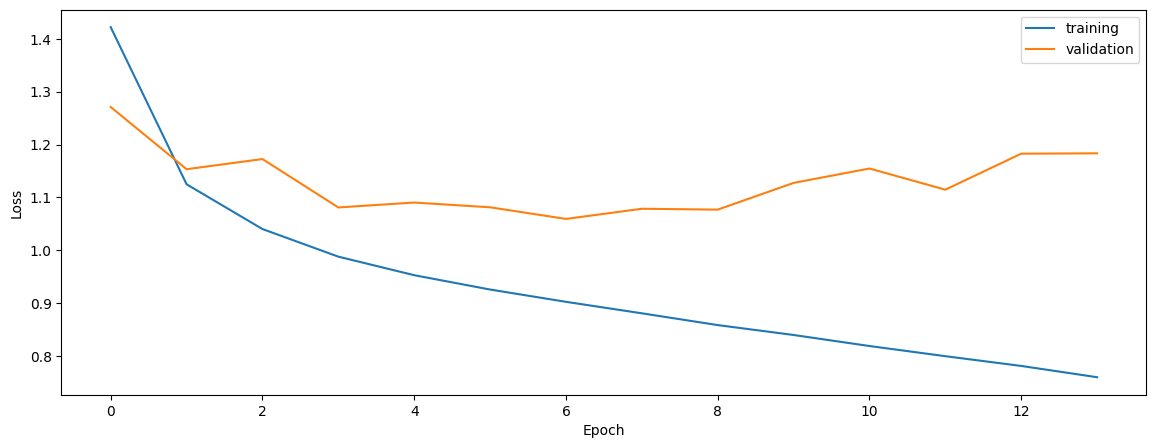

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6512973399144656
0.5873167306996537
0.6131728193173516


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.5903566811164347
0.5769416953528399
0.5431263906461323


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.591612619828945
0.5700297062383101
0.5511654349061967


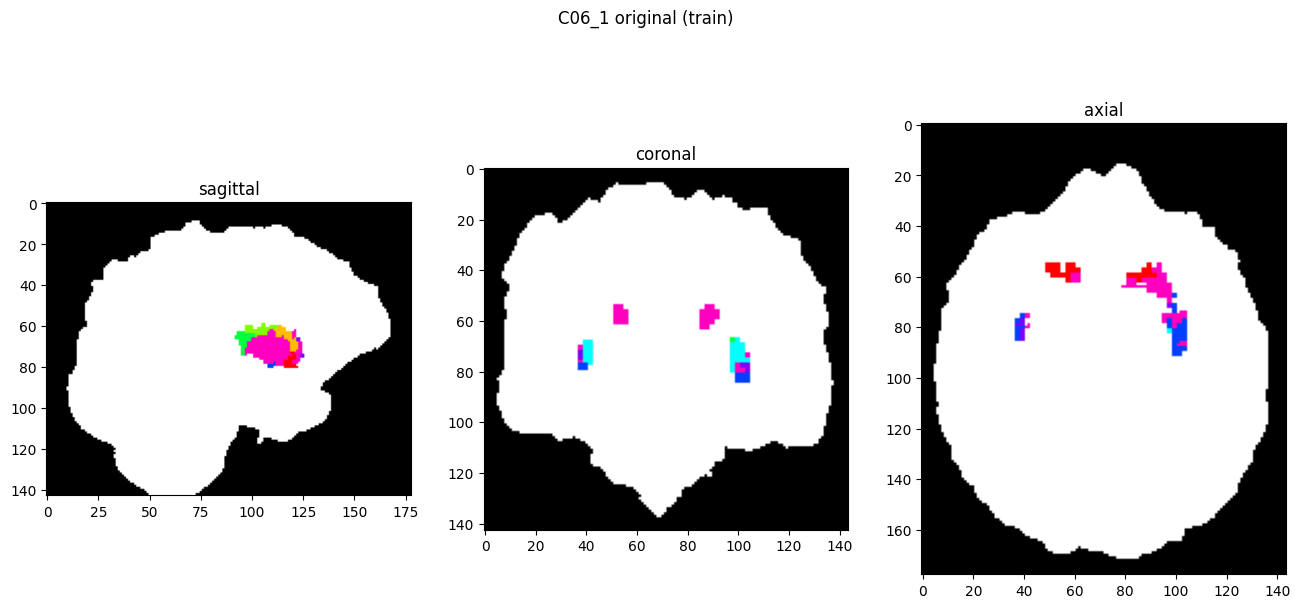

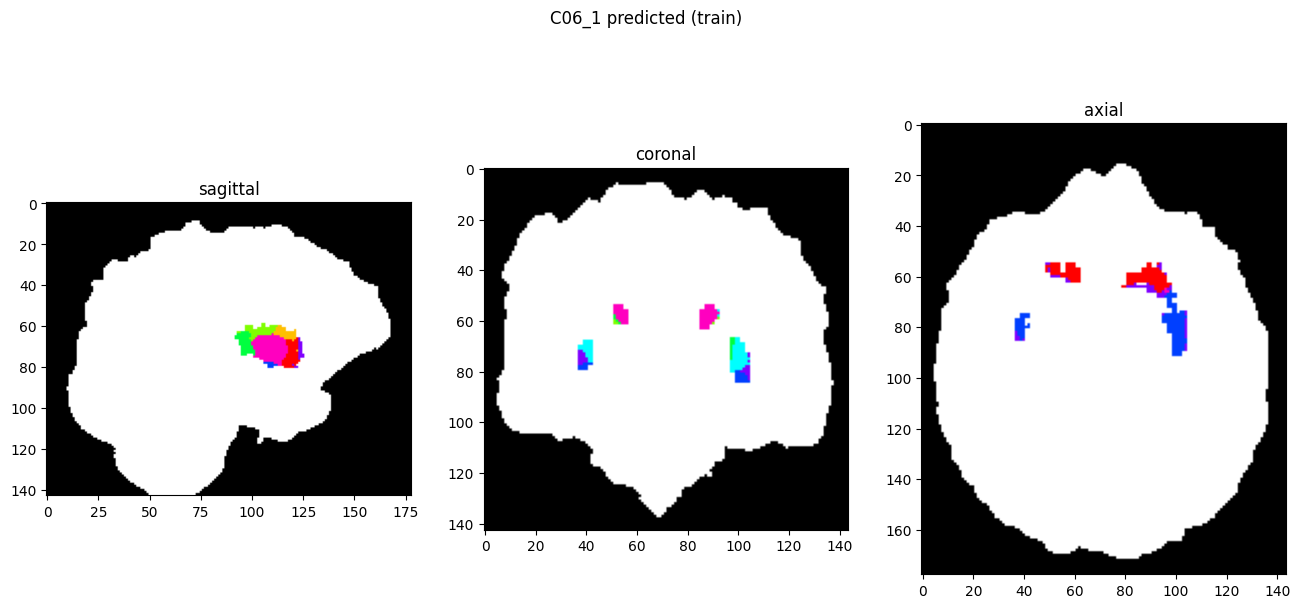

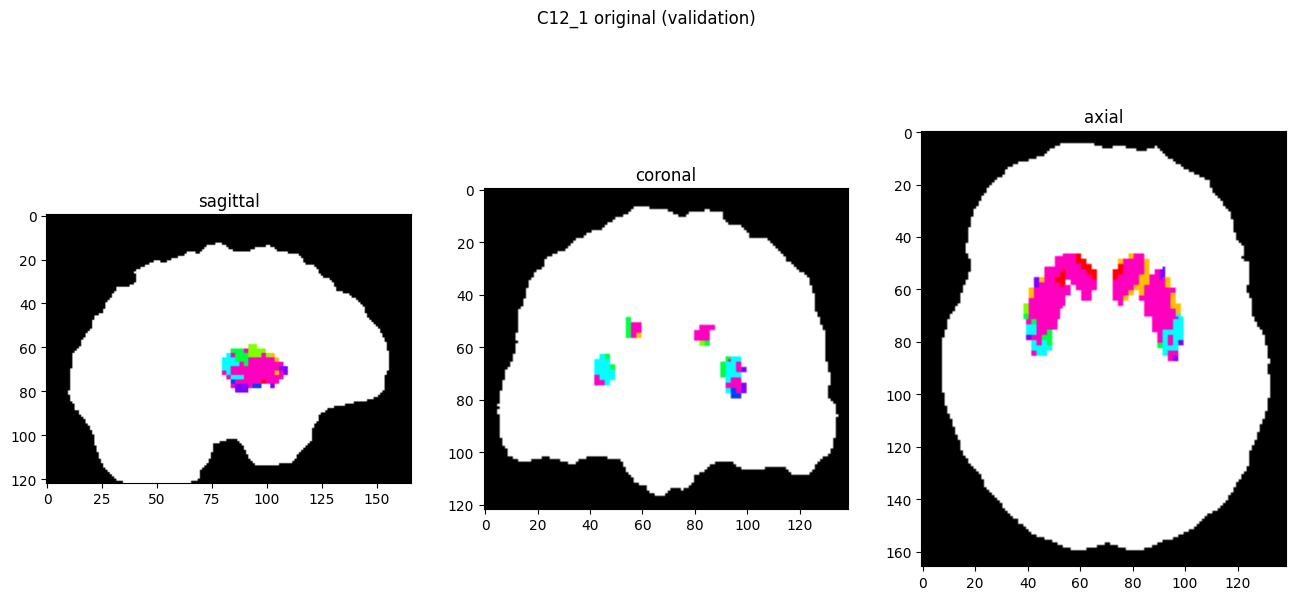

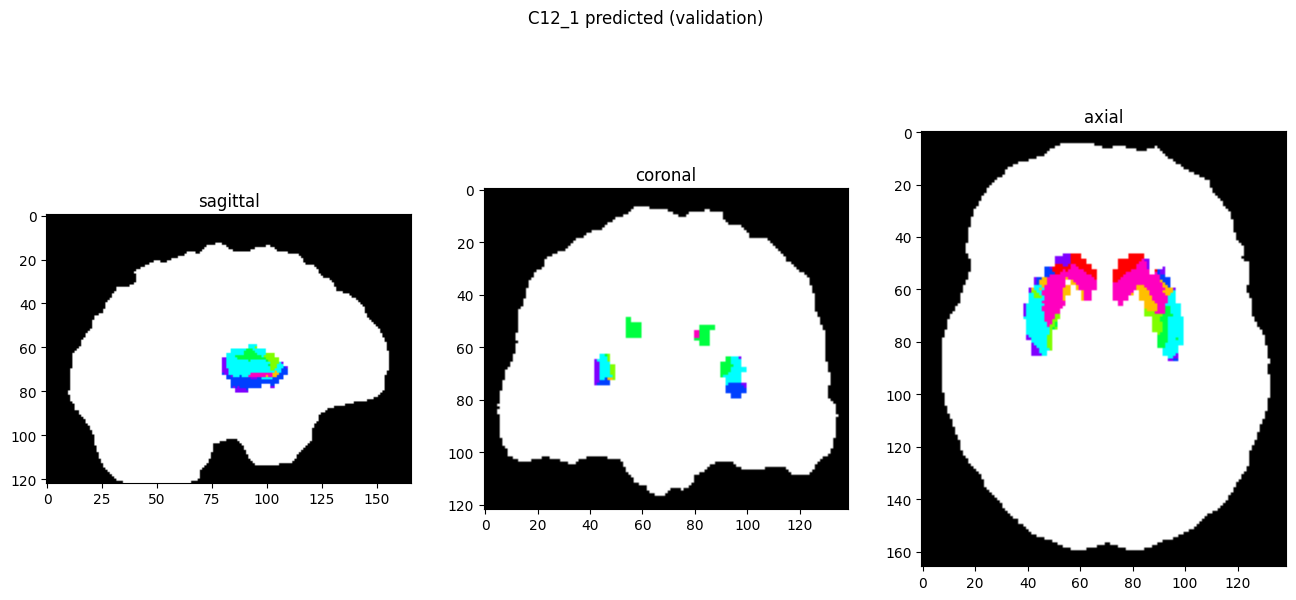

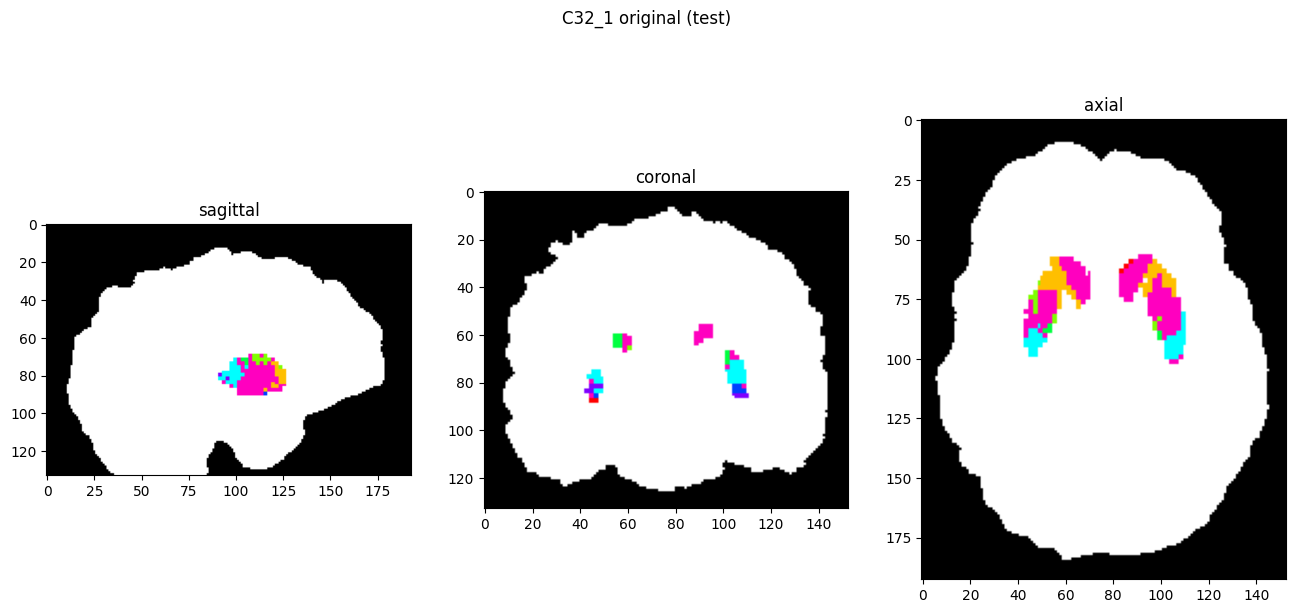

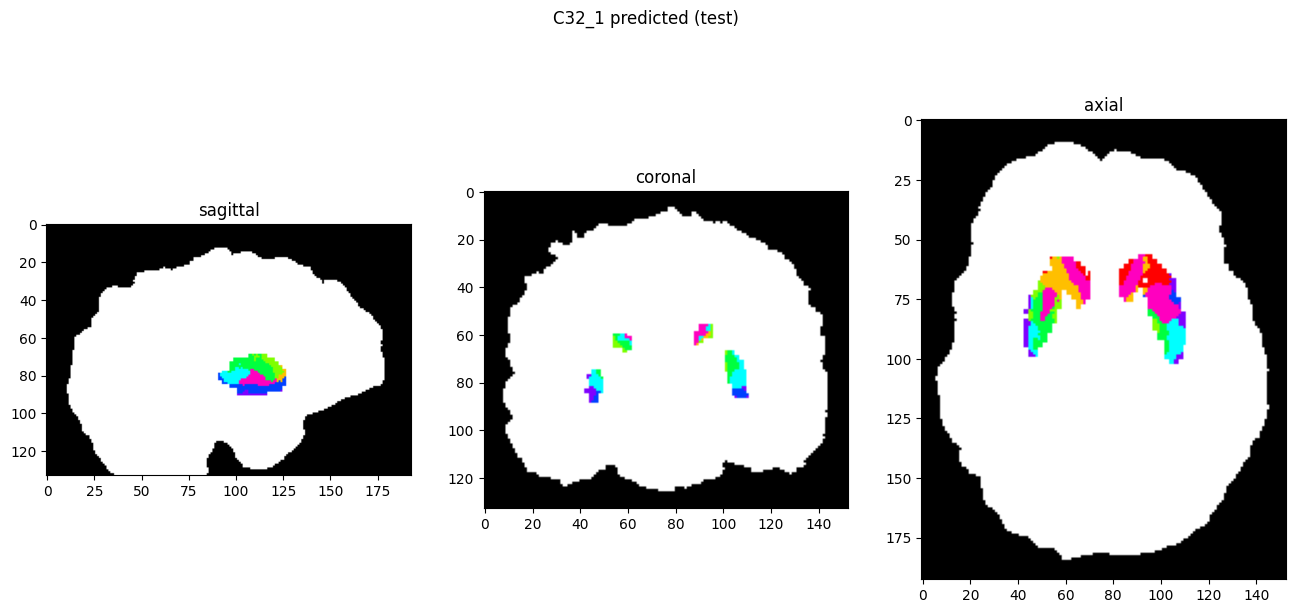

In [10]:
showResults(model, gen, threshold=0)